## Notebook to compare the different explainability methods for Transynergy

In [1]:
import sys
from pathlib import Path
import os 

project_root = Path.cwd().parents[1]  
sys.path.append(str(project_root))
os.chdir(project_root)

In [2]:
from explainability.explaination_config import ExplainationConfig
config = ExplainationConfig(
    paper="transynergy",
)
feature_names = config.feature_names

In [3]:
from explainability.shapley.utils import load_shap_data
import numpy as np
import torch

shap_values, inputs, feature_names, shap_indices = load_shap_data("transynergy")
print(shap_values.shape)

SAVE_PATH = "explainability/ig/results/transynergy_integrated_gradients_shuffled.pt"
all_attributions = torch.load(SAVE_PATH, weights_only=False)
ig_values = all_attributions.squeeze(axis=1) 
ig_values = ig_values.detach().cpu().numpy()
ig_values = ig_values.reshape(ig_values.shape[0], -1)
print(ig_values.shape)

lrp_values = np.load("explainability/lrp/results/transynergy_subsample_False/relevances.npy")
lrp_values = lrp_values.reshape(lrp_values.shape[0], -1)
print(lrp_values.shape)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


(1803, 7206)
(22300, 7206)
(7708, 7206)


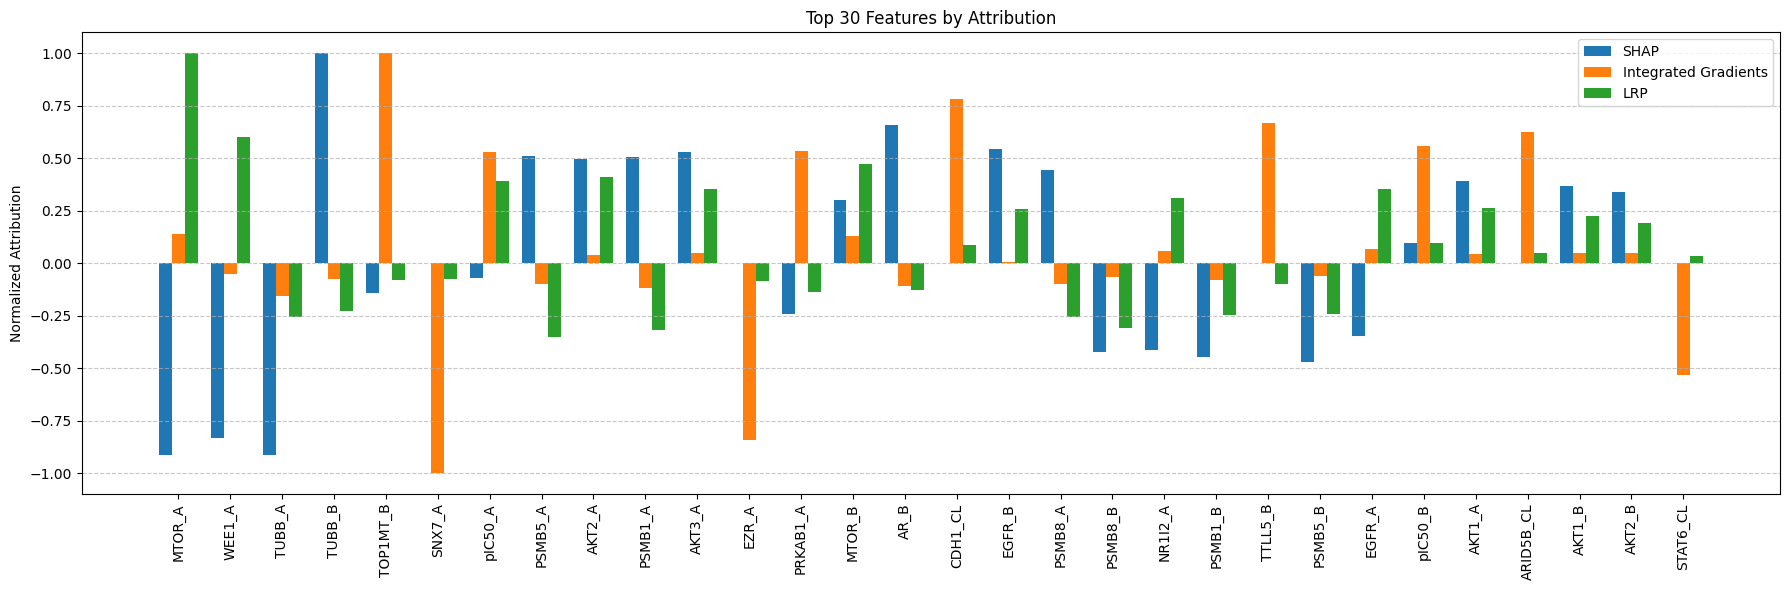

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_and_rescale(arr):
    mean_vals = np.mean(arr, axis=0)
    normed = mean_vals / np.sum(np.abs(mean_vals))
    return normed / np.max(np.abs(normed))

shap_norm = normalize_and_rescale(shap_values)
ig_norm = normalize_and_rescale(ig_values)
lrp_norm = normalize_and_rescale(lrp_values)

mean_importance = (
    np.abs(shap_norm) + np.abs(ig_norm) + np.abs(lrp_norm)
) / 3.0

top_k = 30
top_indices = np.argsort(mean_importance)[-top_k:][::-1]

x = np.arange(top_k)
shap_top = shap_norm[top_indices]
ig_top = ig_norm[top_indices]
lrp_top = lrp_norm[top_indices]
feature_names_top = [feature_names[i] for i in top_indices]

width = 0.25
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(x - width, shap_top, width, label='SHAP')
ax.bar(x, ig_top, width, label='Integrated Gradients')
ax.bar(x + width, lrp_top, width, label='LRP')

ax.set_ylabel('Normalized Attribution')
ax.set_title(f'Top {top_k} Features by Attribution')
ax.set_xticks(x)
ax.set_xticklabels(feature_names_top, rotation=90)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


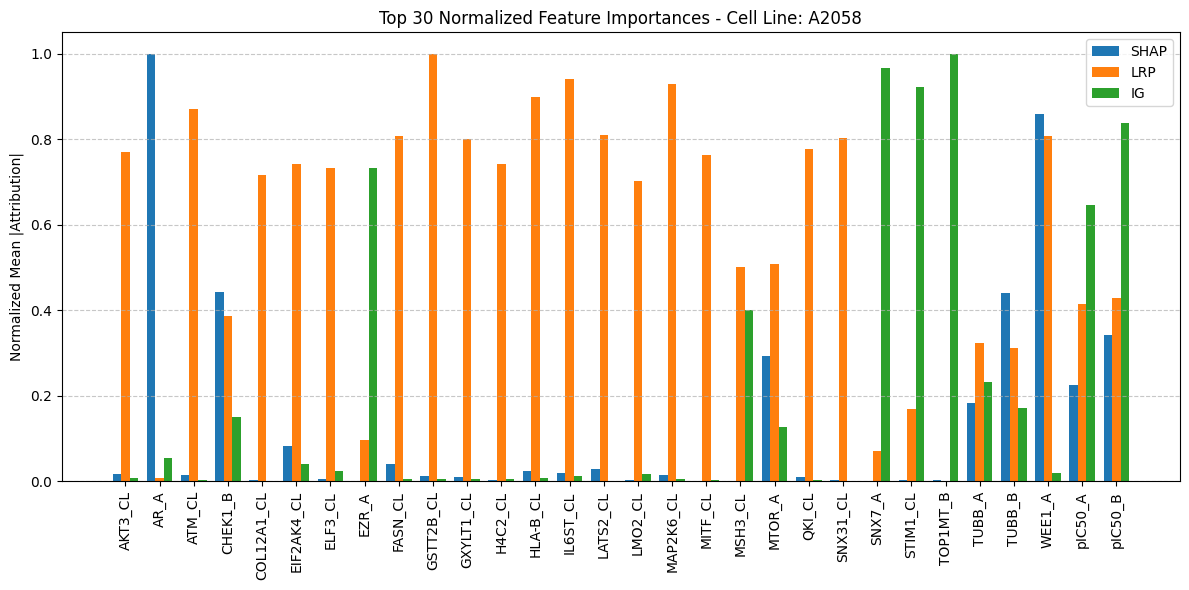

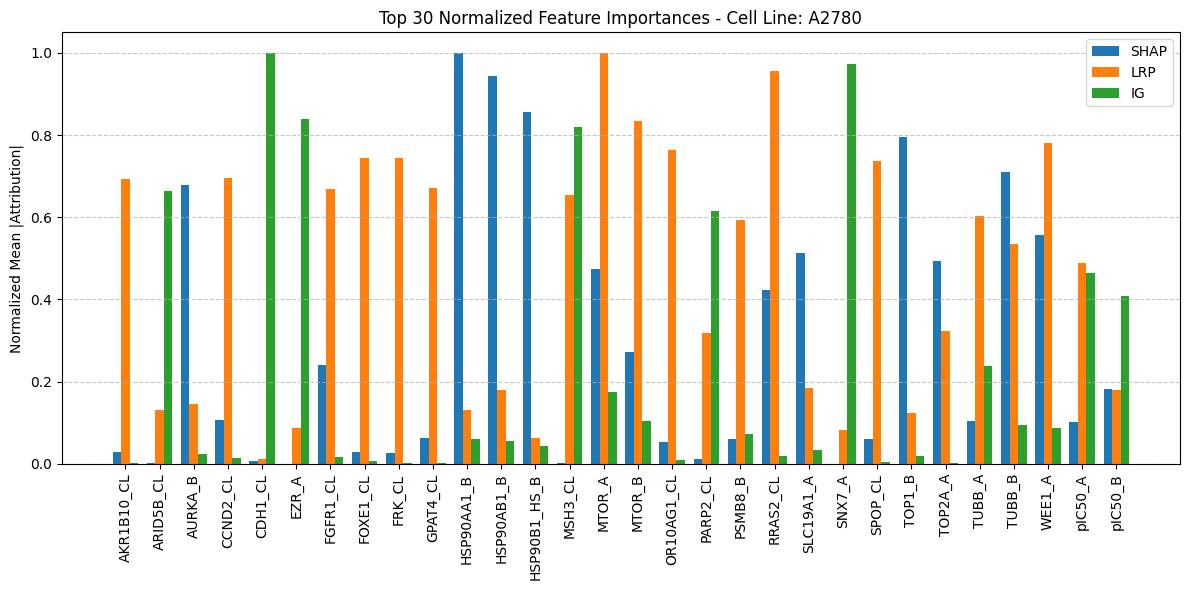

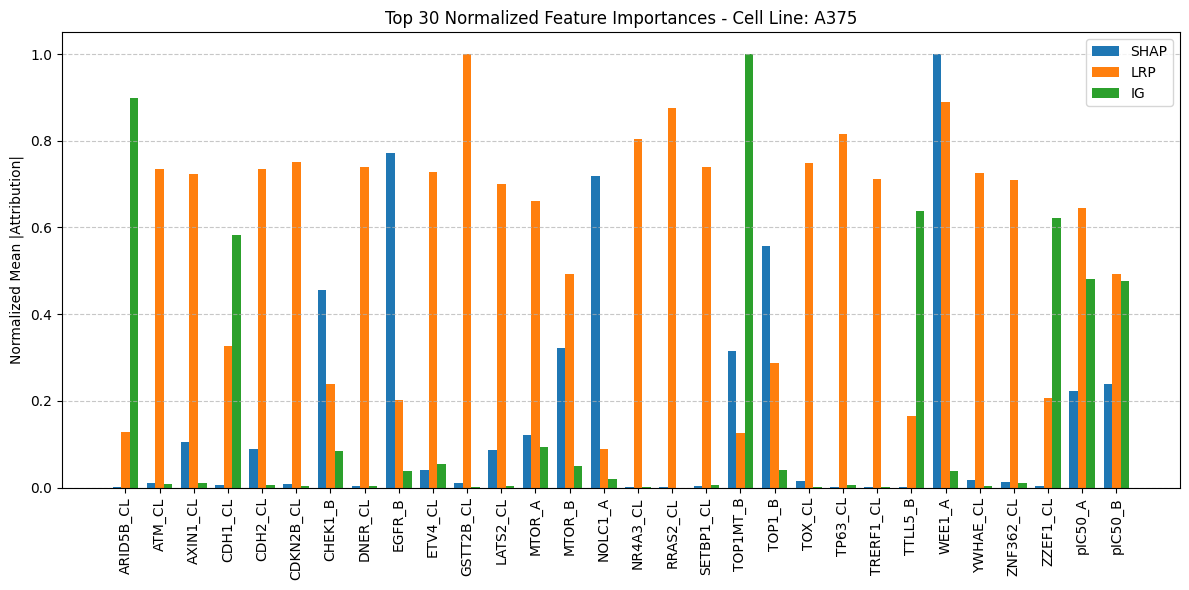

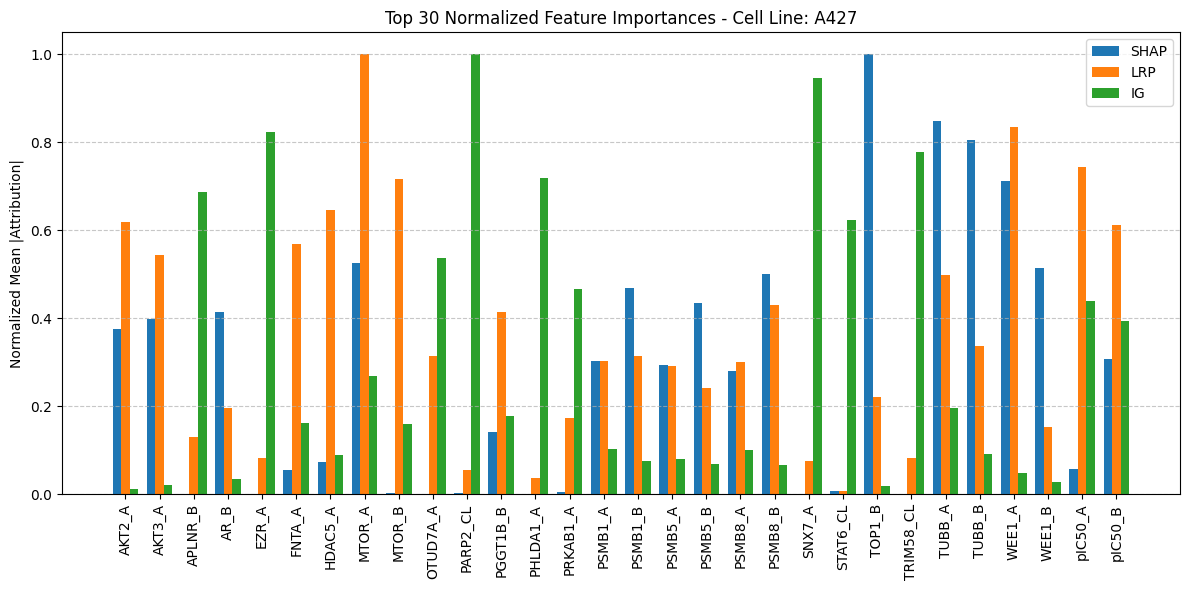

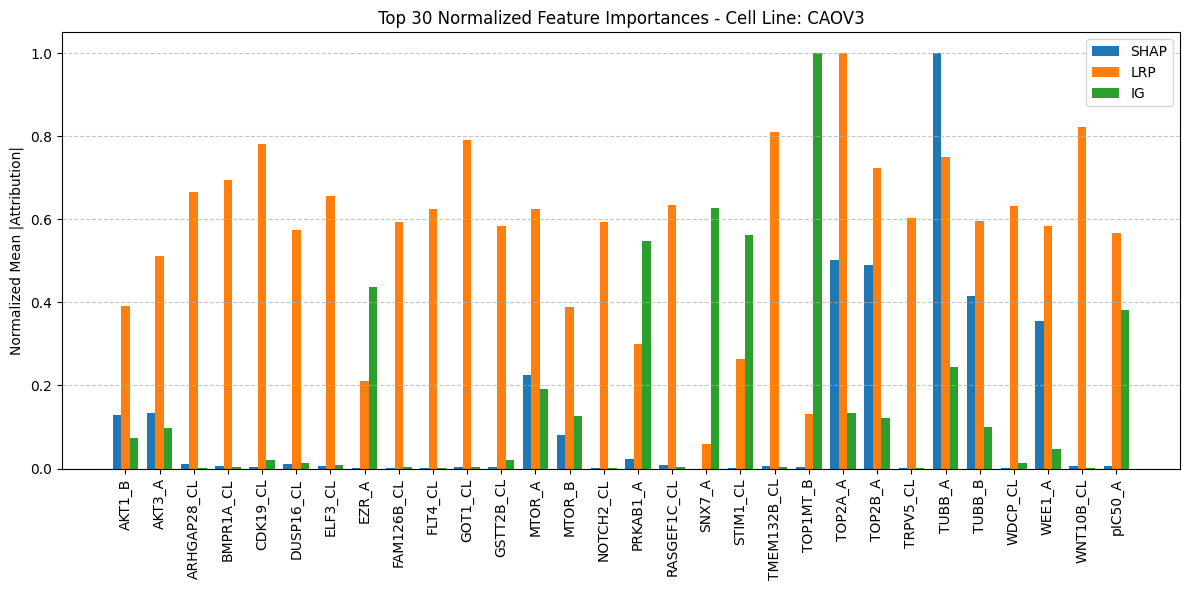

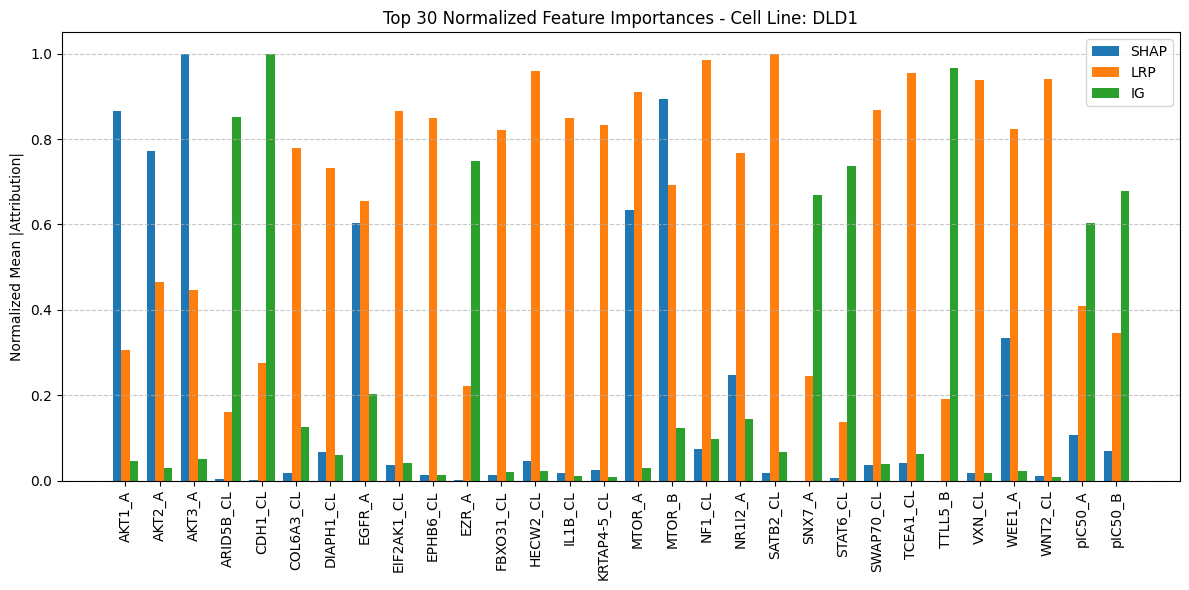

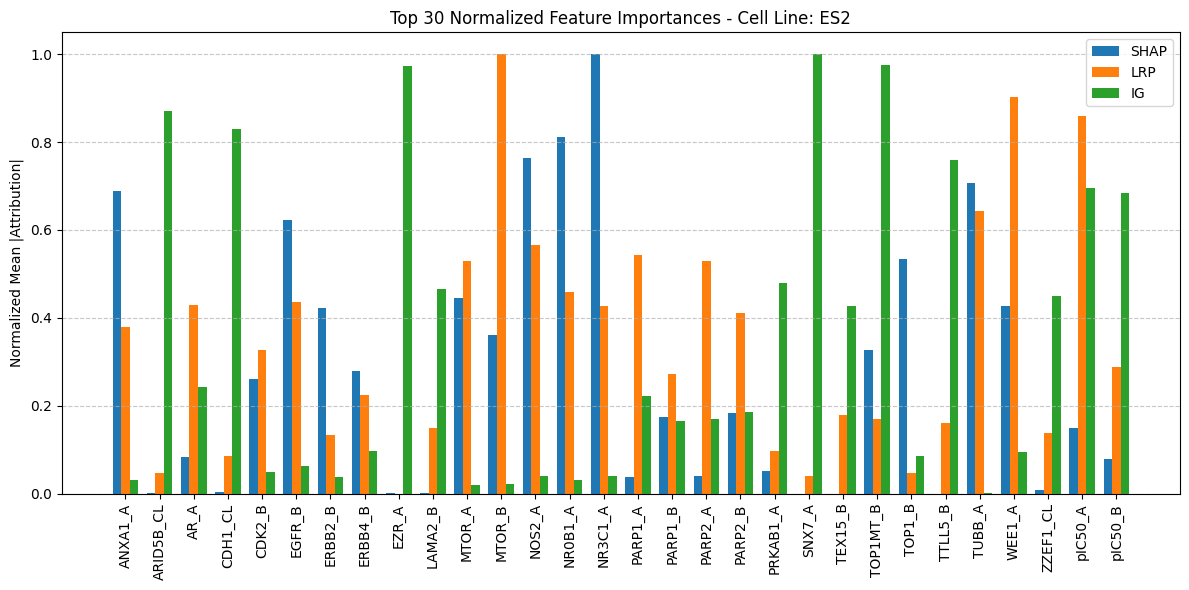

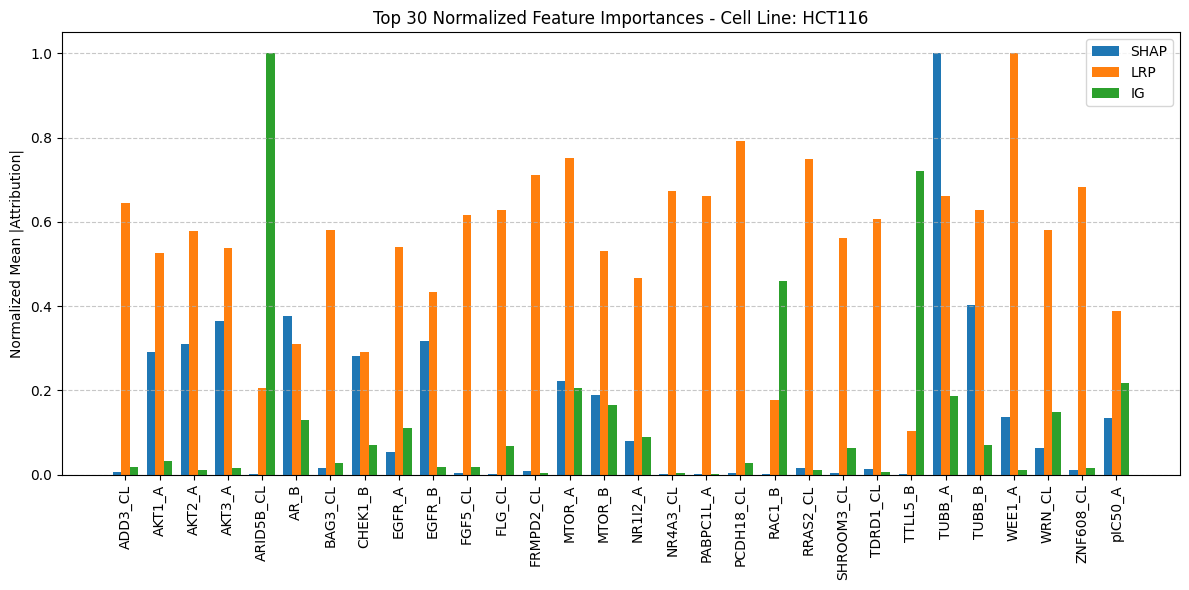

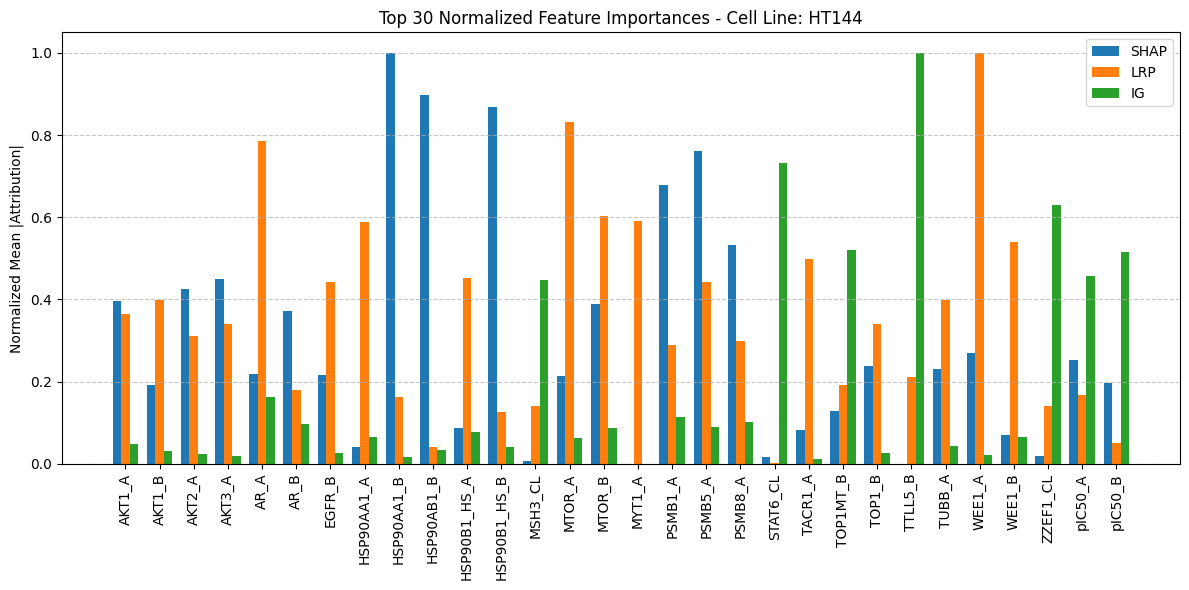

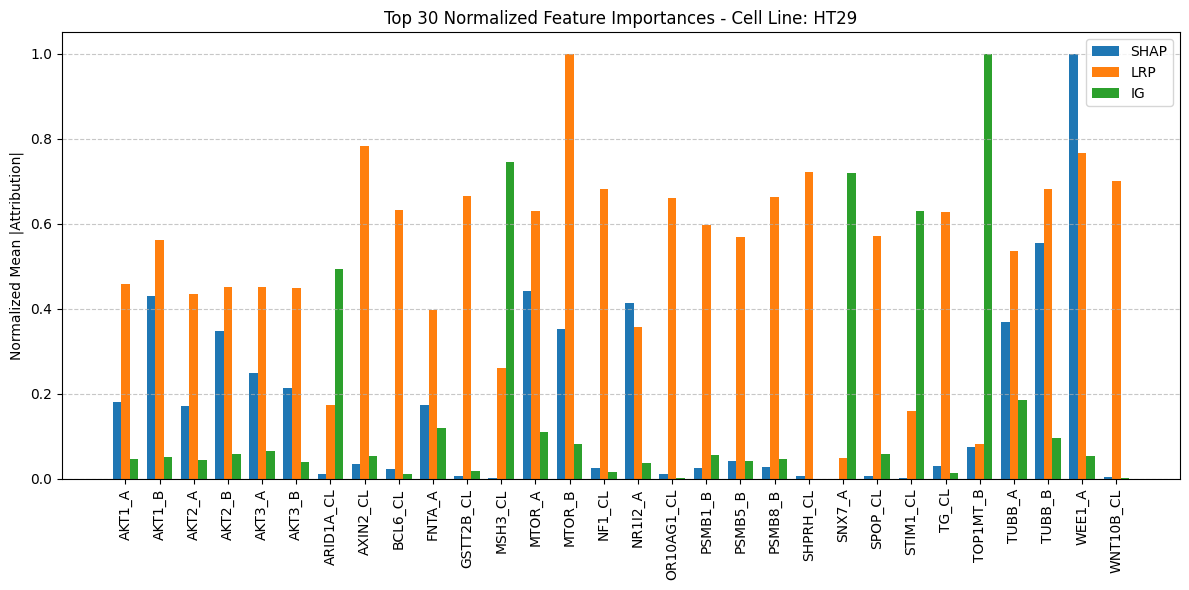

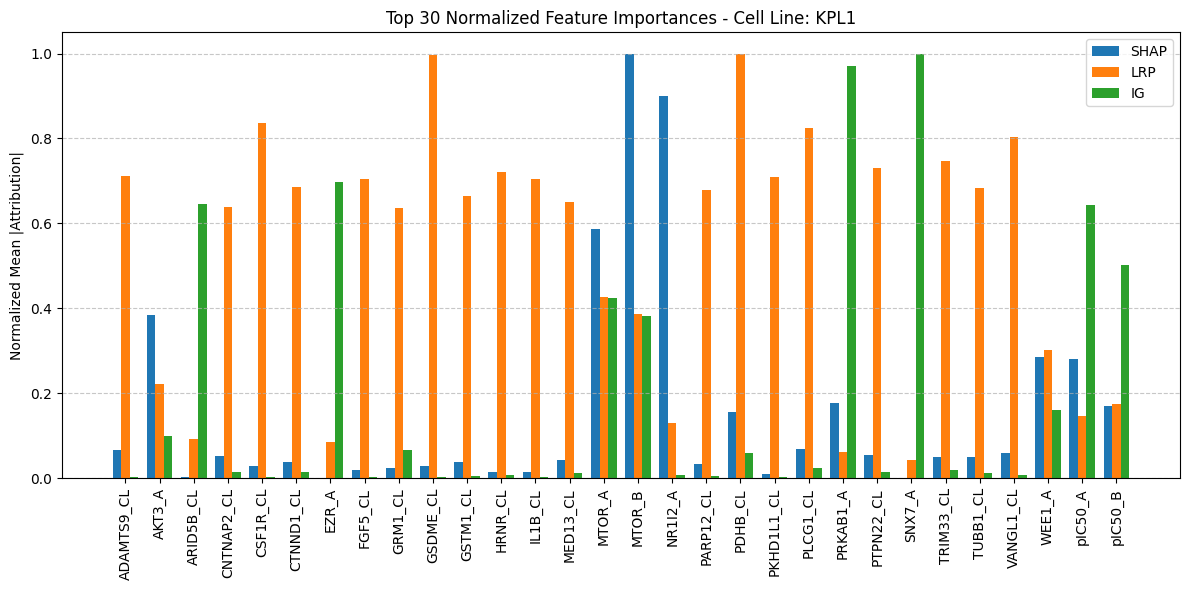

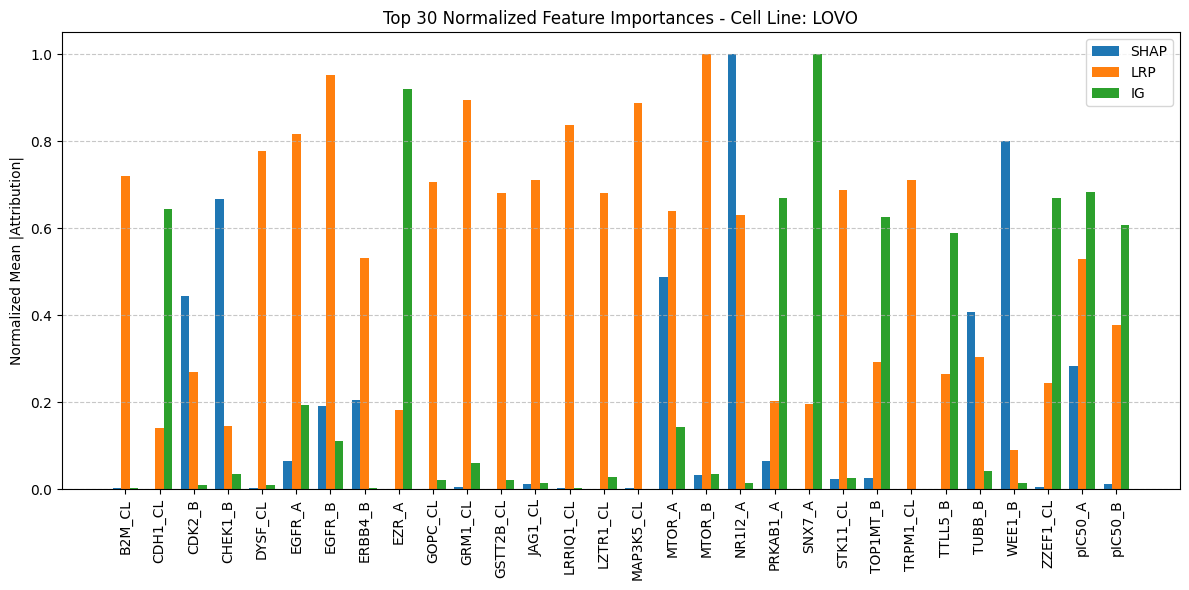

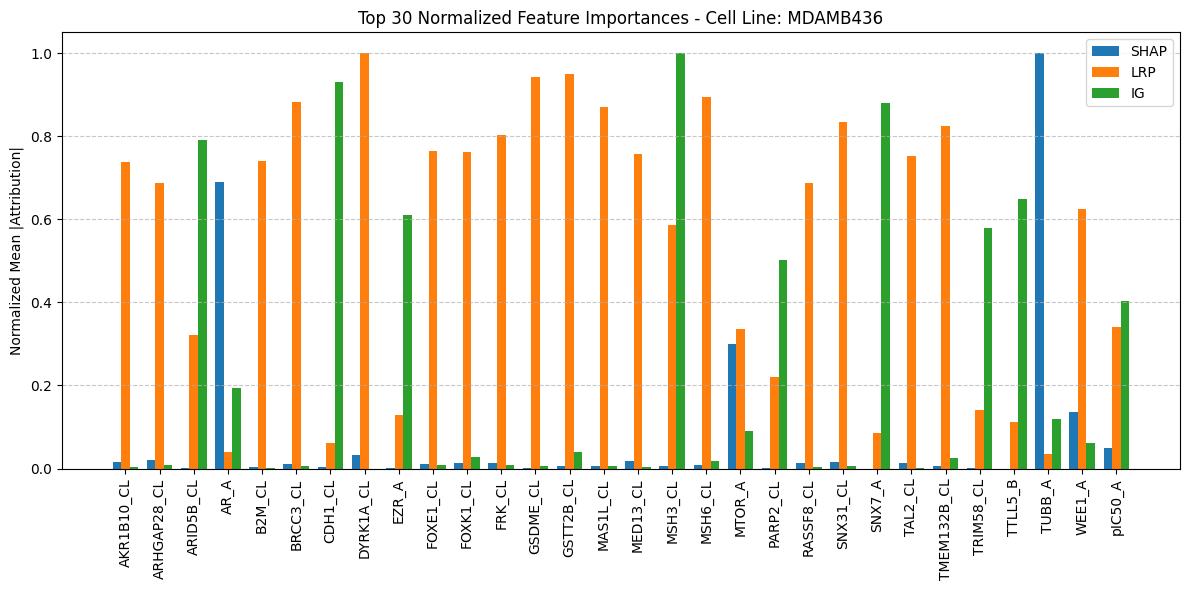

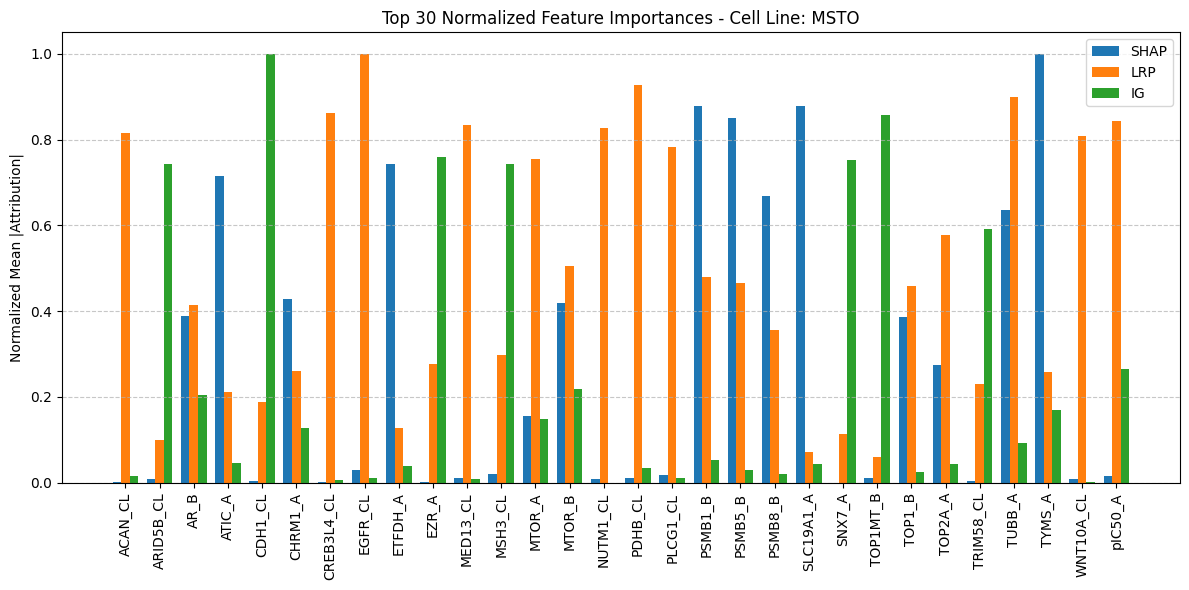

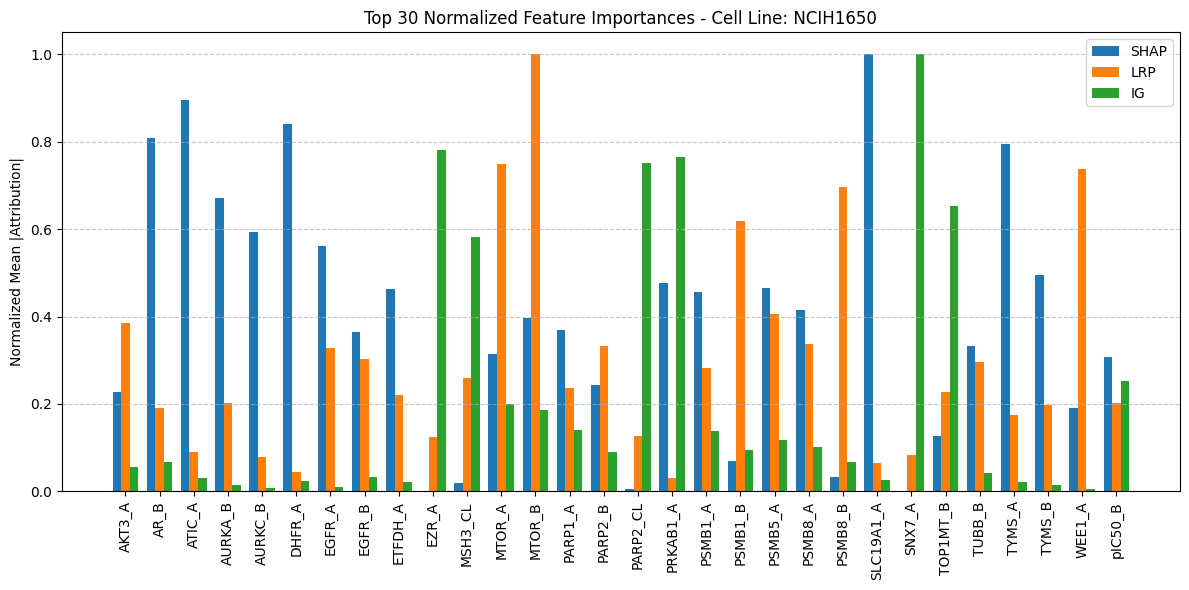

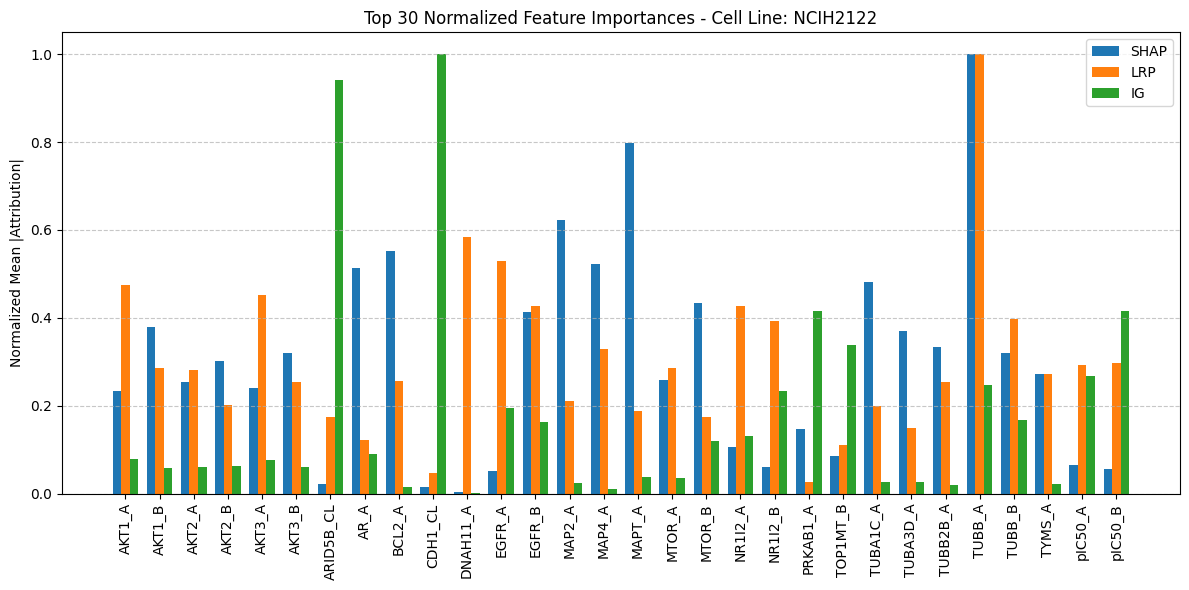

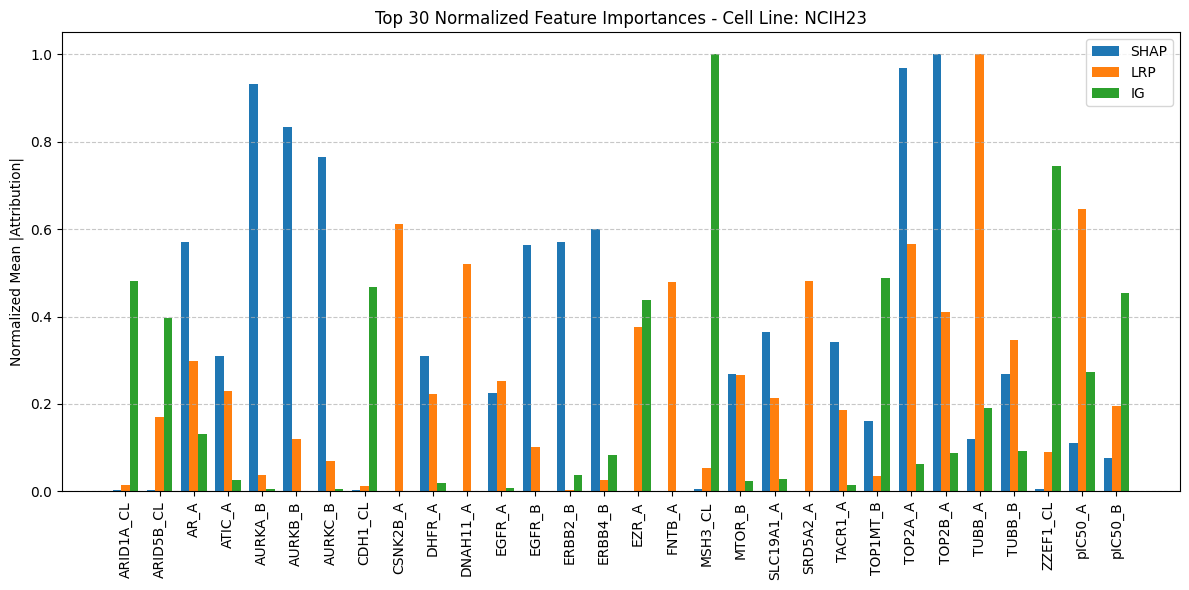

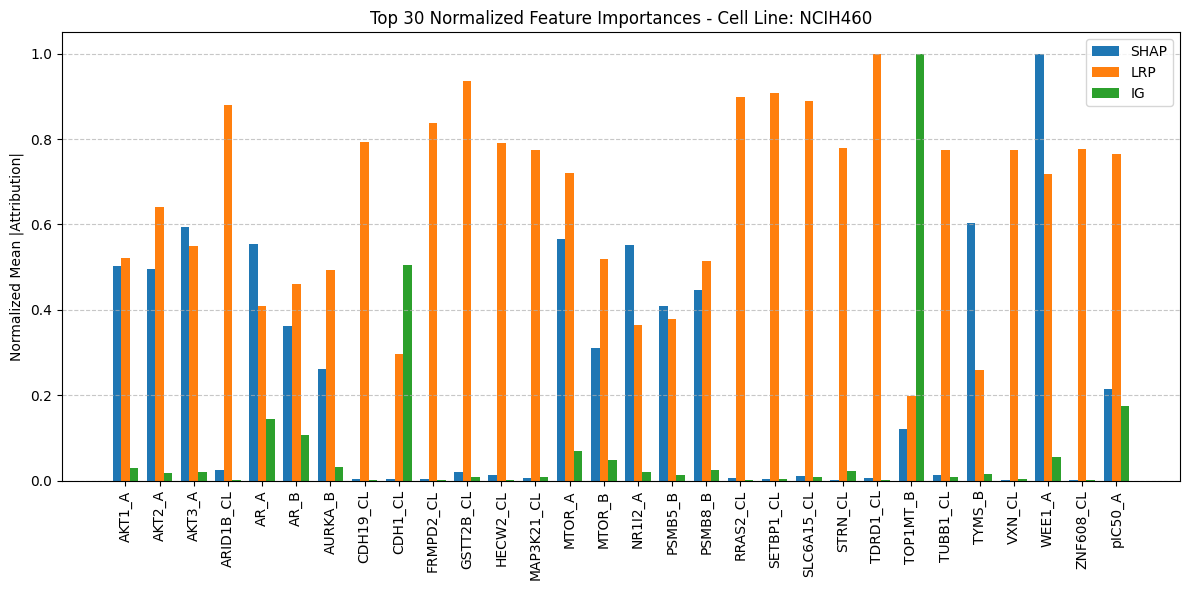

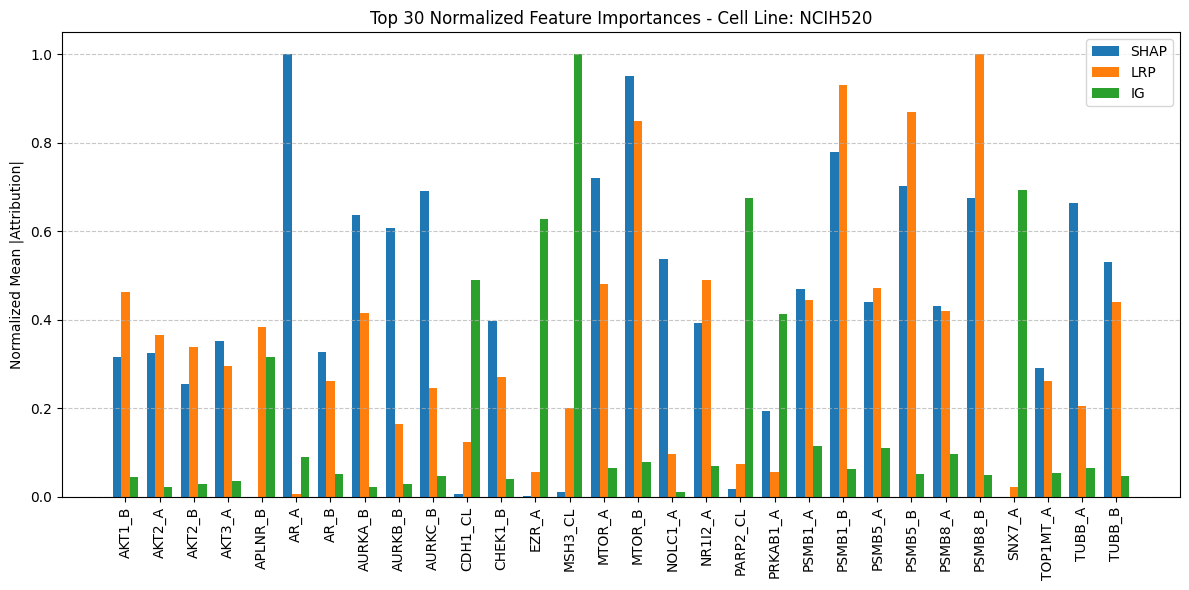

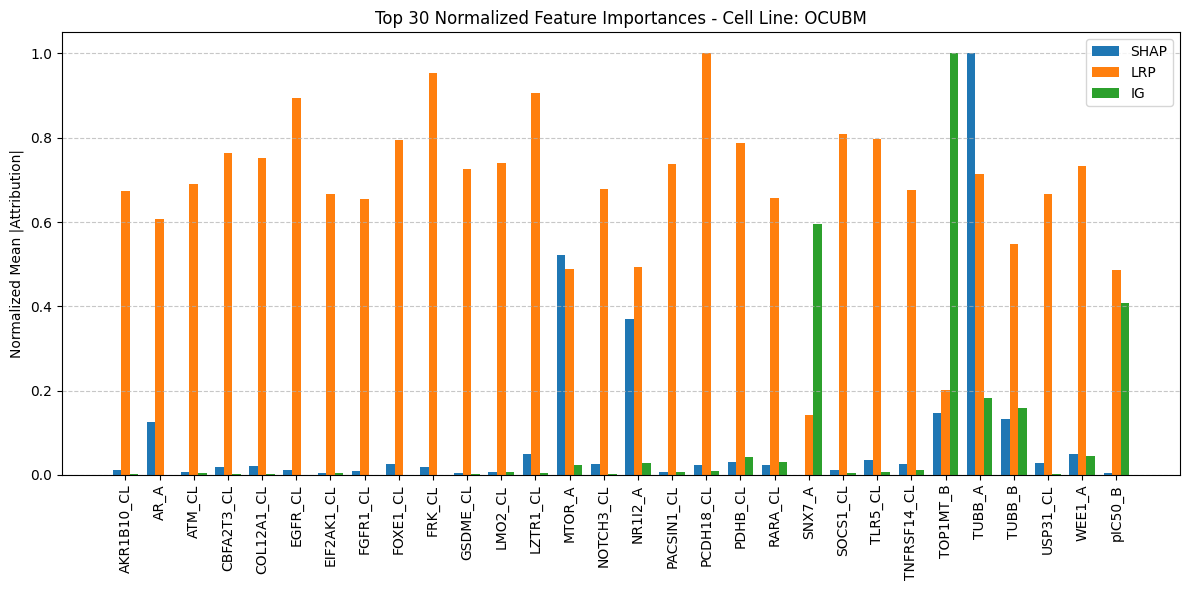

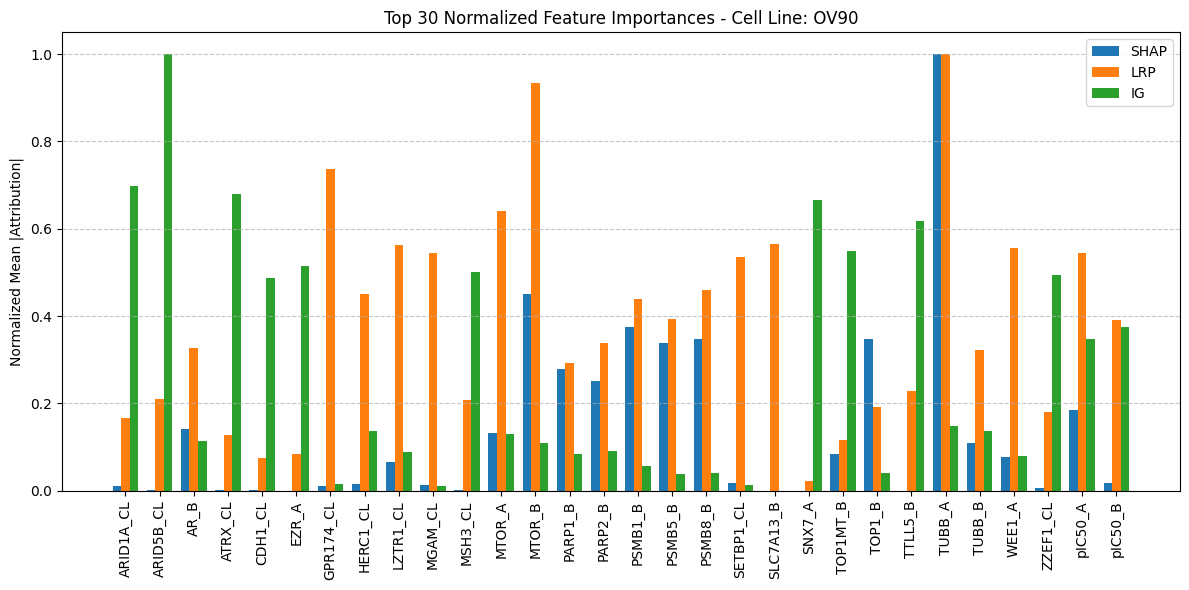

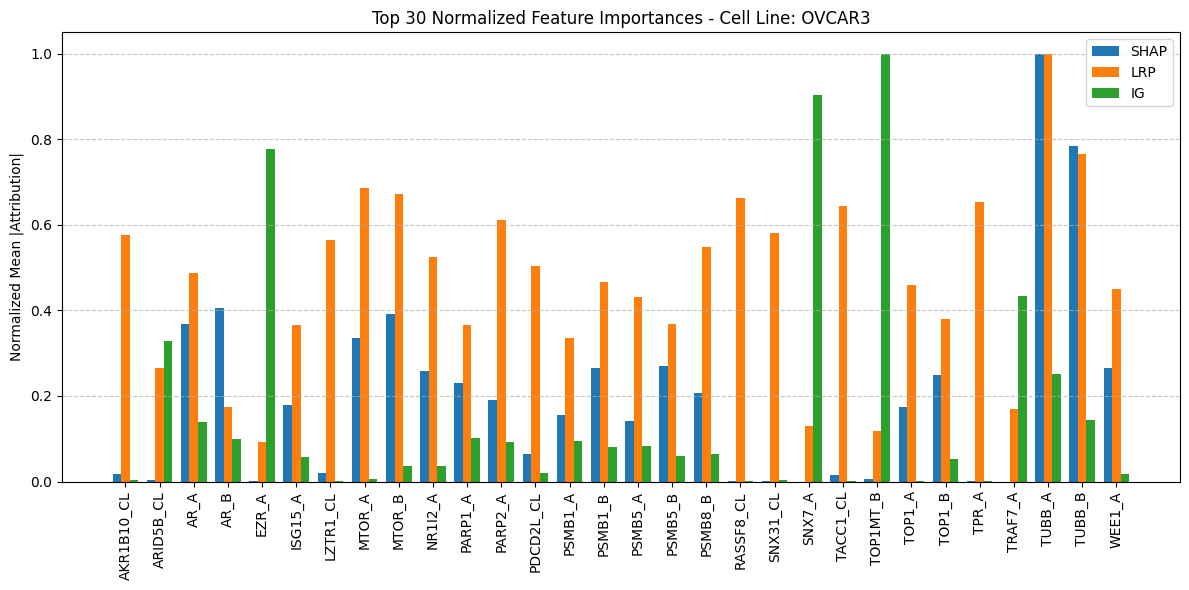

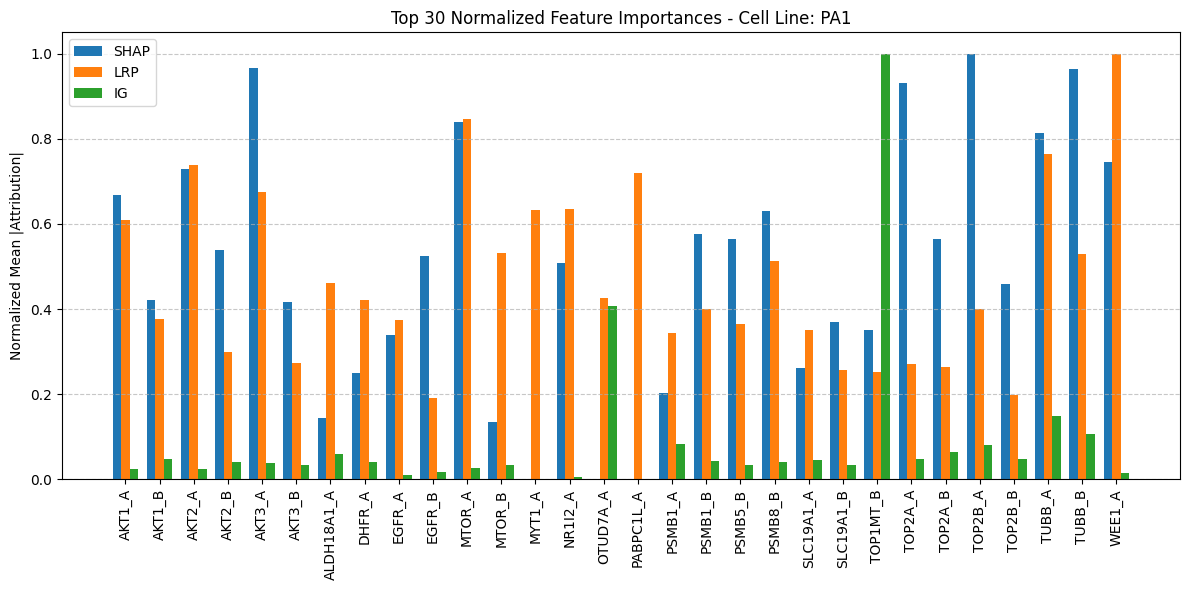

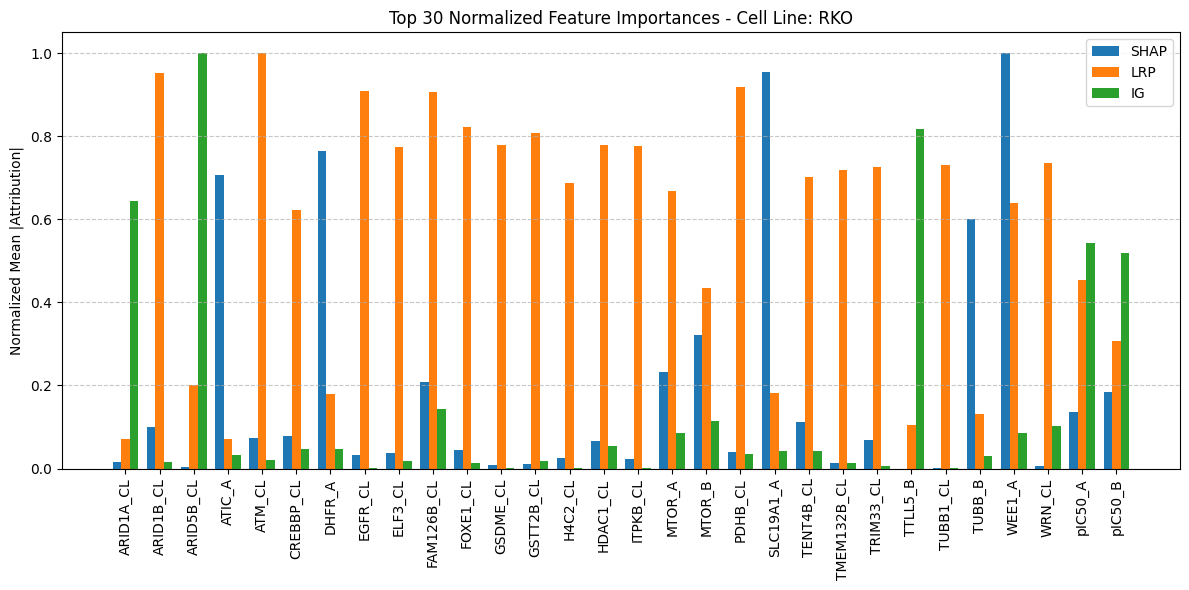

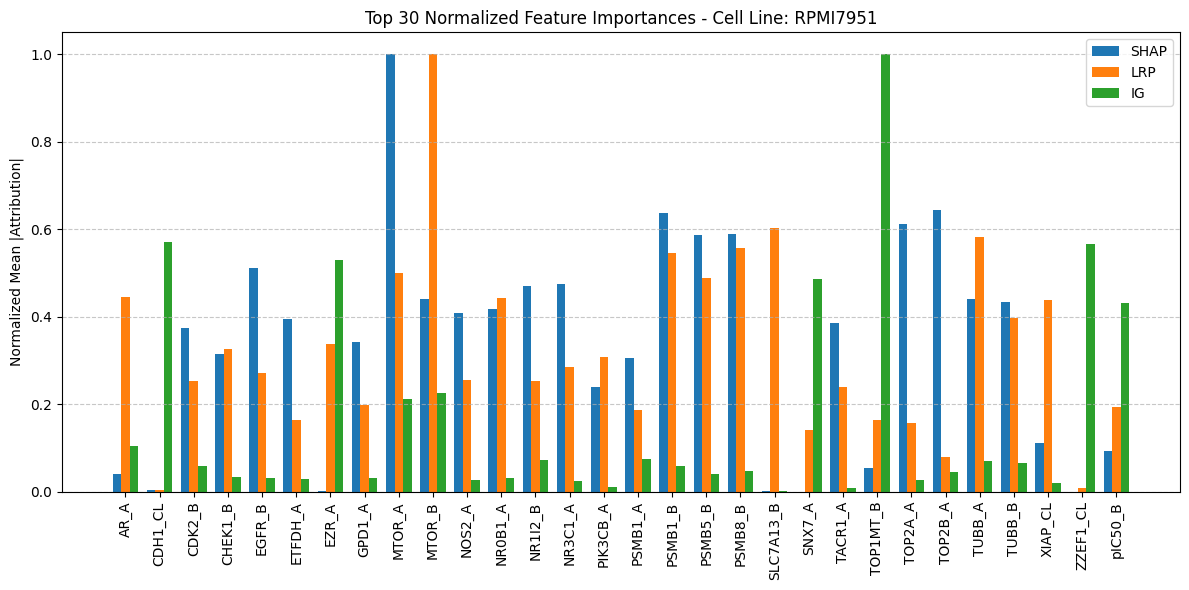

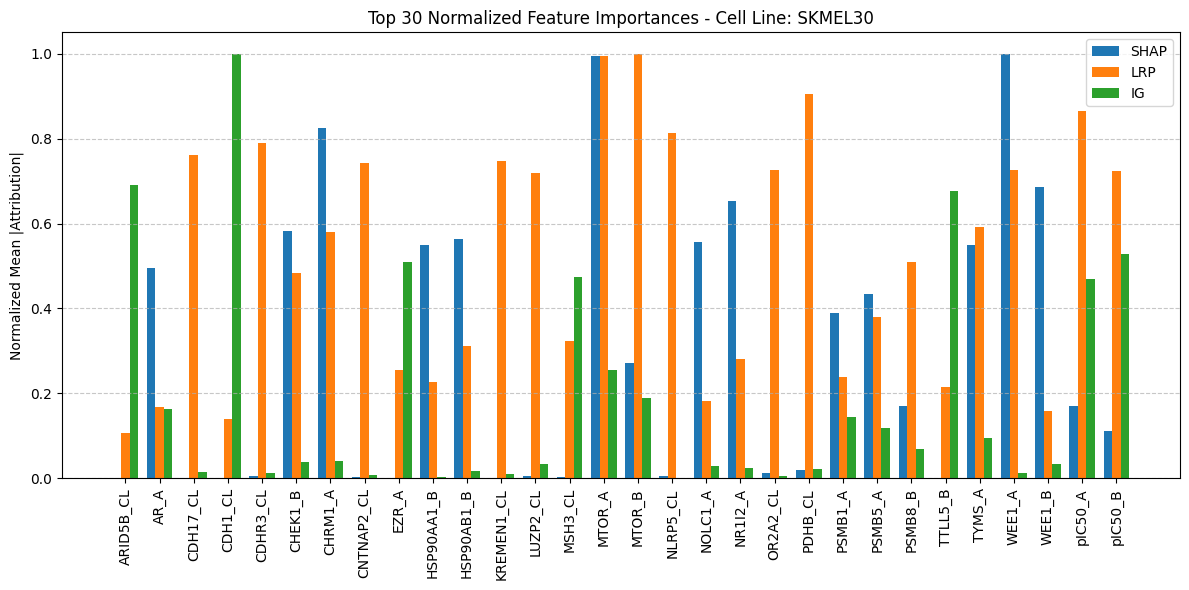

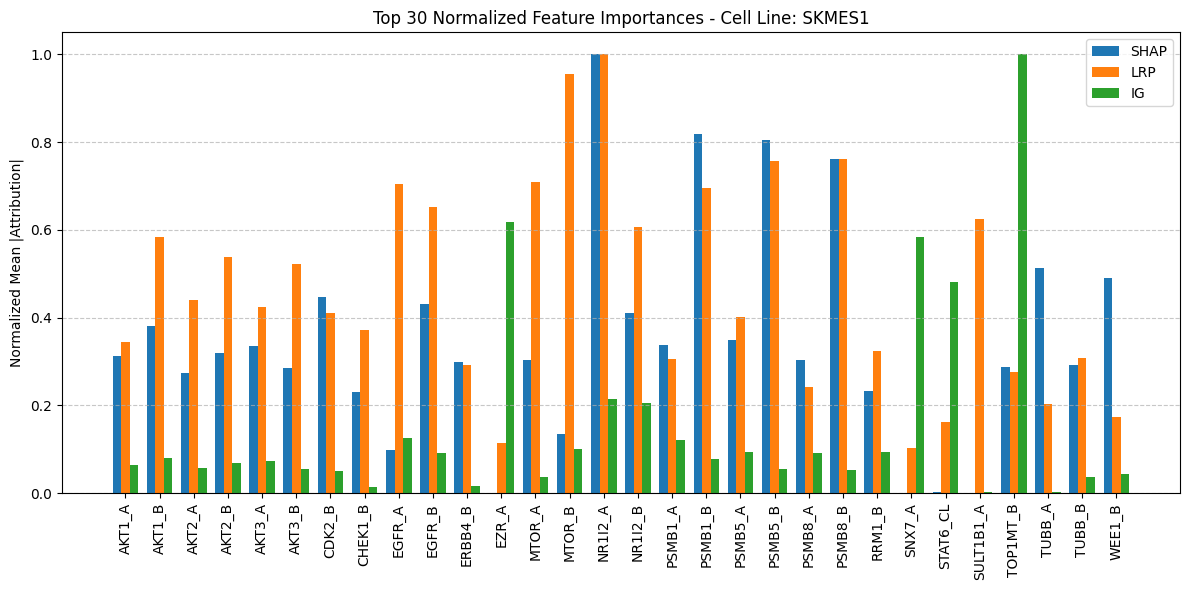

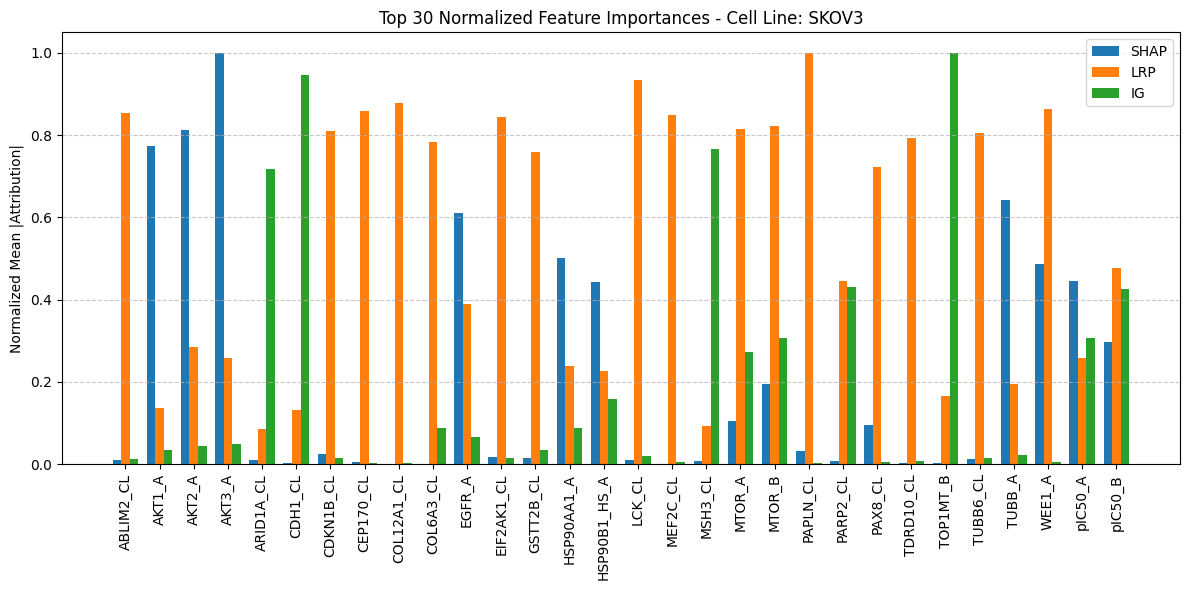

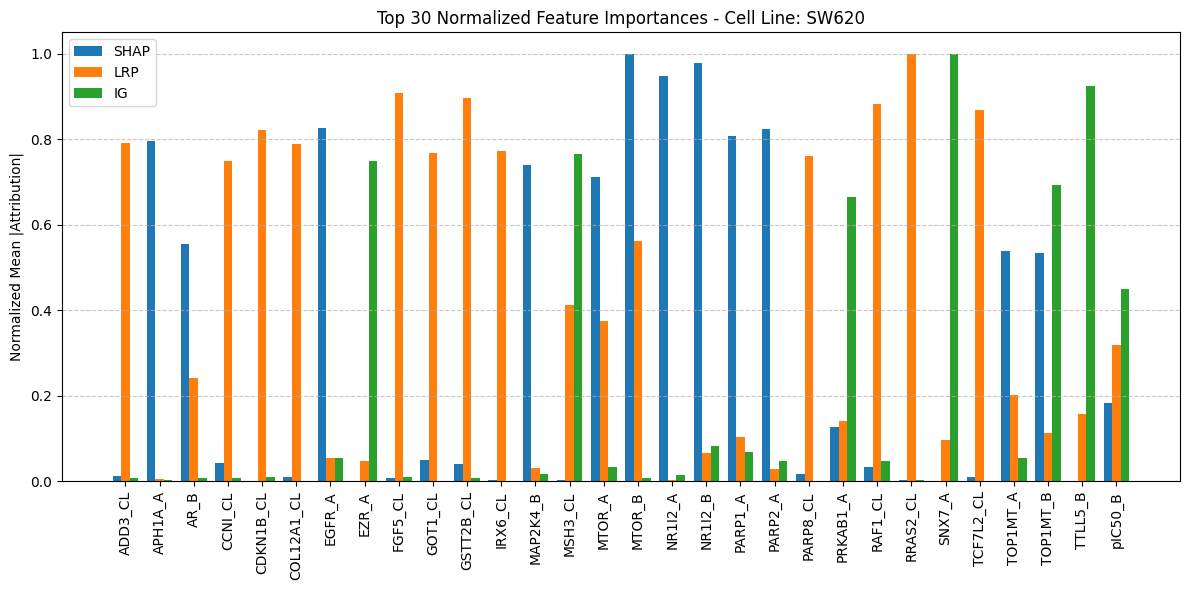

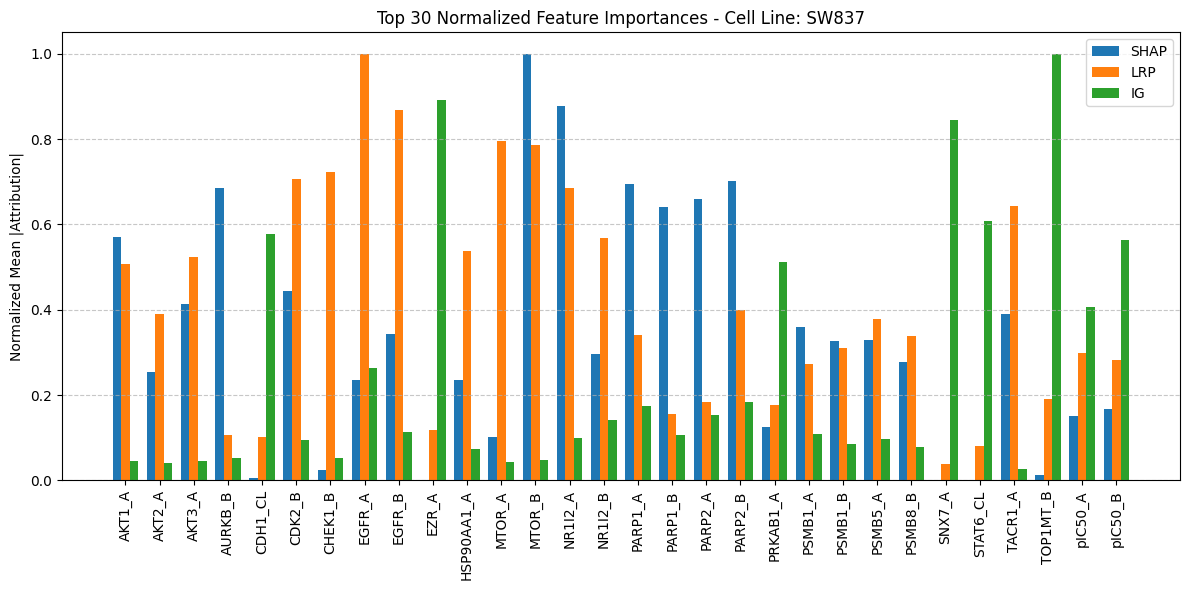

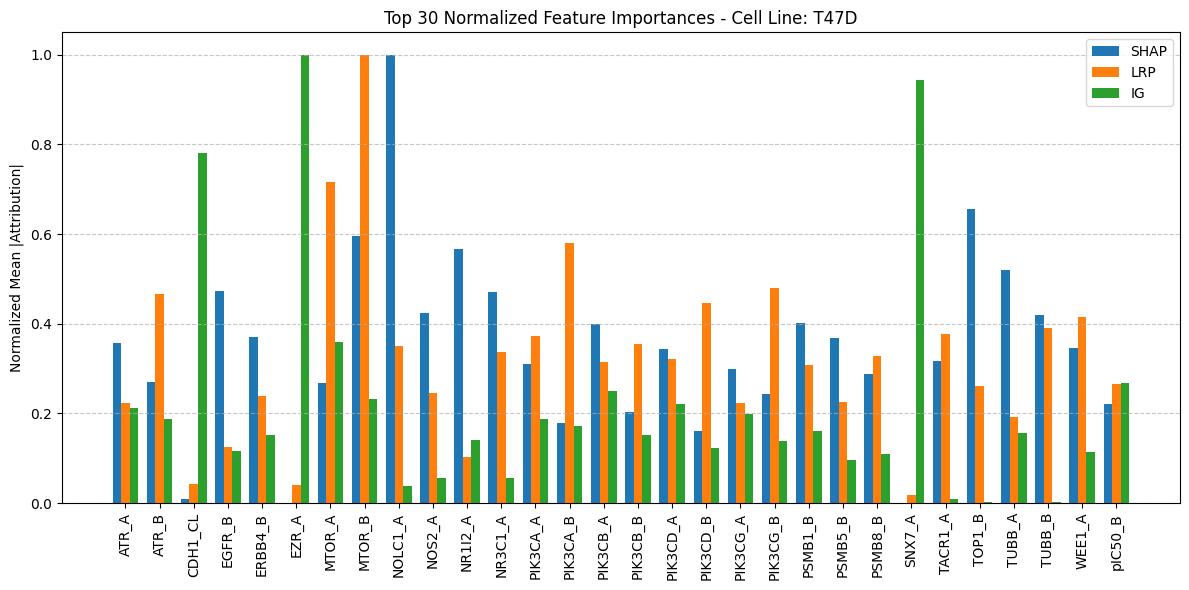

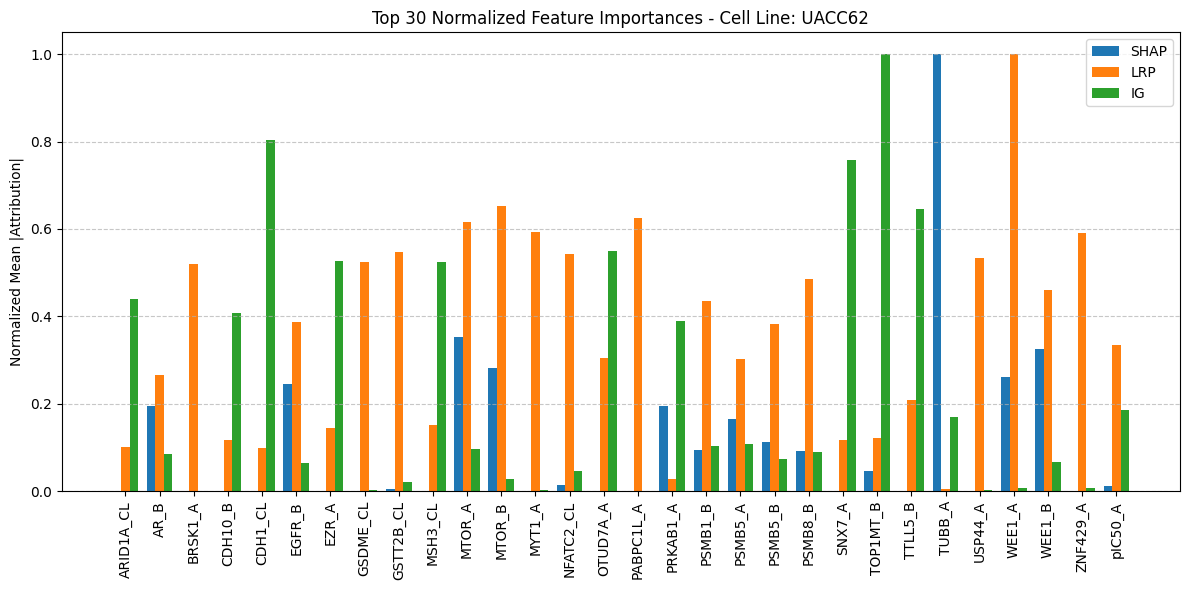

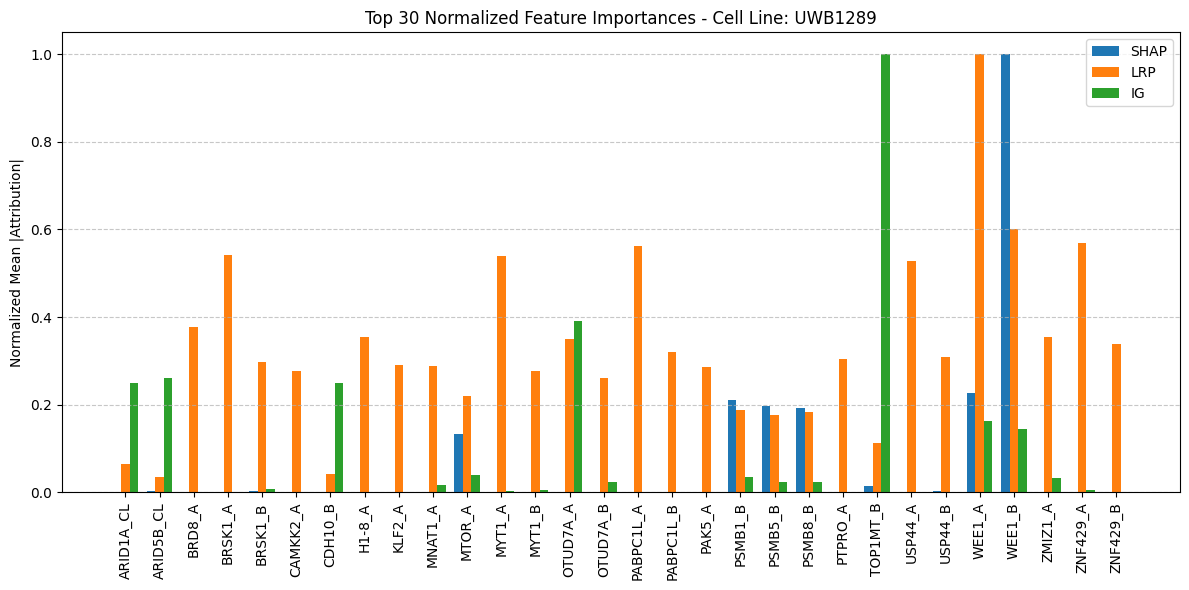

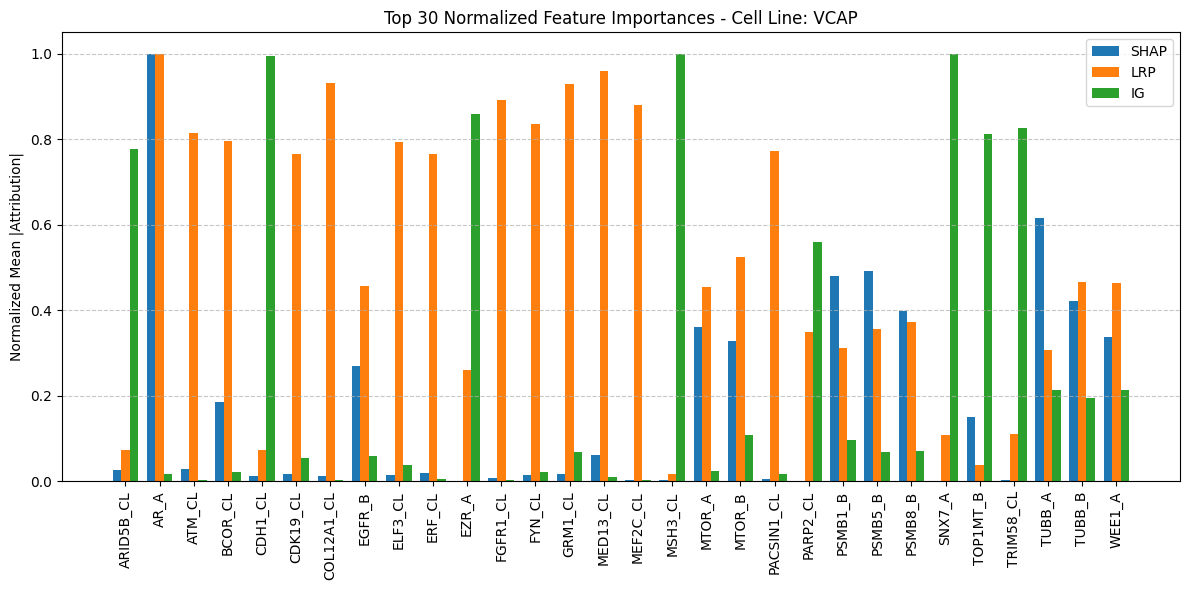

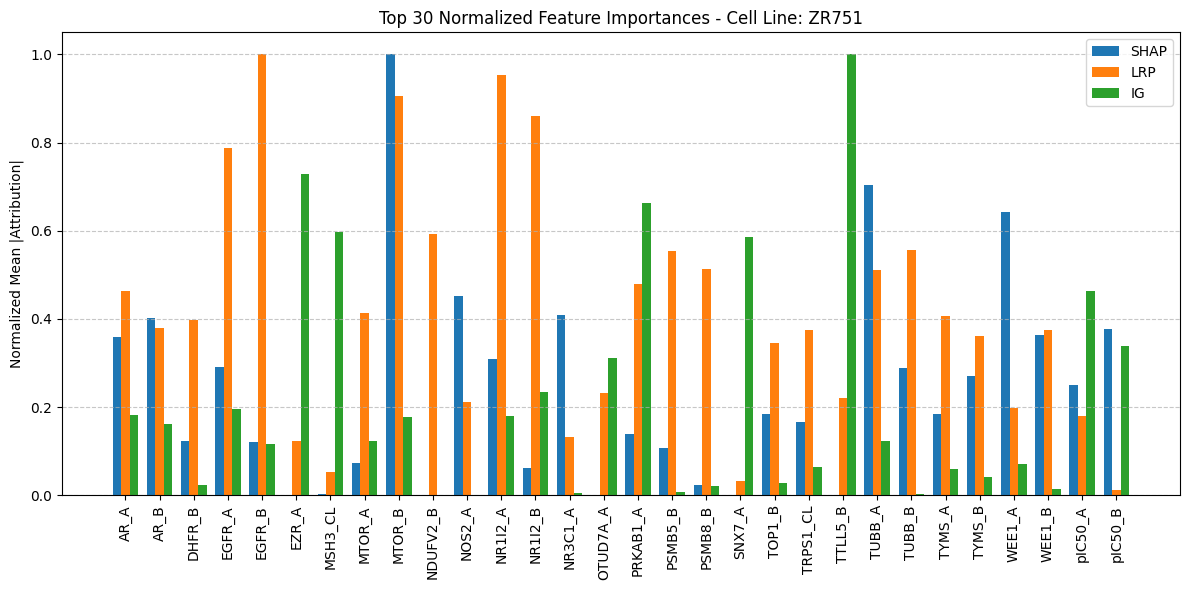

In [5]:
from explainability.data_utils import load_transynergy_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def normalize_and_rescale_for_indices(attributions, indices):
    mean_vals = np.mean(attributions[indices], axis=0)  
    mean_abs = np.abs(mean_vals)  
    normed = mean_abs / np.sum(mean_abs)  
    return normed / np.max(normed) 

def plot_feature_importance_by_cell_line(shap_values, lrp_values, ig_values, shap_indices, feature_names, top_n=30):
    cell_lines_test = load_transynergy_cell_line_data(split='test')
    cell_lines_train = load_transynergy_cell_line_data(split='train')
    cell_lines_train = np.concatenate([cell_lines_train, cell_lines_train], axis=0)

    cell_lines_test = np.array(cell_lines_test)
    cell_lines_train = np.array(cell_lines_train)

    sampled_cell_lines_shap = cell_lines_test[shap_indices]

    unique_train_cell_lines = np.unique(cell_lines_train)
    
    for cell_line in unique_train_cell_lines:
        shap_idx = np.where(sampled_cell_lines_shap == cell_line)[0]
        lrp_idx = np.where(cell_lines_test == cell_line)[0]
        ig_idx = np.where(cell_lines_train == cell_line)[0]

        shap_imp = normalize_and_rescale_for_indices(shap_values, shap_idx)
        lrp_imp = normalize_and_rescale_for_indices(lrp_values, lrp_idx)
        ig_imp = normalize_and_rescale_for_indices(ig_values, ig_idx)

        df = pd.DataFrame({
            "feature": feature_names,
            "SHAP": shap_imp,
            "LRP": lrp_imp,
            "IG": ig_imp
        })

        df["avg"] = df[["SHAP", "LRP", "IG"]].mean(axis=1)
        top_features = df.sort_values("avg", ascending=False).head(top_n)
        top_features = top_features.sort_values("feature")  

        x = np.arange(top_n)
        width = 0.25

        plt.figure(figsize=(12, 6))
        plt.bar(x - width, top_features["SHAP"], width, label="SHAP")
        plt.bar(x, top_features["LRP"], width, label="LRP")
        plt.bar(x + width, top_features["IG"], width, label="IG")

        plt.xticks(x, top_features["feature"], rotation=90)
        plt.ylabel("Normalized Mean |Attribution|")
        plt.title(f"Top {top_n} Normalized Feature Importances - Cell Line: {cell_line}")
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

plot_feature_importance_by_cell_line(
    shap_values=shap_values,
    lrp_values=lrp_values,
    ig_values=ig_values,
    shap_indices=shap_indices,
    feature_names=feature_names
)



In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
from explainability.data_utils import load_transynergy_cell_line_data

def top_k_jaccard(a, b, k=10):
    top_a = set(np.argsort(np.abs(a))[-k:])
    top_b = set(np.argsort(np.abs(b))[-k:])
    return len(top_a & top_b) / k

def compute_similarity_metrics_per_cell_line(shap_values, lrp_values, ig_values, feature_names, k=10):
    cell_lines_train = np.concatenate([
        load_transynergy_cell_line_data(split='train'),
        load_transynergy_cell_line_data(split='train')
    ])
    cell_lines_test = load_transynergy_cell_line_data(split='test')
    cell_lines_test = np.array(cell_lines_test)
    cell_lines_train = np.array(cell_lines_train)
    
    sampled_cell_lines_shap = cell_lines_test[shap_indices]

    unique_train_cell_lines = np.unique(cell_lines_train)
    
    results = []

    for cell_line in unique_train_cell_lines:
        shap_idx = np.where(sampled_cell_lines_shap == cell_line)[0]
        lrp_idx = np.where(cell_lines_test == cell_line)[0]
        ig_idx = np.where(cell_lines_train == cell_line)[0]
        
        shap_mean = np.mean(shap_values[shap_idx], axis=0)
        lrp_mean = np.mean(lrp_values[lrp_idx], axis=0)
        ig_mean = np.mean(ig_values[ig_idx], axis=0)

        # Spearman correlation
        s_ig_corr, _ = spearmanr(shap_mean, ig_mean)
        s_lrp_corr, _ = spearmanr(shap_mean, lrp_mean)
        ig_lrp_corr, _ = spearmanr(ig_mean, lrp_mean)

        # Cosine similarity
        cos_s_ig = cosine_similarity([shap_mean], [ig_mean])[0][0]
        cos_s_lrp = cosine_similarity([shap_mean], [lrp_mean])[0][0]
        cos_ig_lrp = cosine_similarity([ig_mean], [lrp_mean])[0][0]

        # Top-k Jaccard overlap
        jac_s_ig = top_k_jaccard(shap_mean, ig_mean, k)
        jac_s_lrp = top_k_jaccard(shap_mean, lrp_mean, k)
        jac_ig_lrp = top_k_jaccard(ig_mean, lrp_mean, k)

        results.append({
            "cell_line": cell_line,
            "spearman_shap_ig": s_ig_corr,
            "spearman_shap_lrp": s_lrp_corr,
            "spearman_ig_lrp": ig_lrp_corr,
            "cosine_shap_ig": cos_s_ig,
            "cosine_shap_lrp": cos_s_lrp,
            "cosine_ig_lrp": cos_ig_lrp,
            "jaccard_shap_ig": jac_s_ig,
            "jaccard_shap_lrp": jac_s_lrp,
            "jaccard_ig_lrp": jac_ig_lrp
        })

    return pd.DataFrame(results)

similarity_df = compute_similarity_metrics_per_cell_line(
    shap_values, lrp_values, ig_values, feature_names, k=10
)
print(similarity_df.head())


[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
  cell_line  spearman_shap_ig  spearman_shap_lrp  spearman_ig_lrp  \
0     A2058         -0.045057           0.055851        -0.017203   
1     A2780         -0.002948           0.204160        -0.030018   
2      A375          0.004116           0.019754         0.010868   
3      A427          0.014579           0.038885        -0.013180   
4     CAOV3          0.021759          -0.068535        -0.007950   

   cosine_shap_ig  cosine_shap_lrp  cosine_ig_lrp  jaccard_shap_ig  \
0        0.074398        -0.013477       0.039136              0.1   
1        0.049589        -0.004643       0.

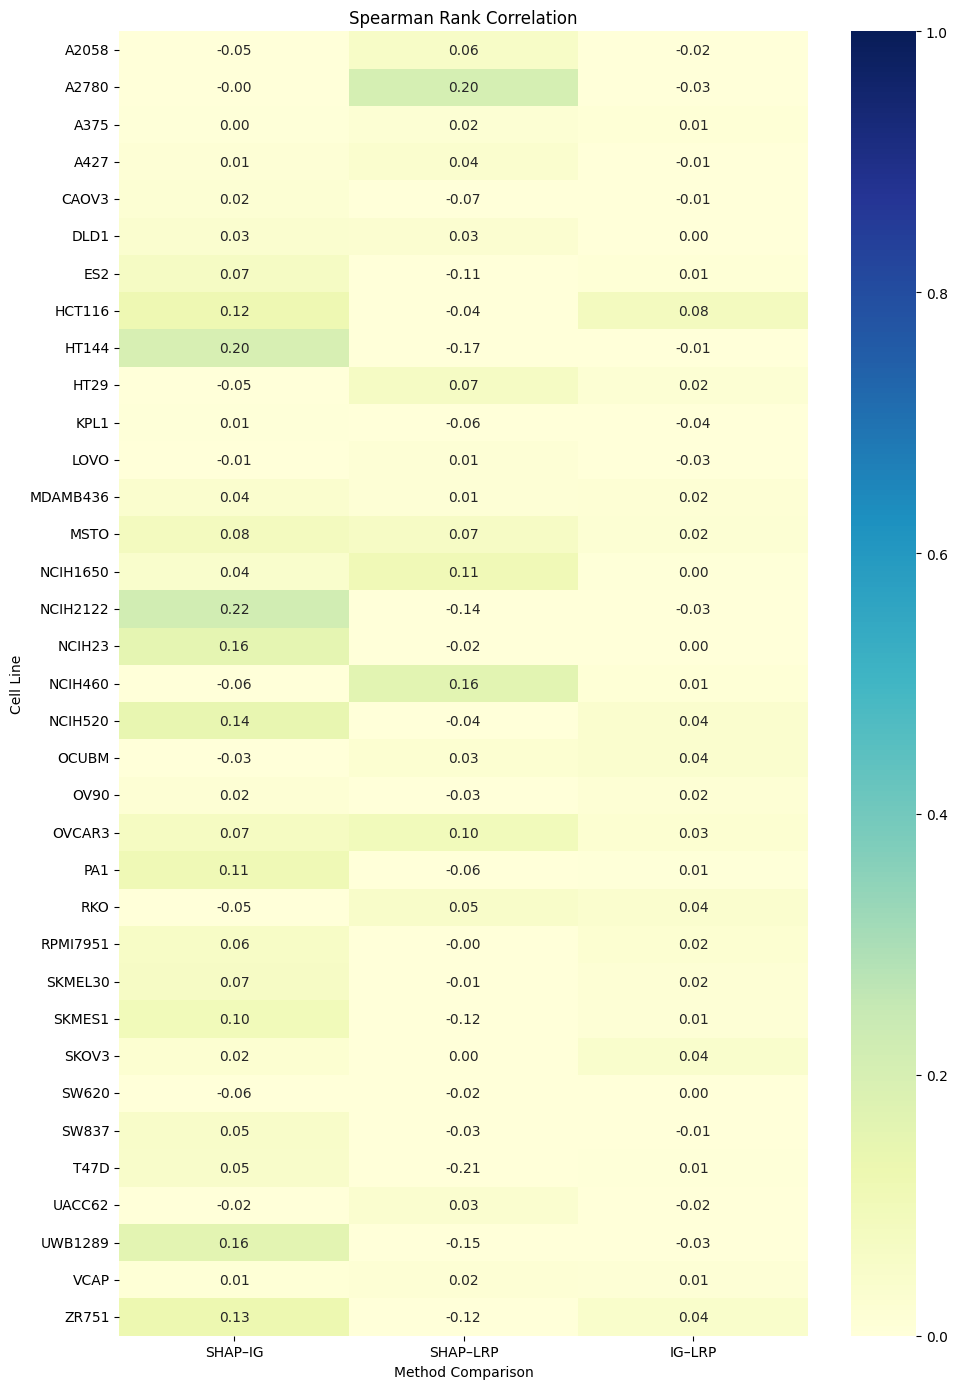

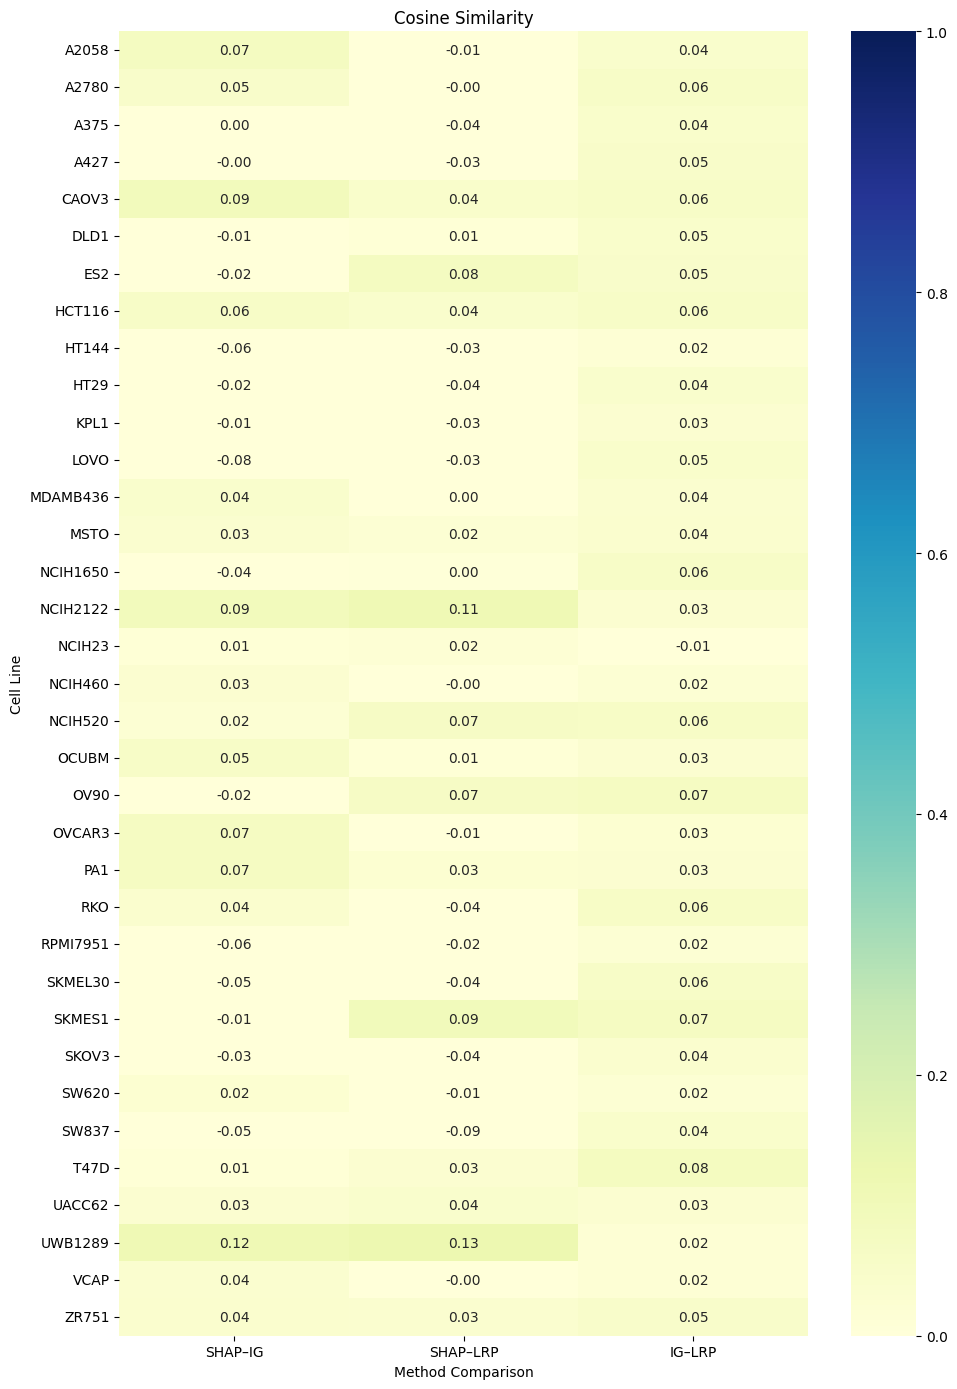

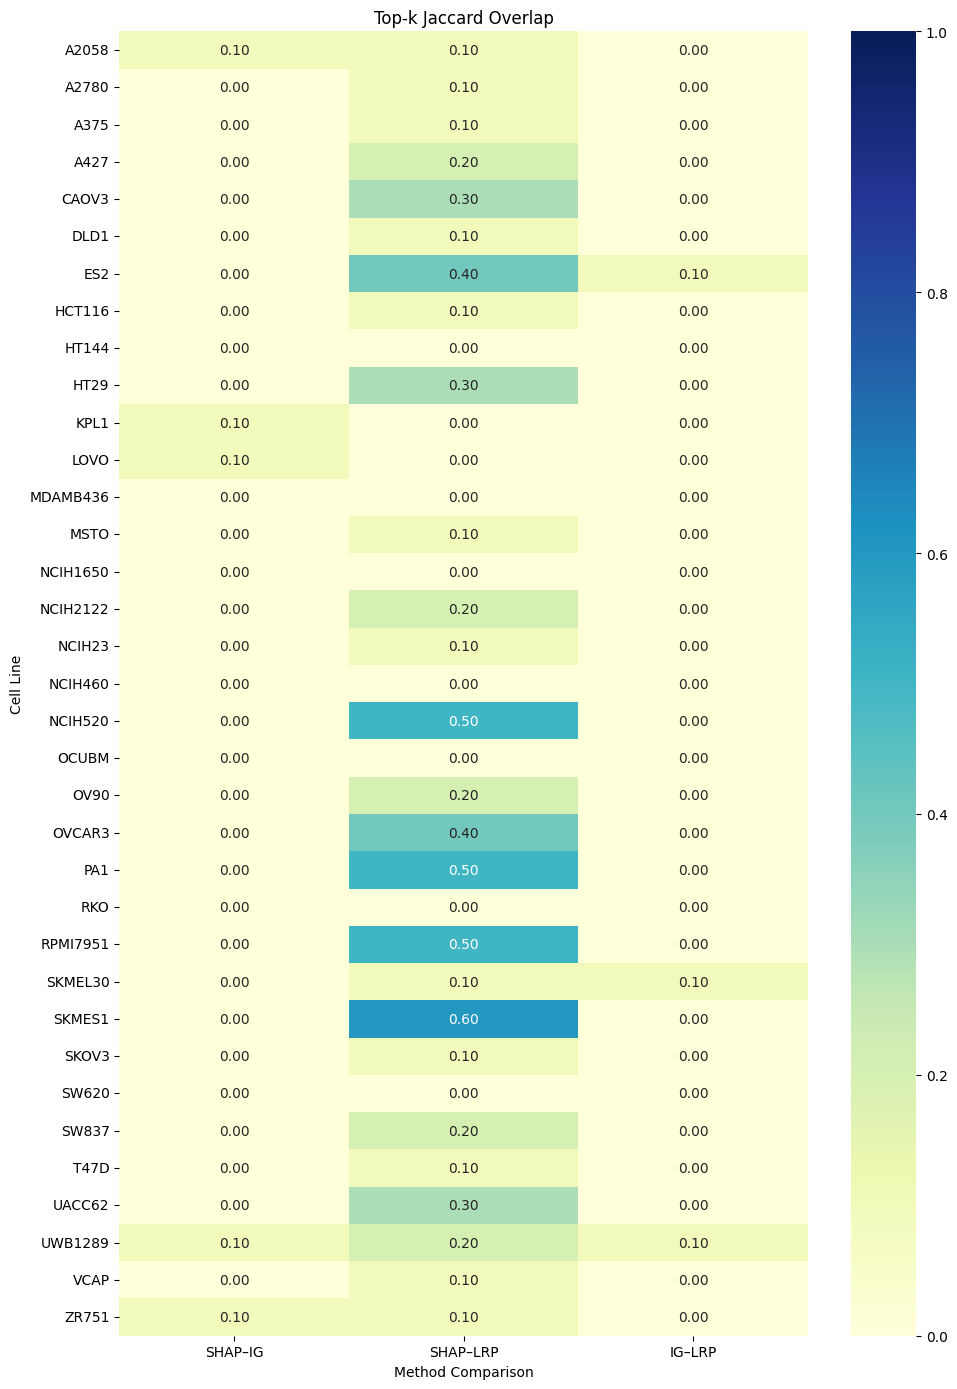

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity_heatmaps(similarity_df):
    cell_lines = similarity_df["cell_line"]
    metric_map = {
        "Spearman Rank Correlation": ["spearman_shap_ig", "spearman_shap_lrp", "spearman_ig_lrp"],
        "Cosine Similarity": ["cosine_shap_ig", "cosine_shap_lrp", "cosine_ig_lrp"],
        "Top-k Jaccard Overlap": ["jaccard_shap_ig", "jaccard_shap_lrp", "jaccard_ig_lrp"],
    }

    for title, cols in metric_map.items():
        data = similarity_df[cols]
        data.index = cell_lines
        data.columns = ["SHAP–IG", "SHAP–LRP", "IG–LRP"]
        plt.figure(figsize=(10, max(6, 0.4 * len(cell_lines))))
        sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1, cbar=True)
        plt.title(title)
        plt.xlabel("Method Comparison")
        plt.ylabel("Cell Line")
        plt.tight_layout()
        plt.show()

plot_similarity_heatmaps(similarity_df)



[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


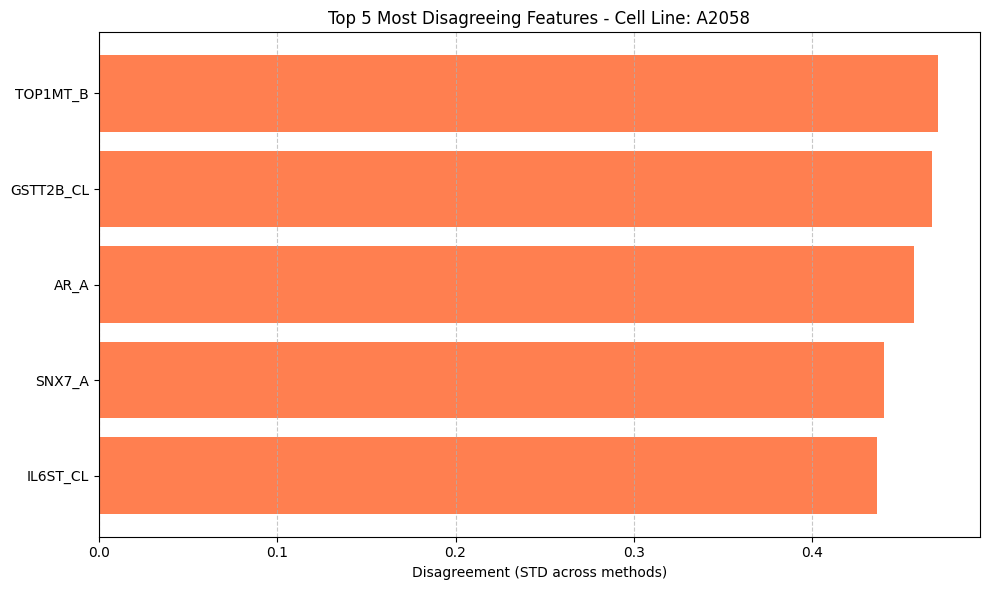

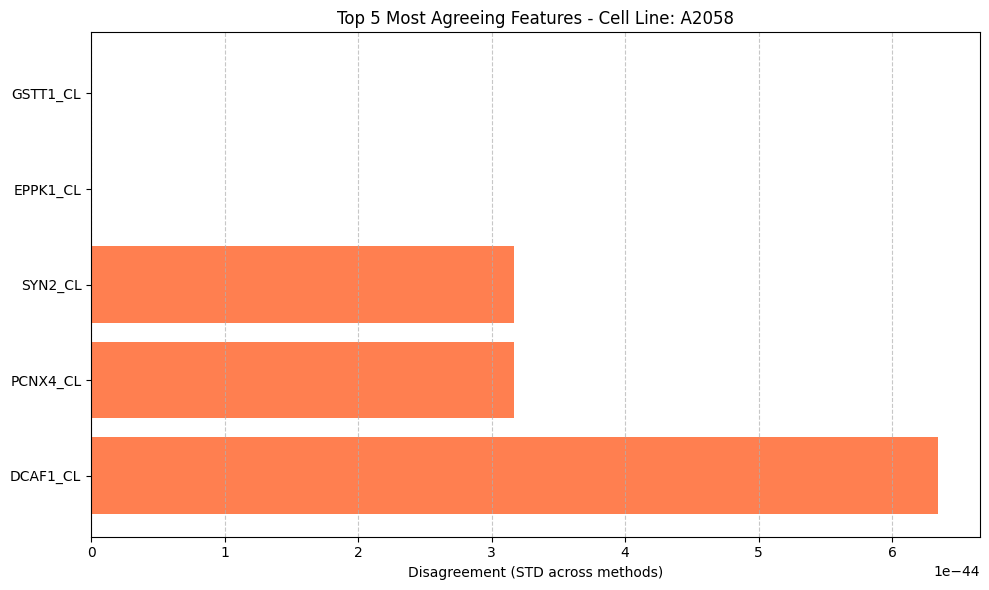

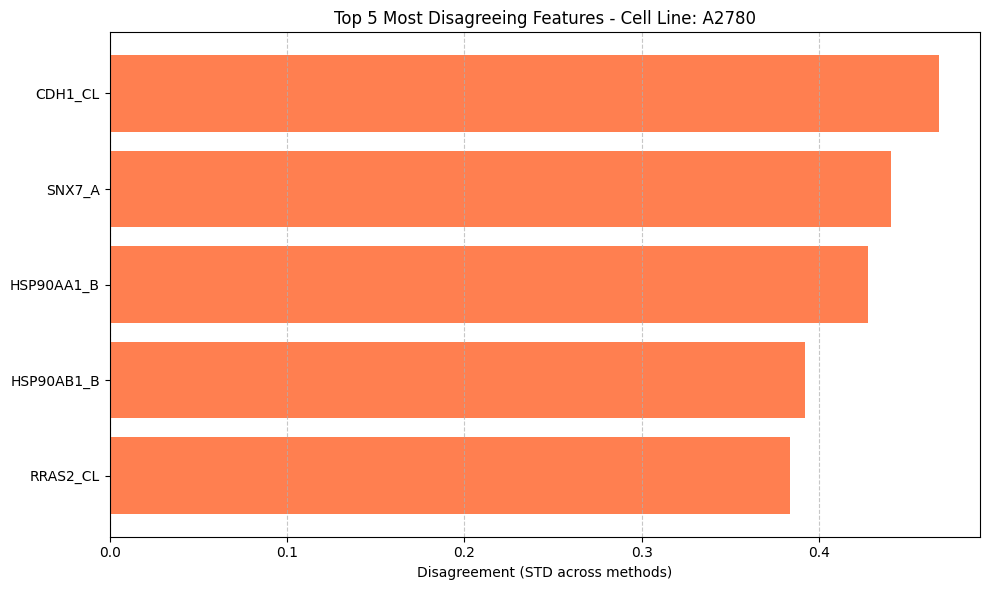

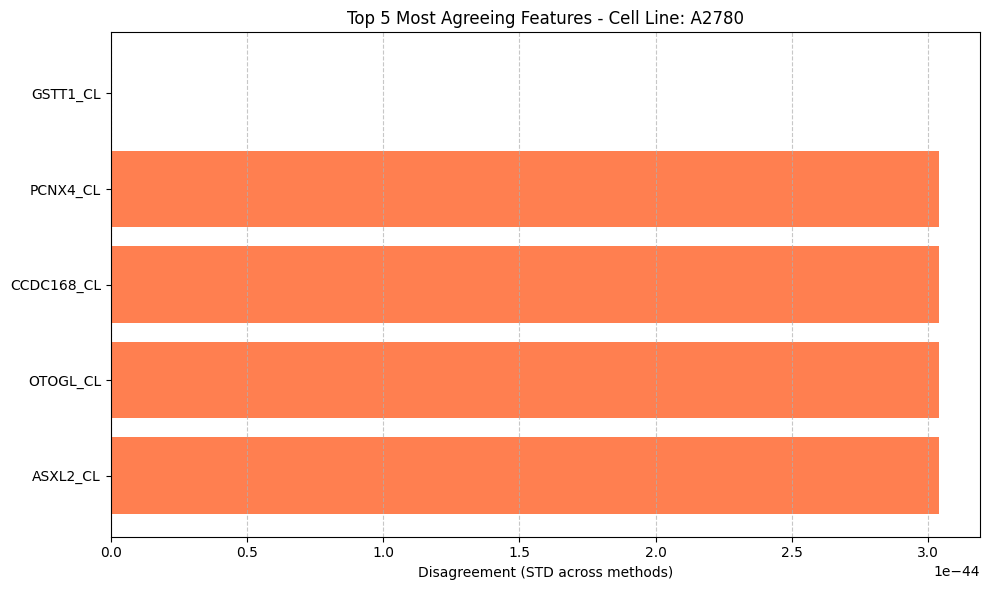

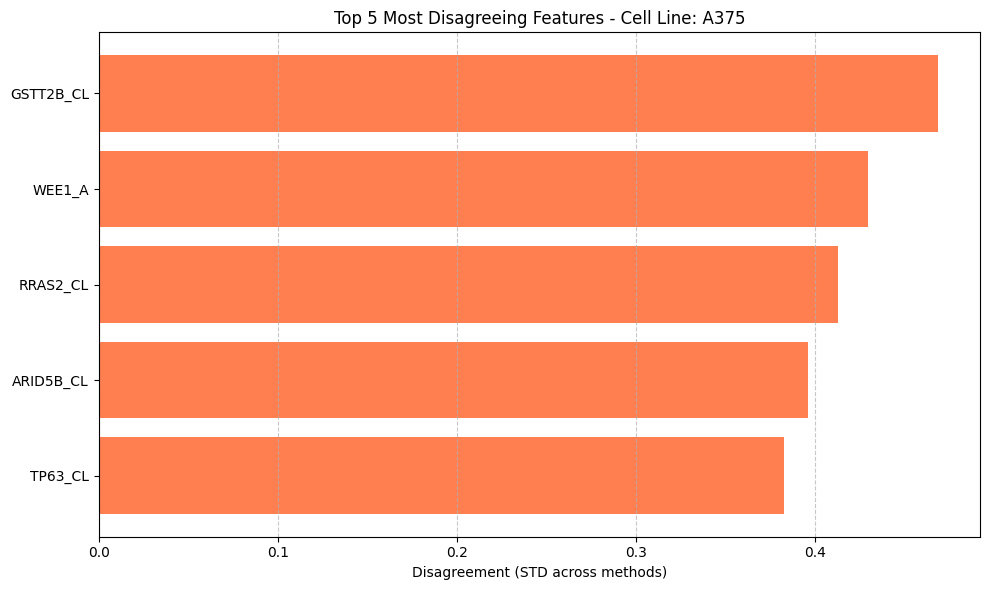

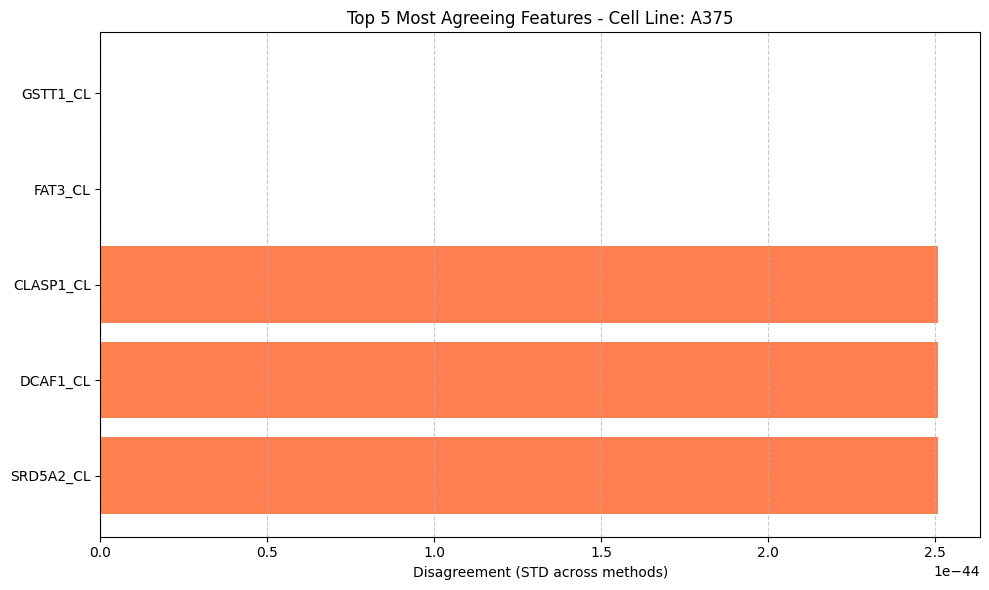

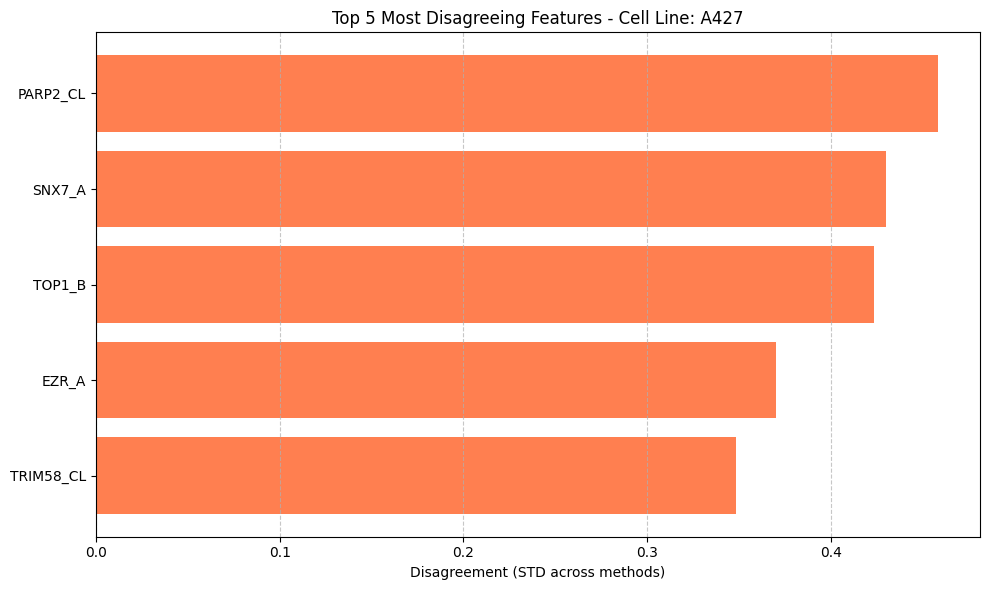

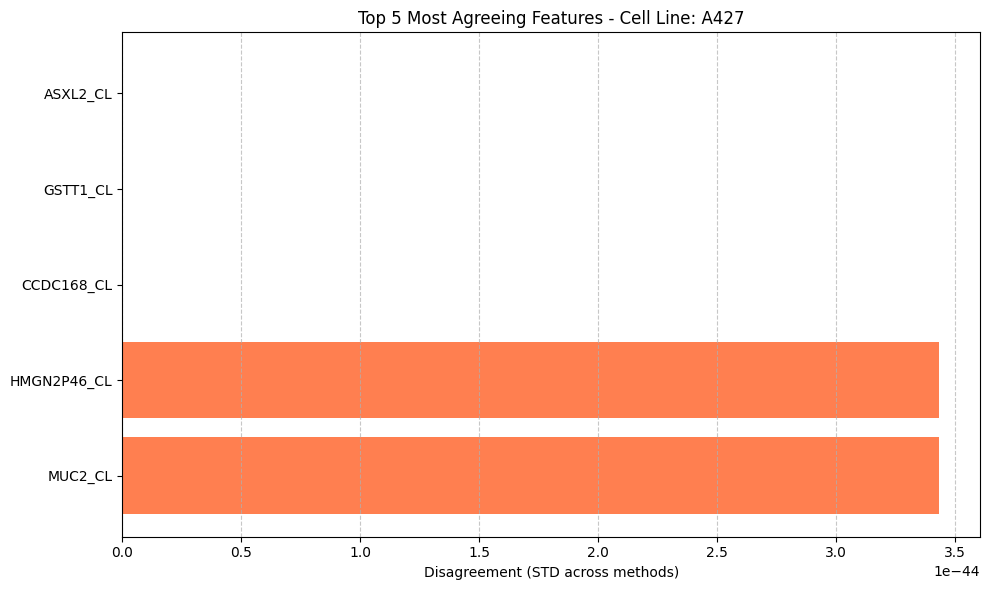

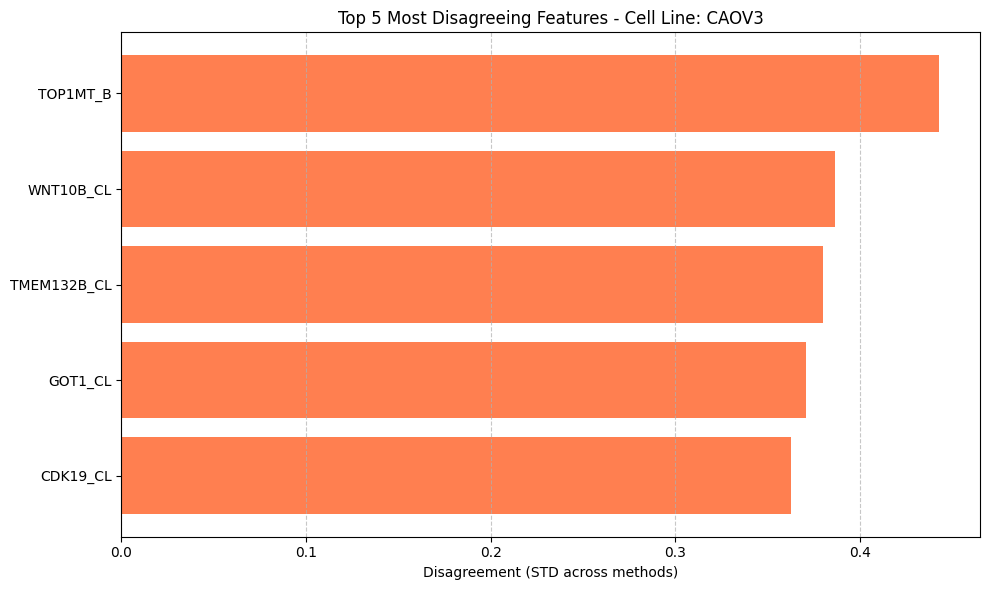

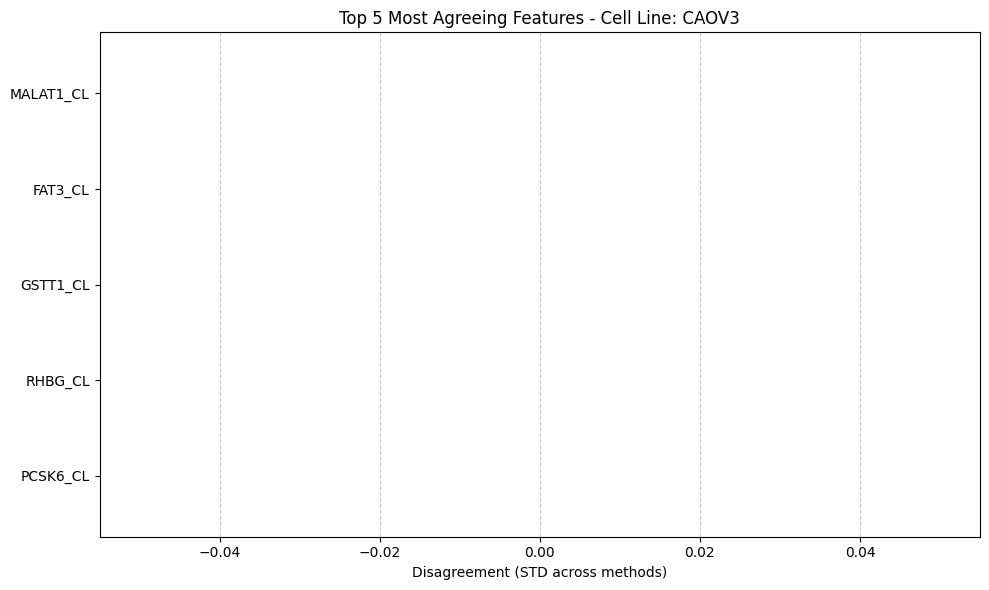

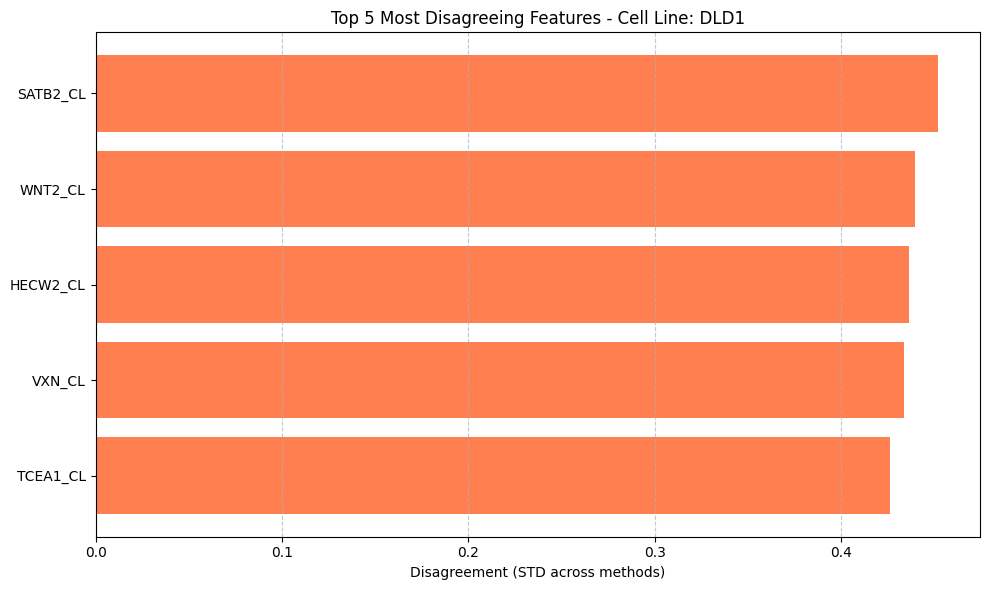

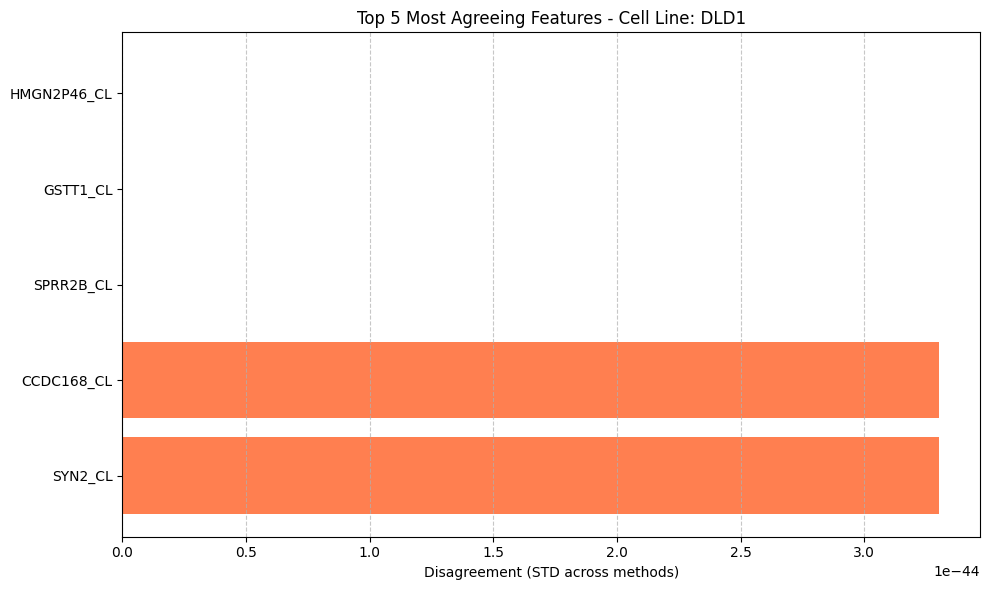

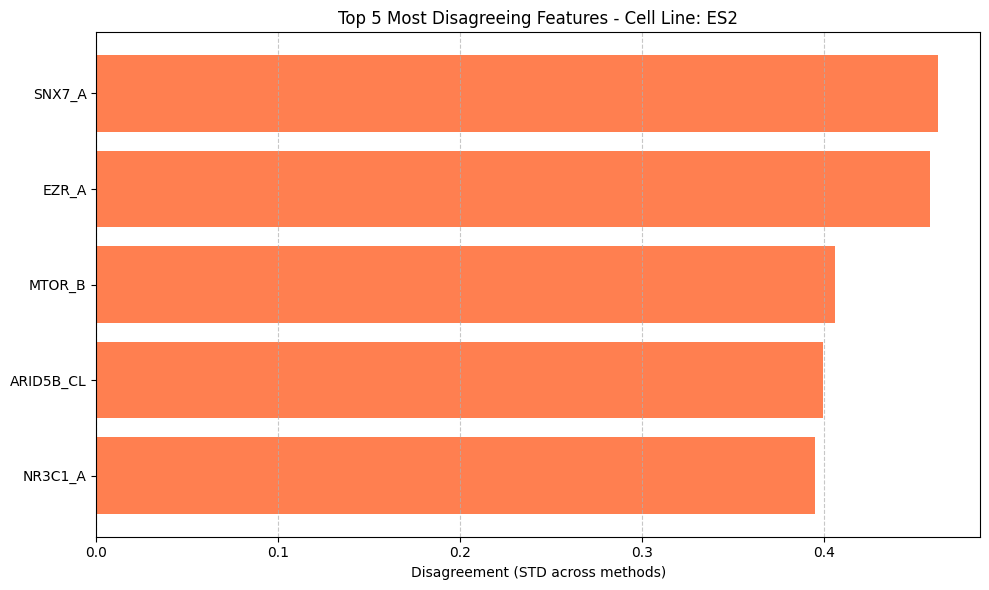

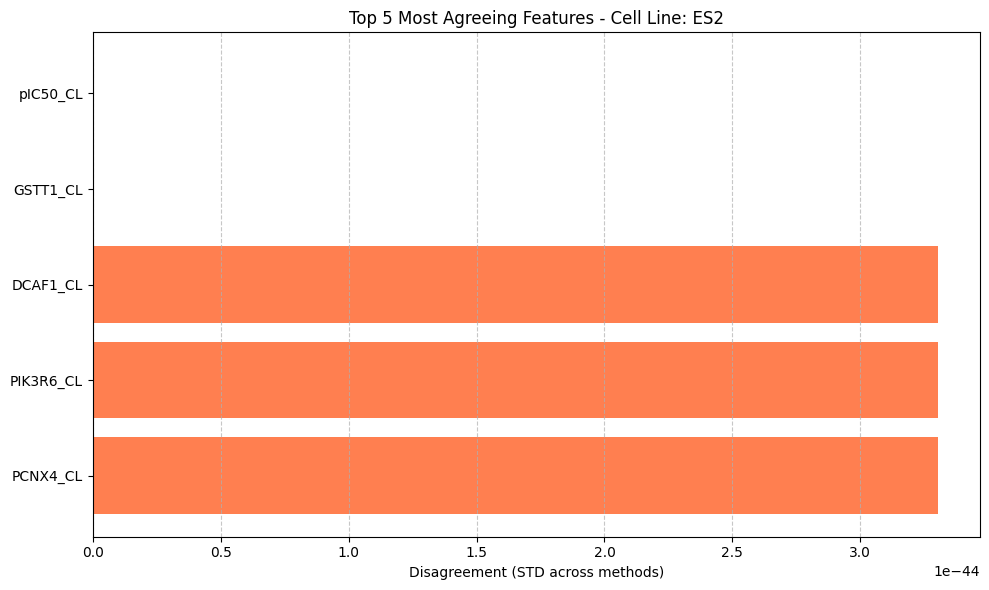

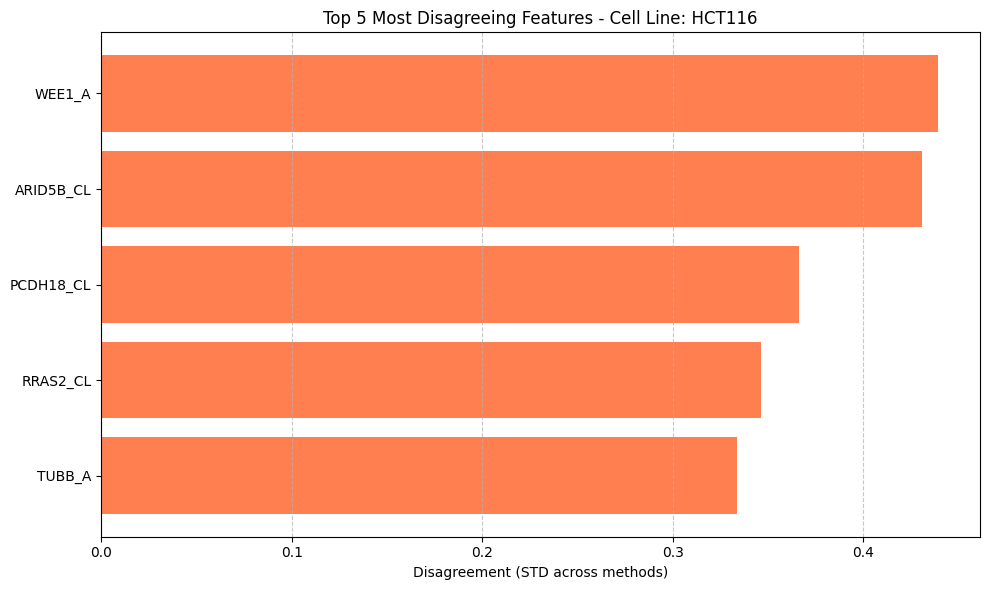

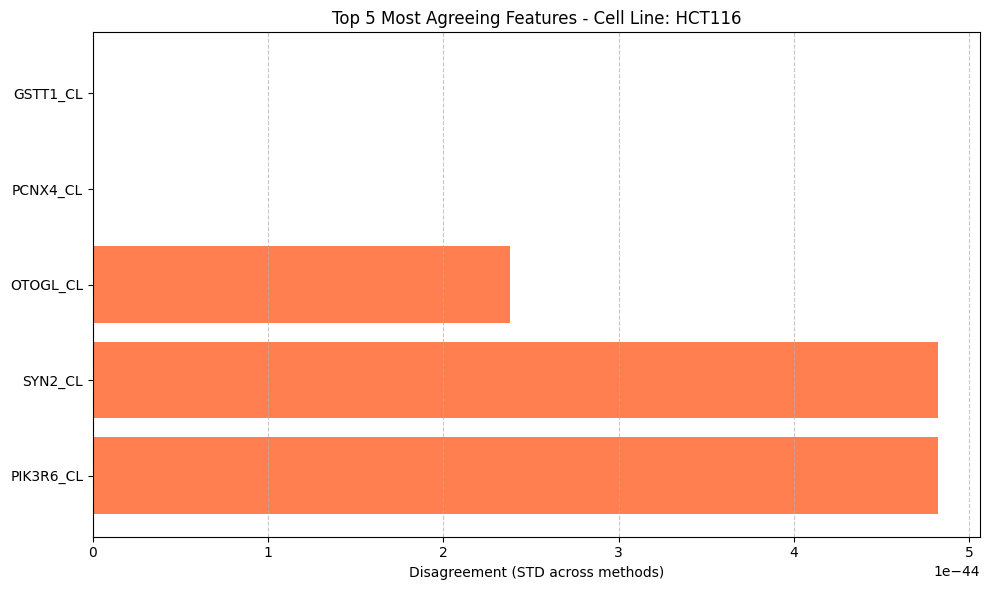

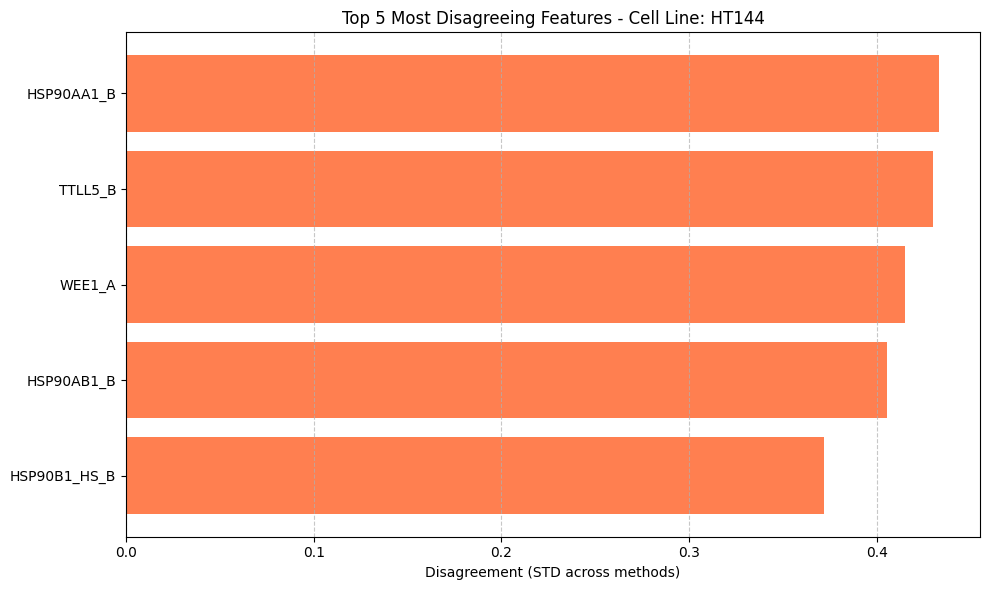

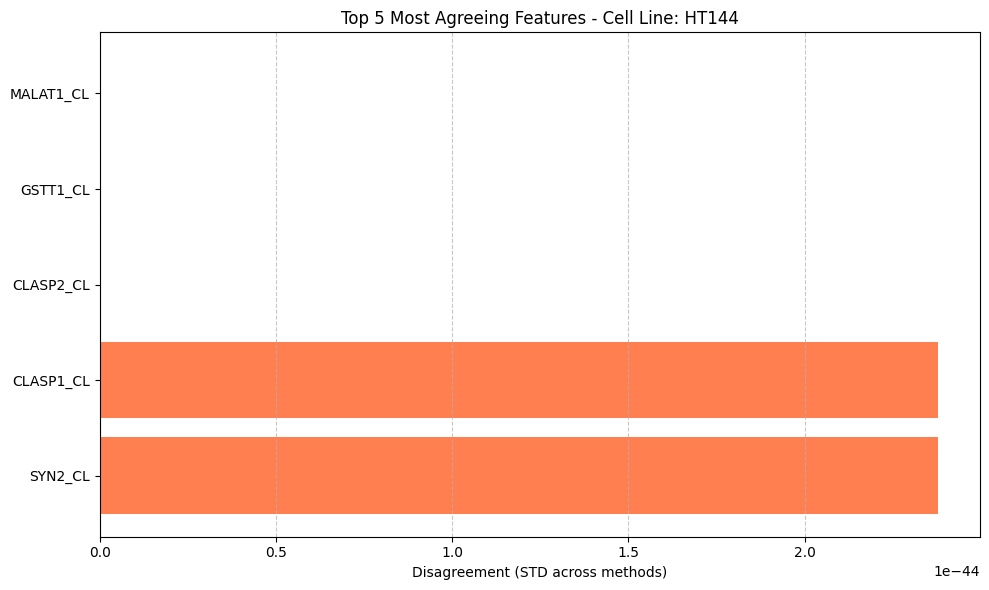

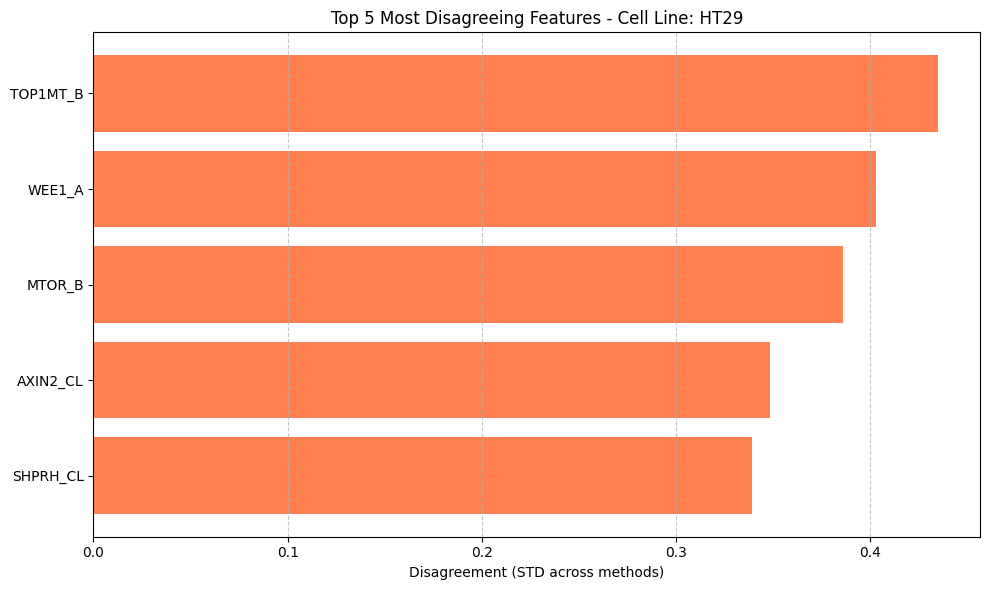

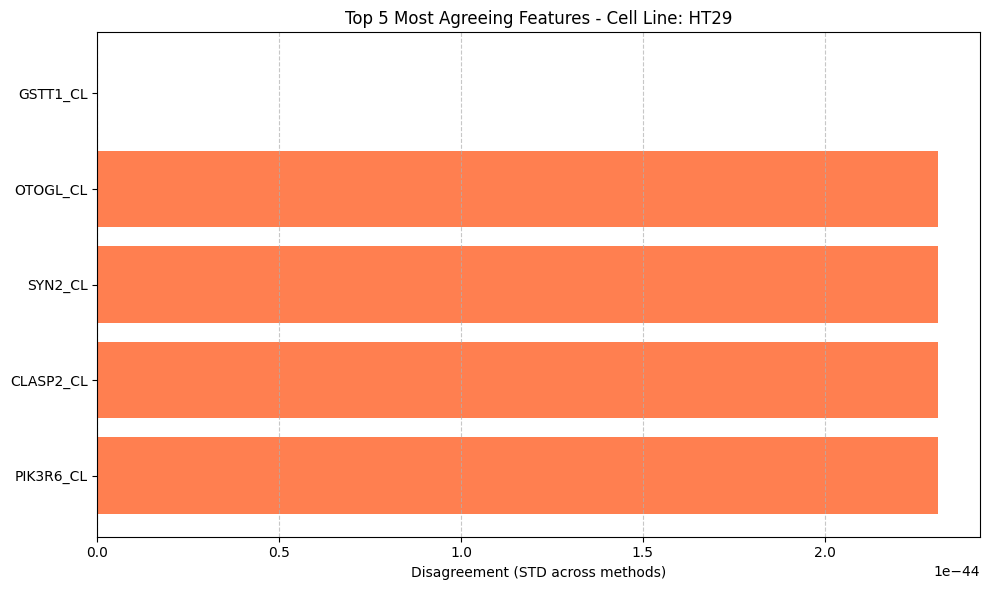

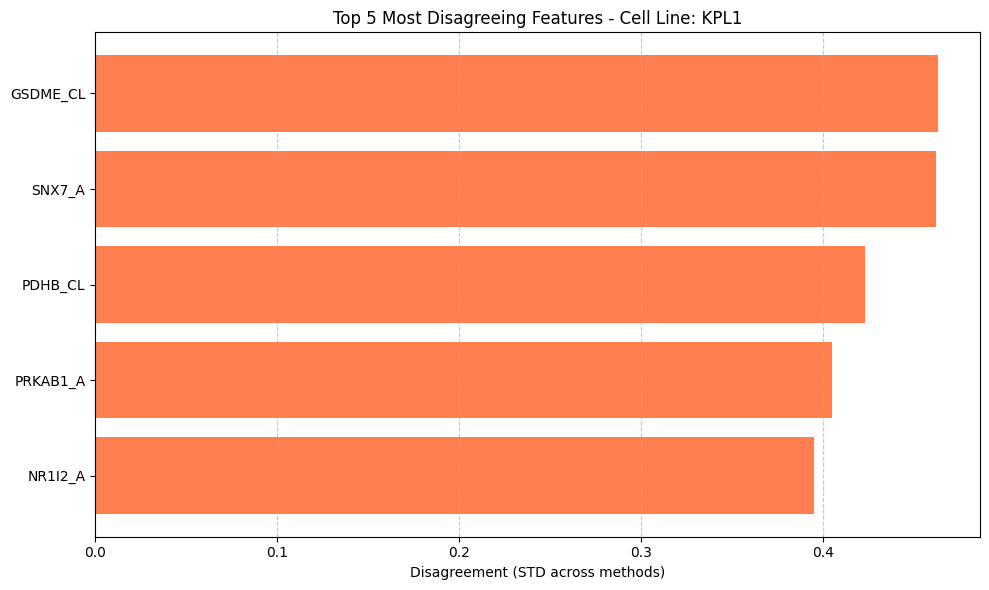

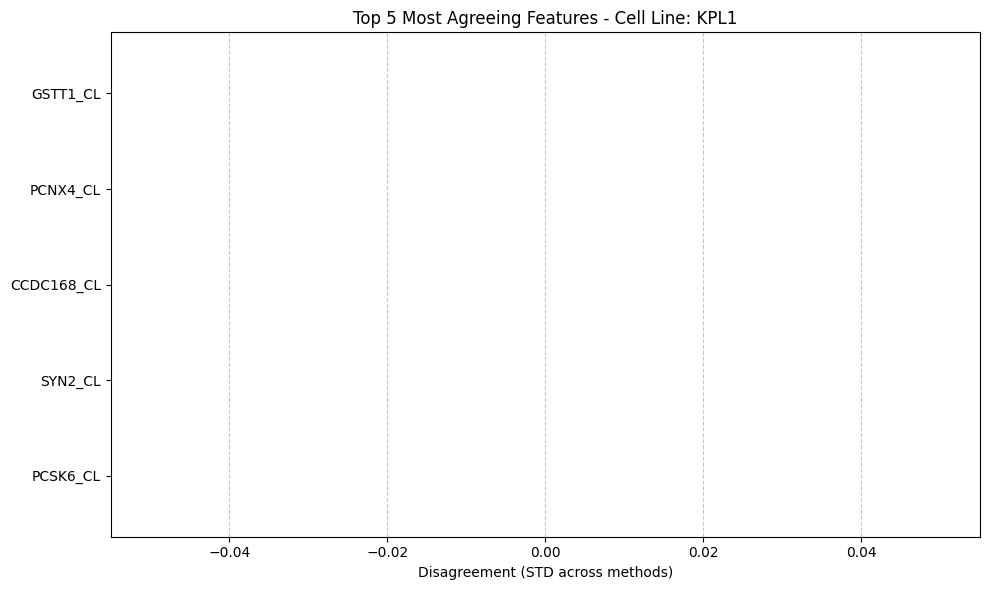

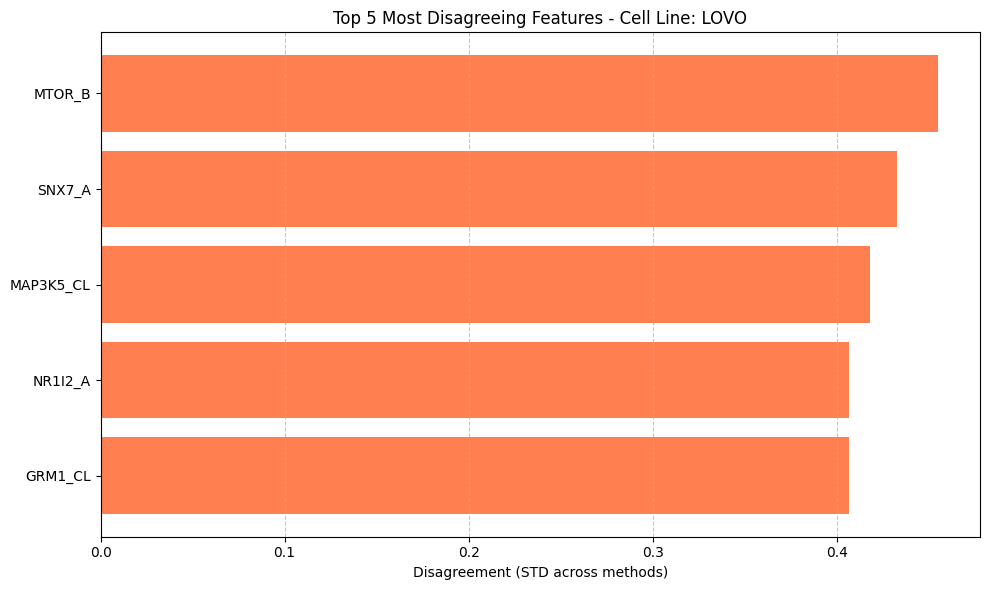

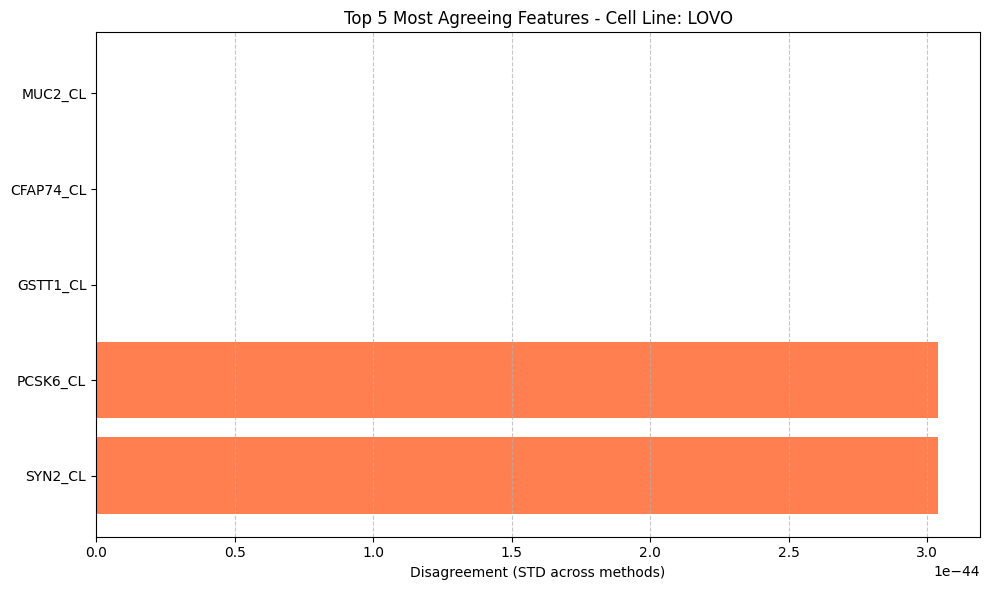

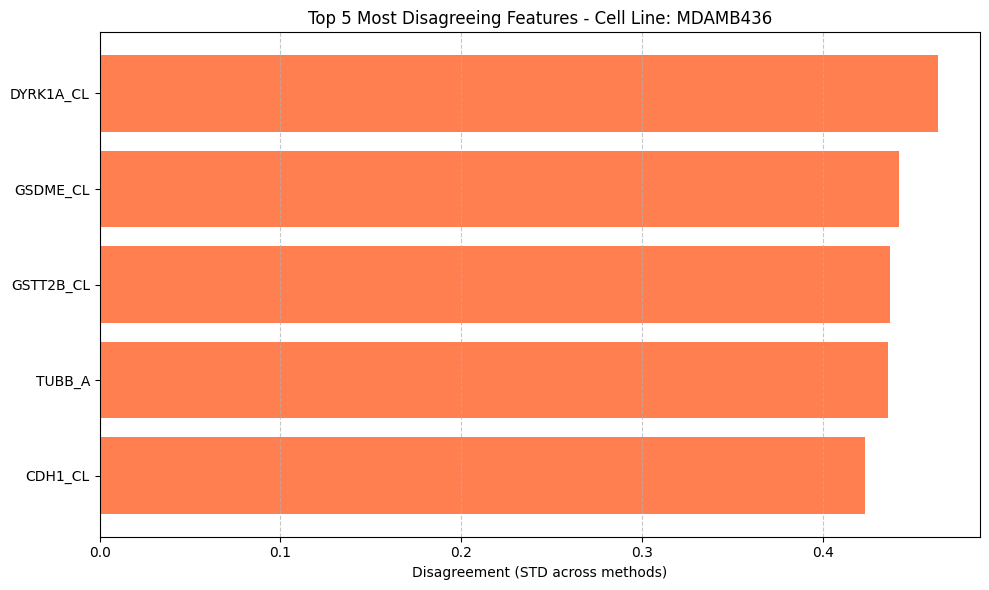

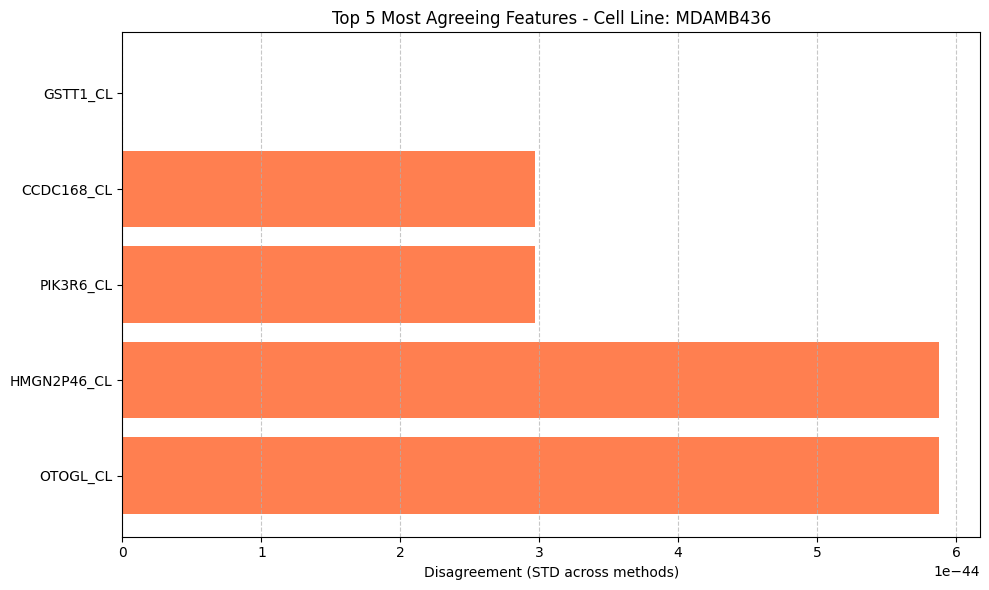

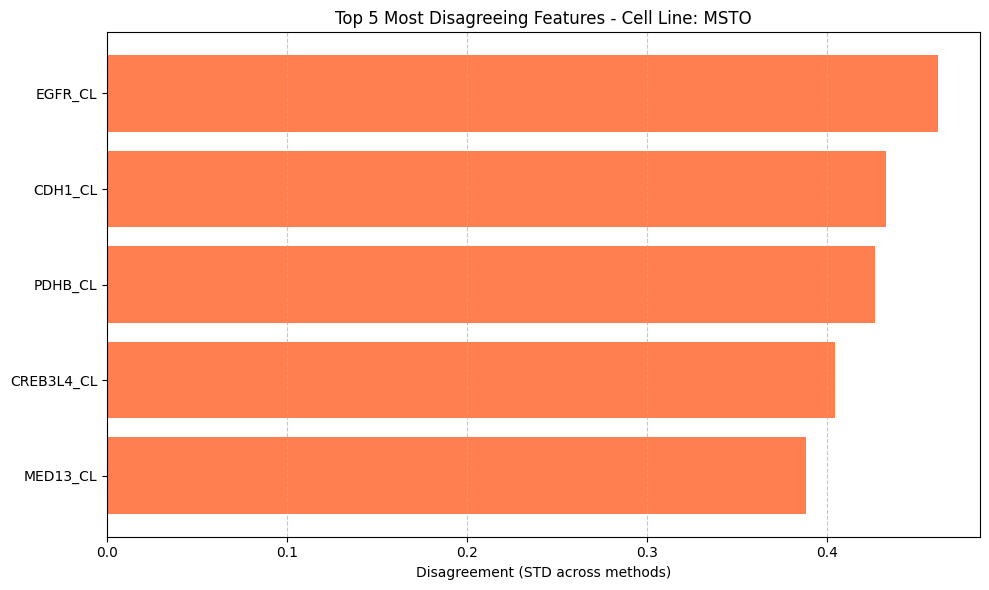

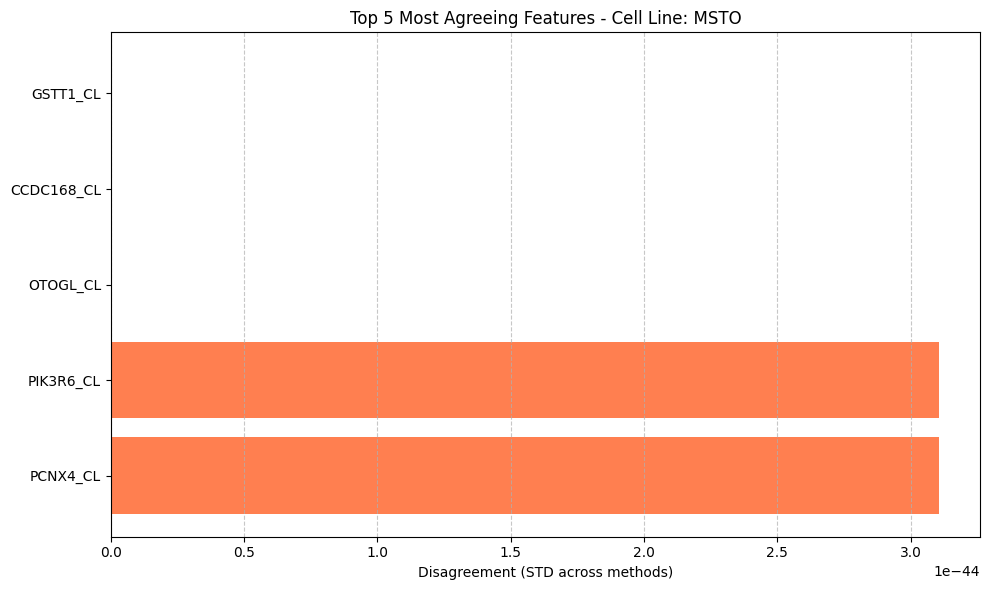

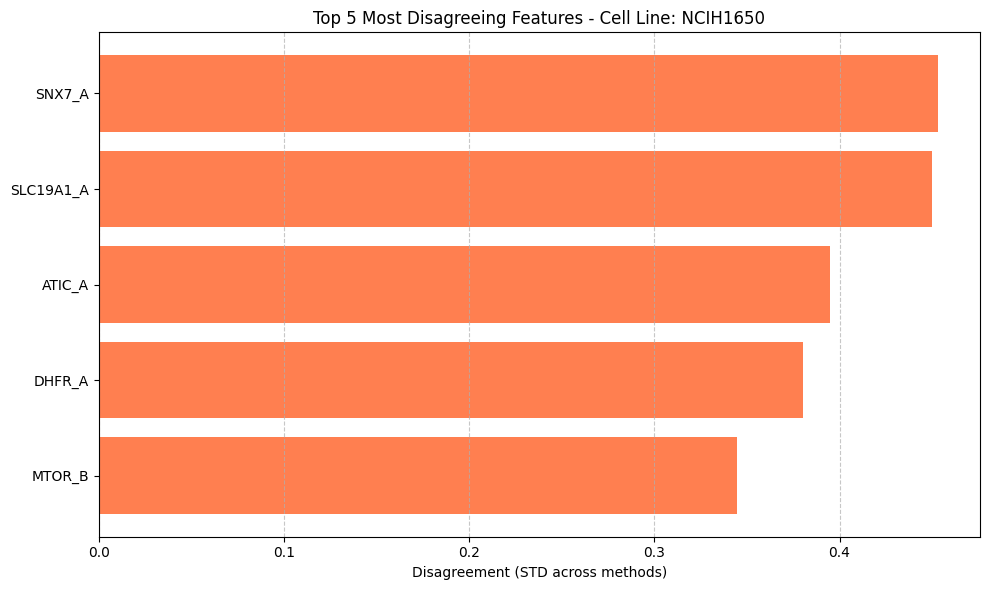

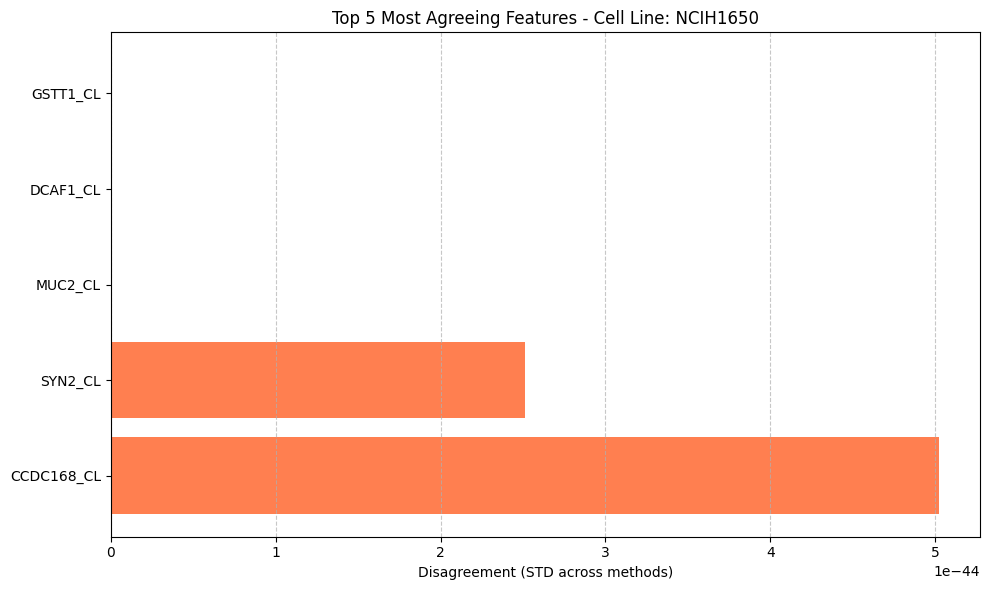

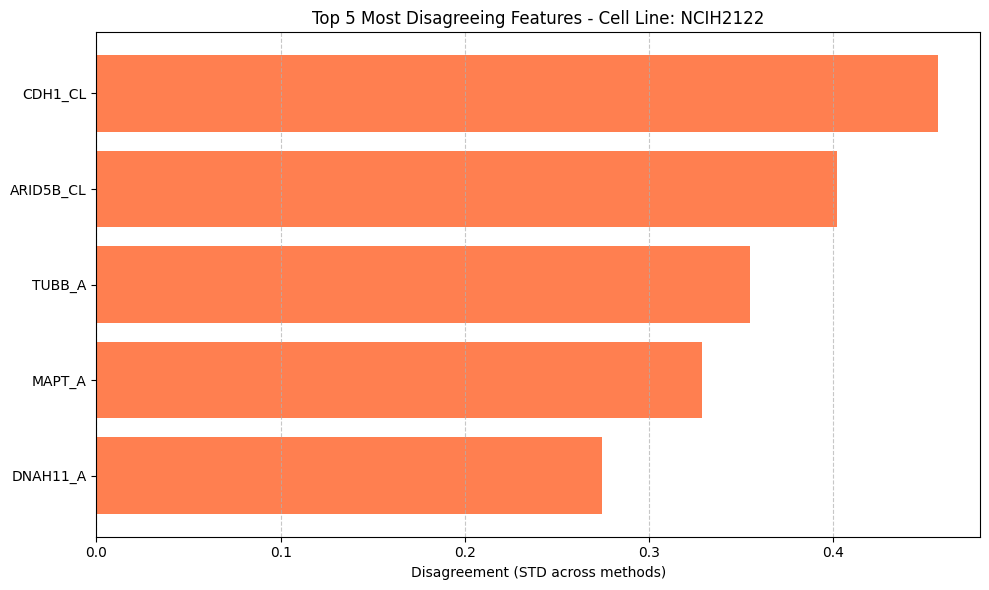

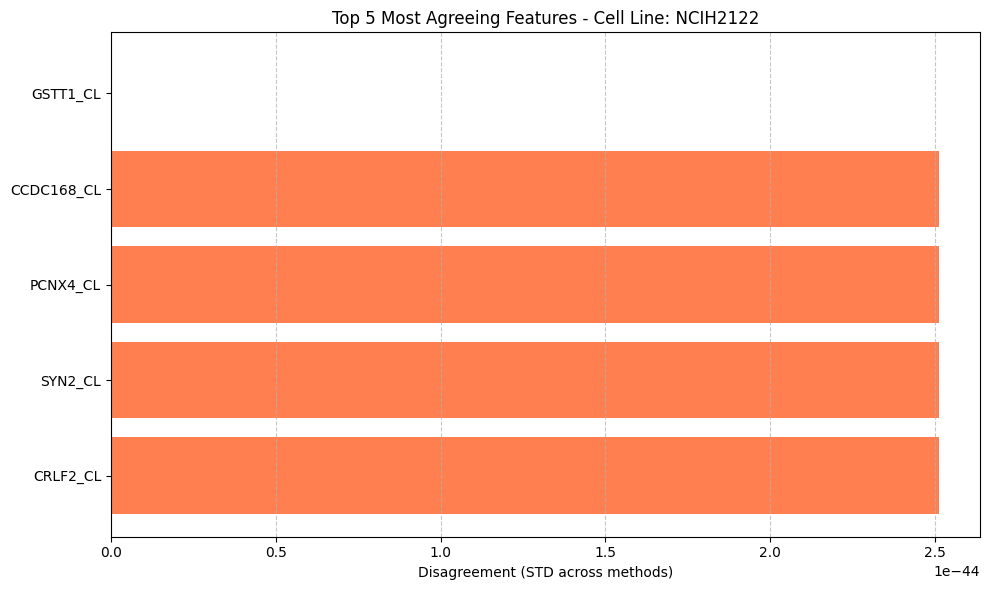

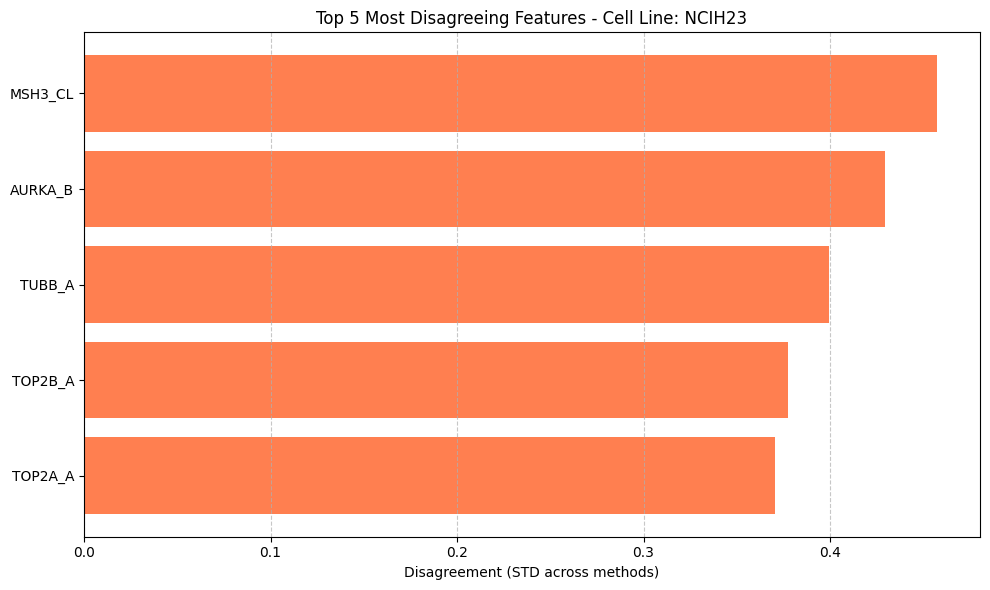

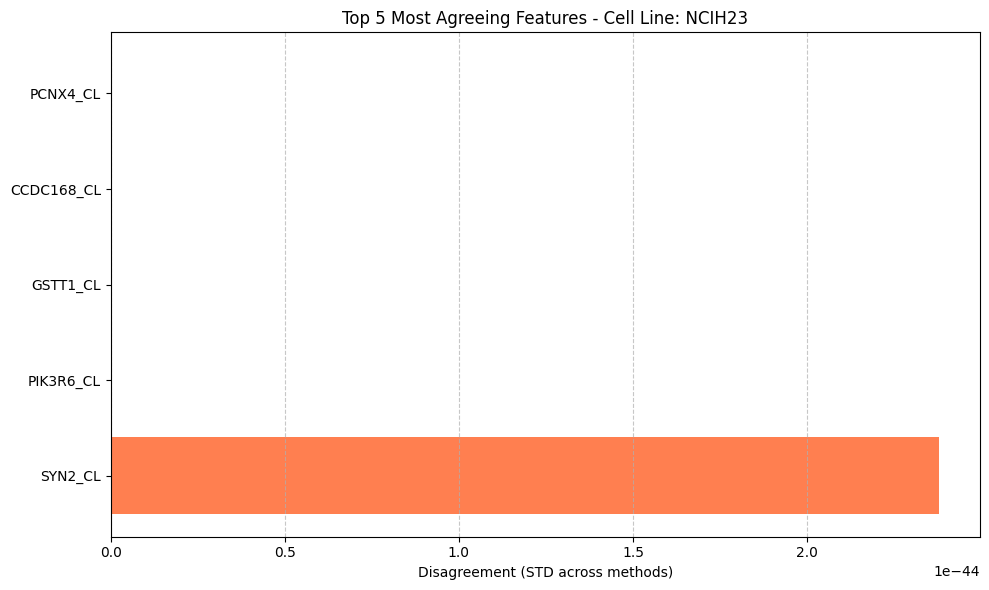

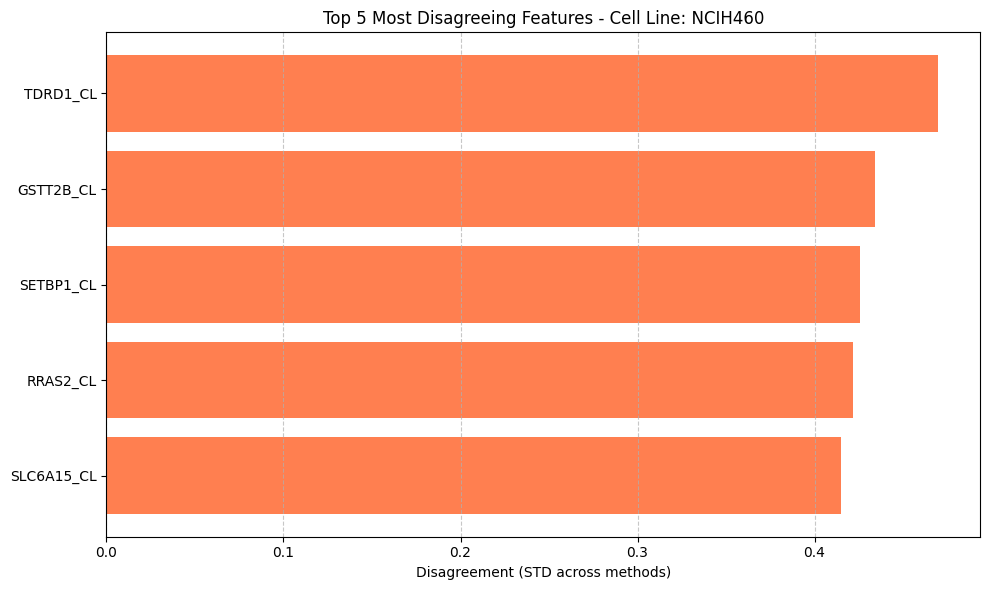

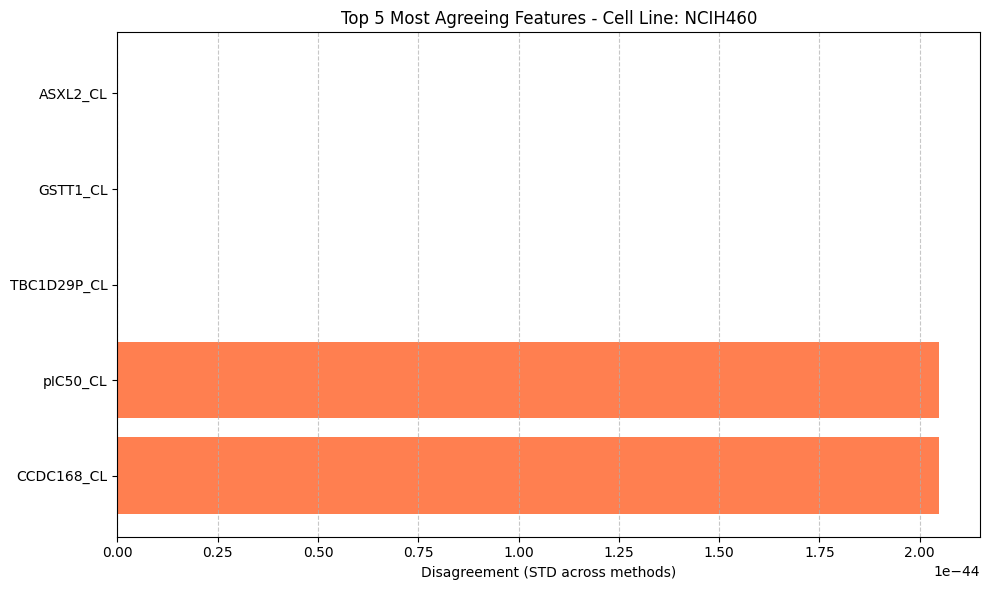

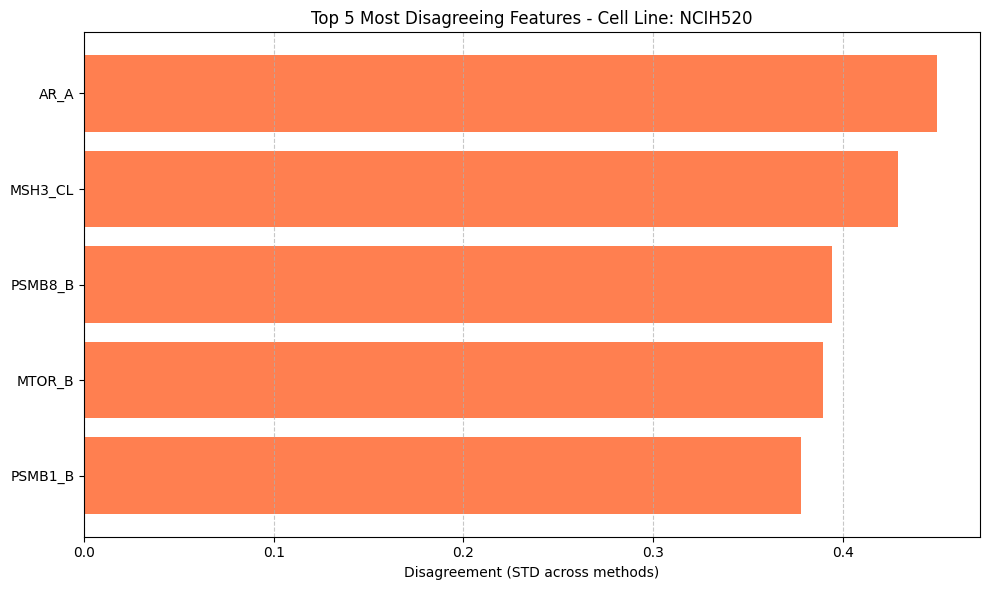

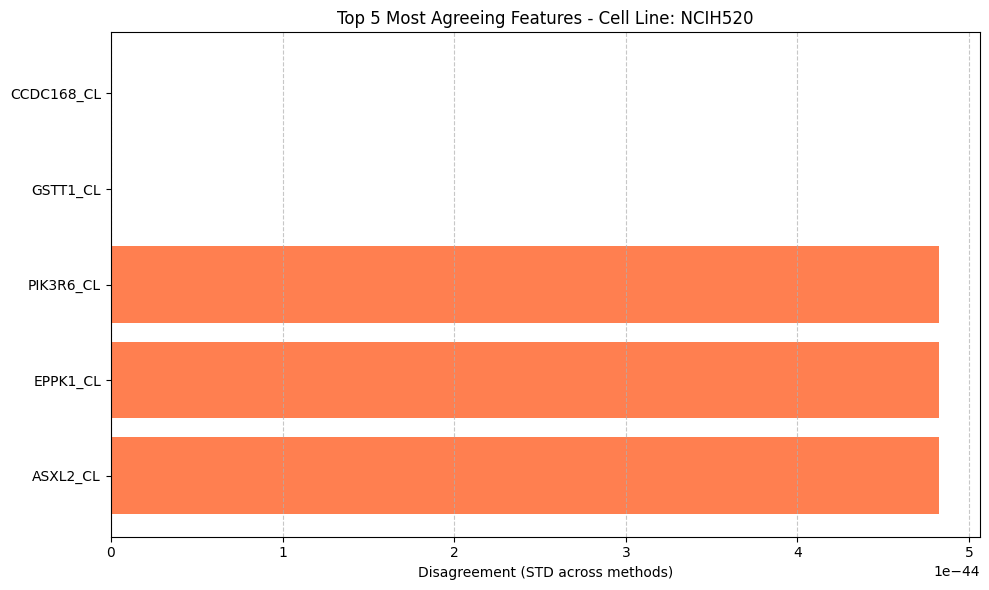

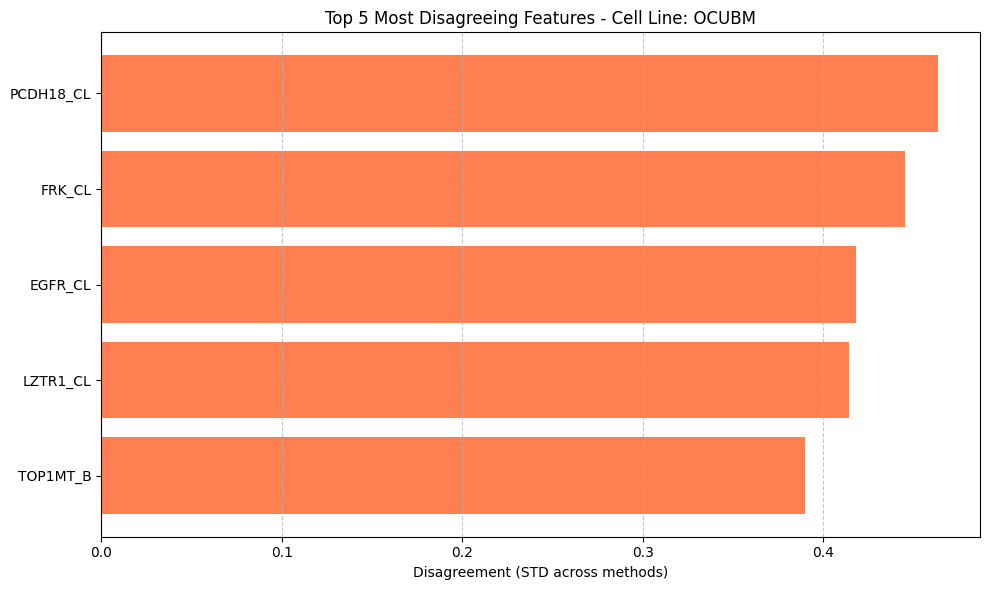

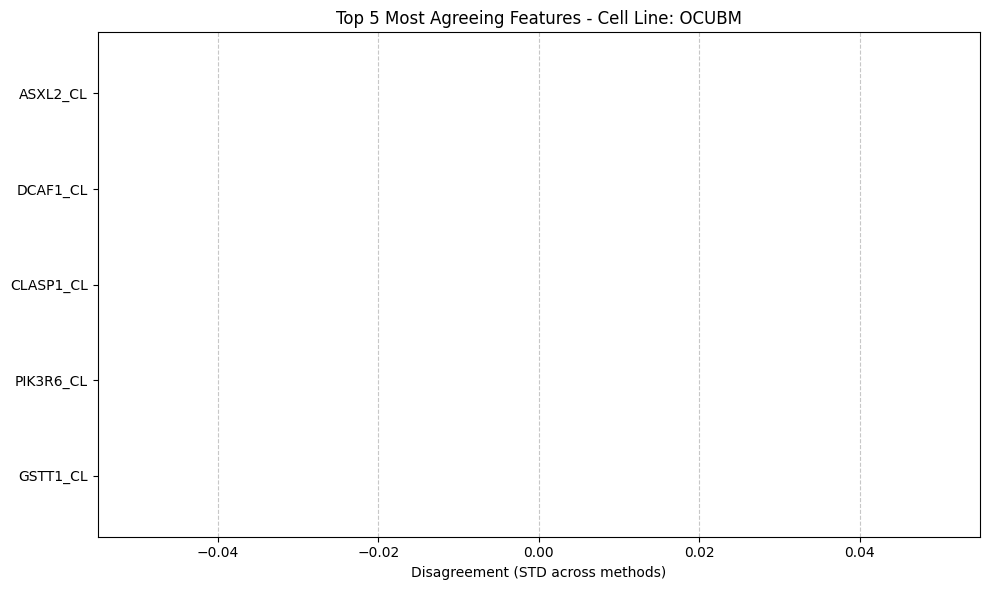

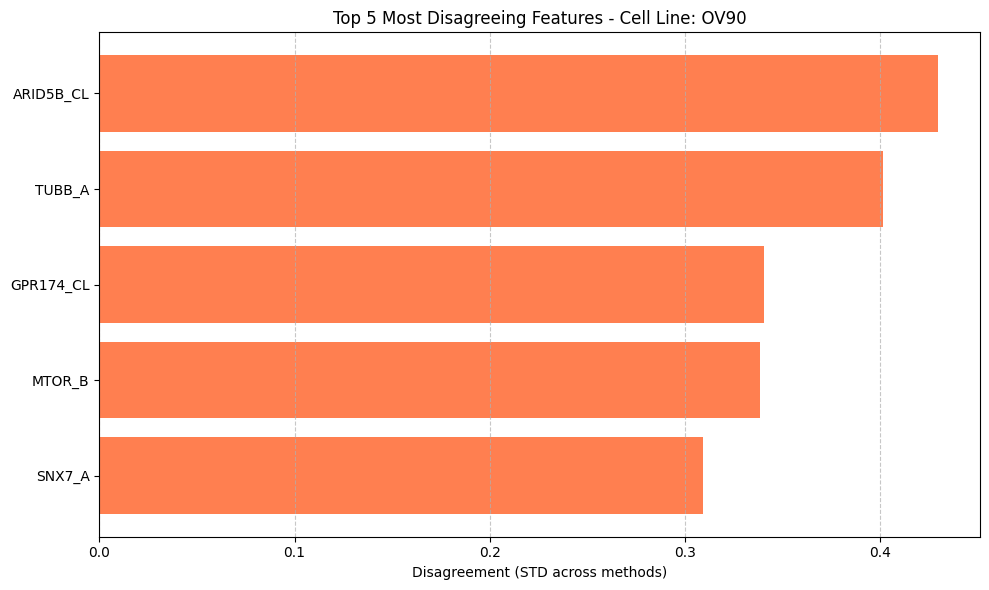

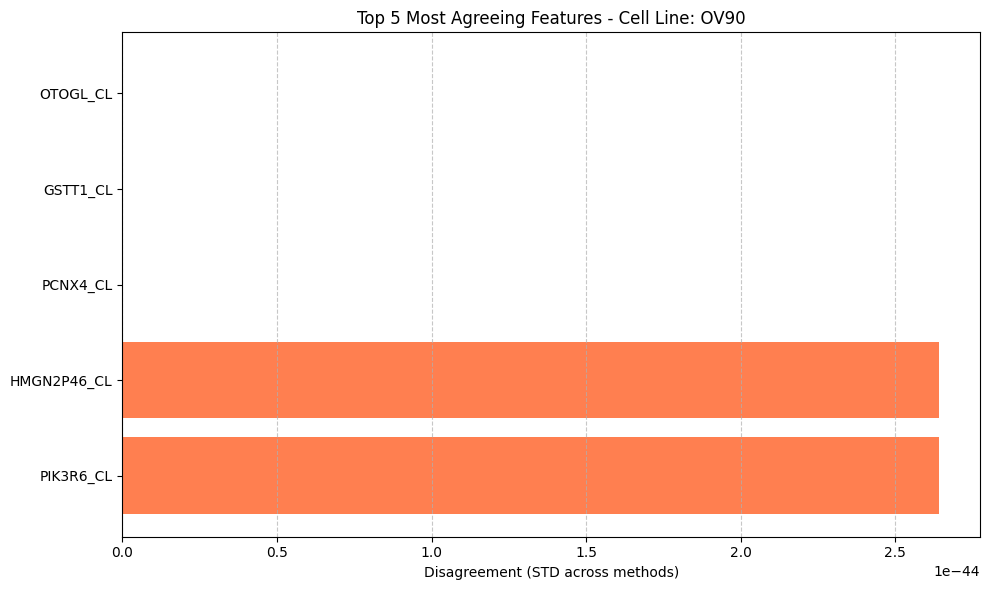

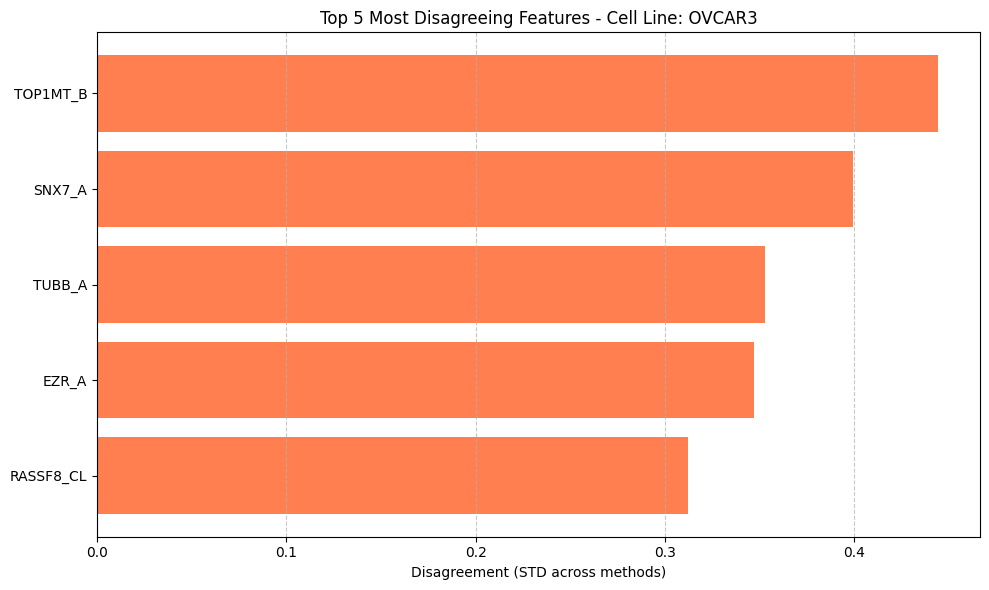

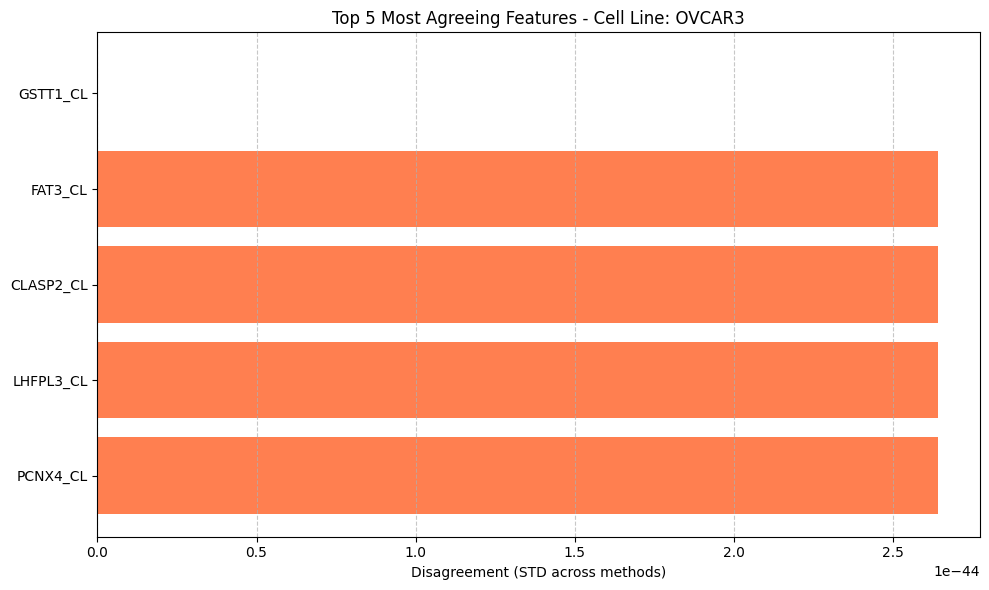

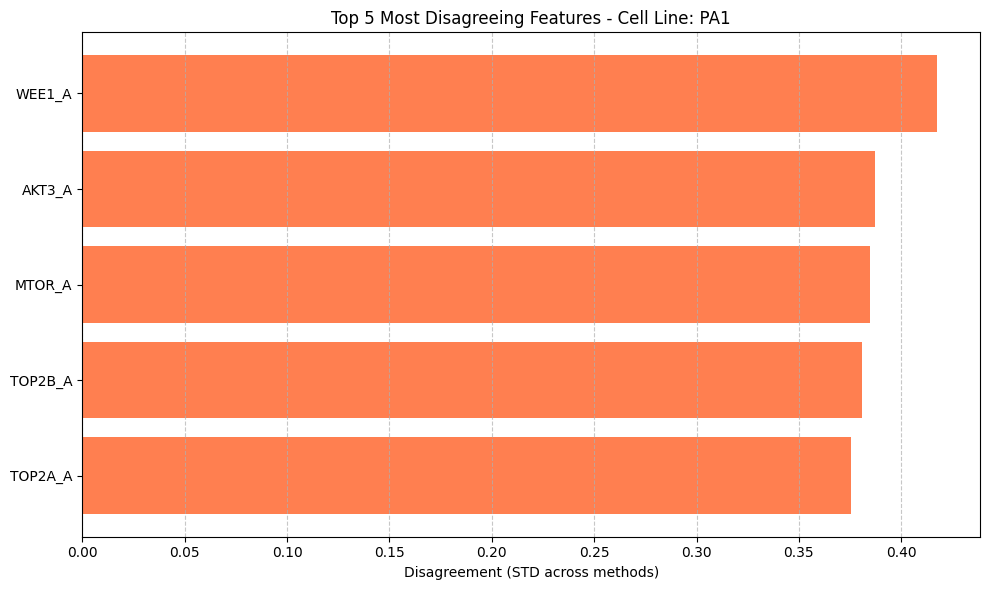

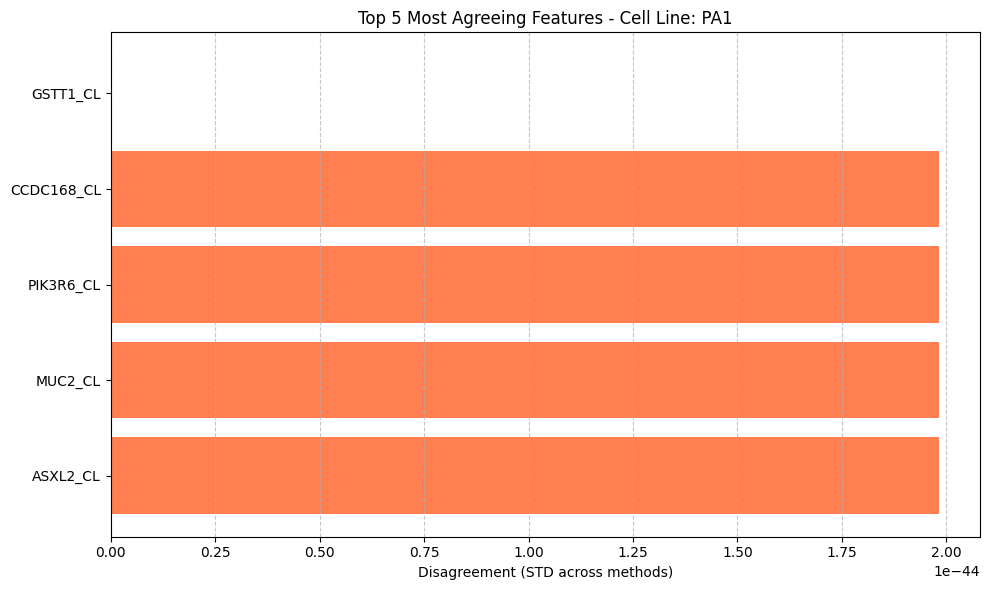

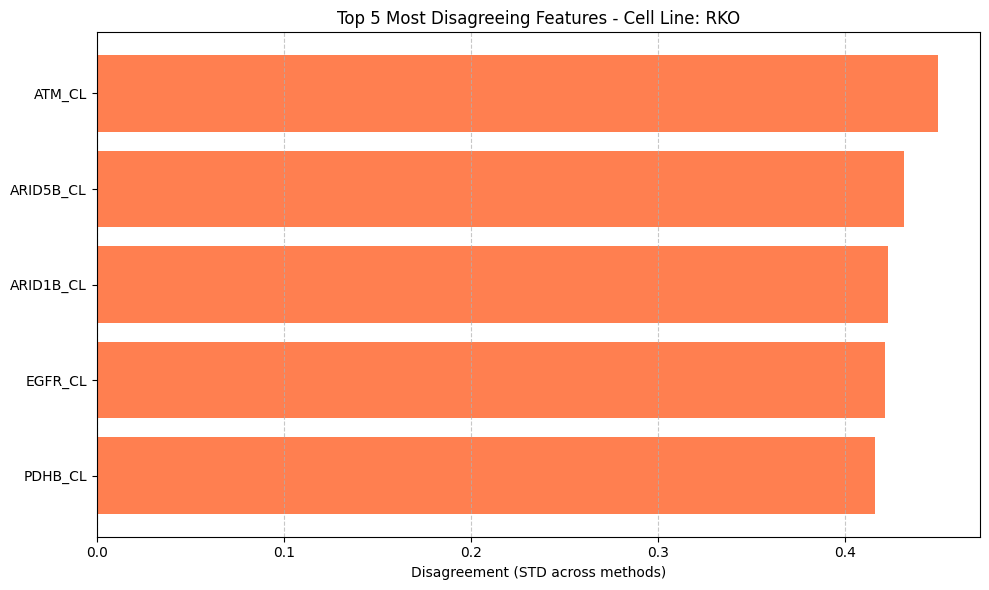

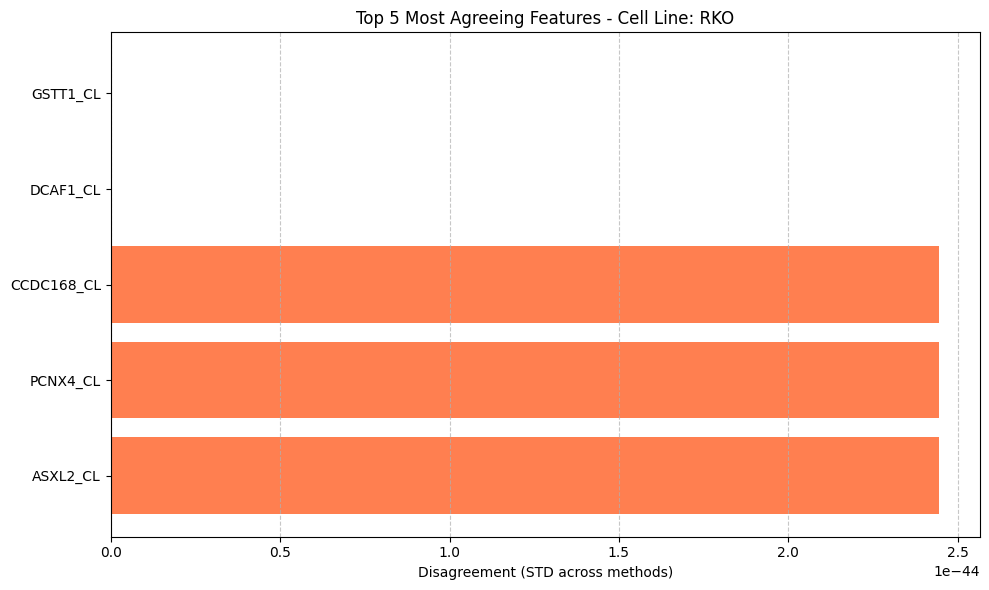

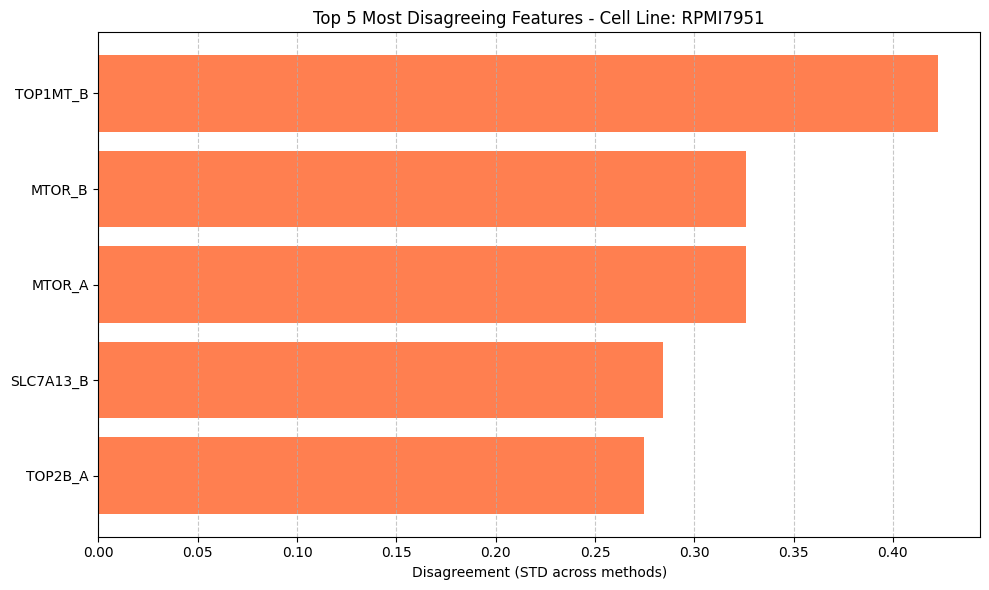

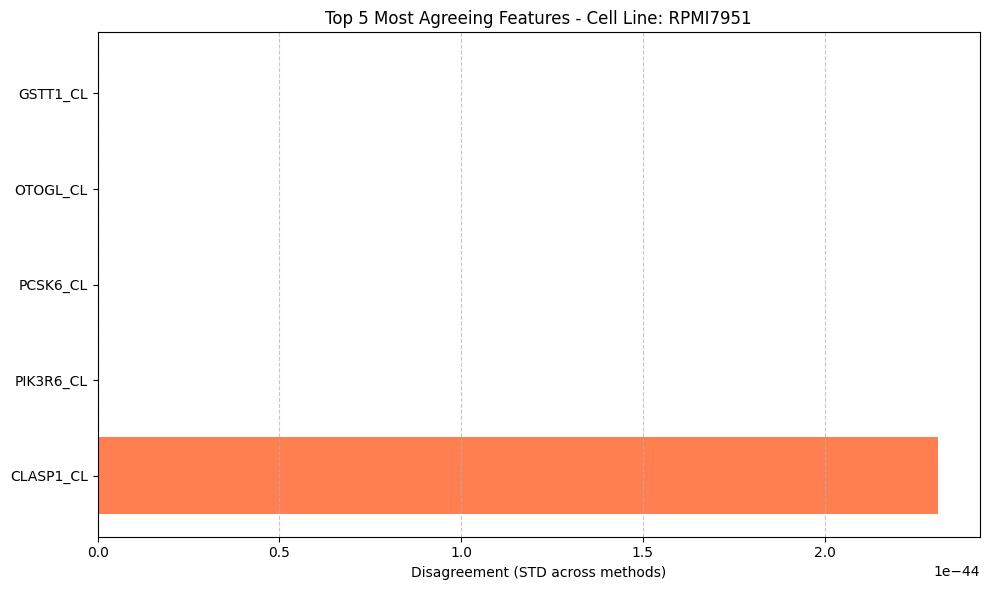

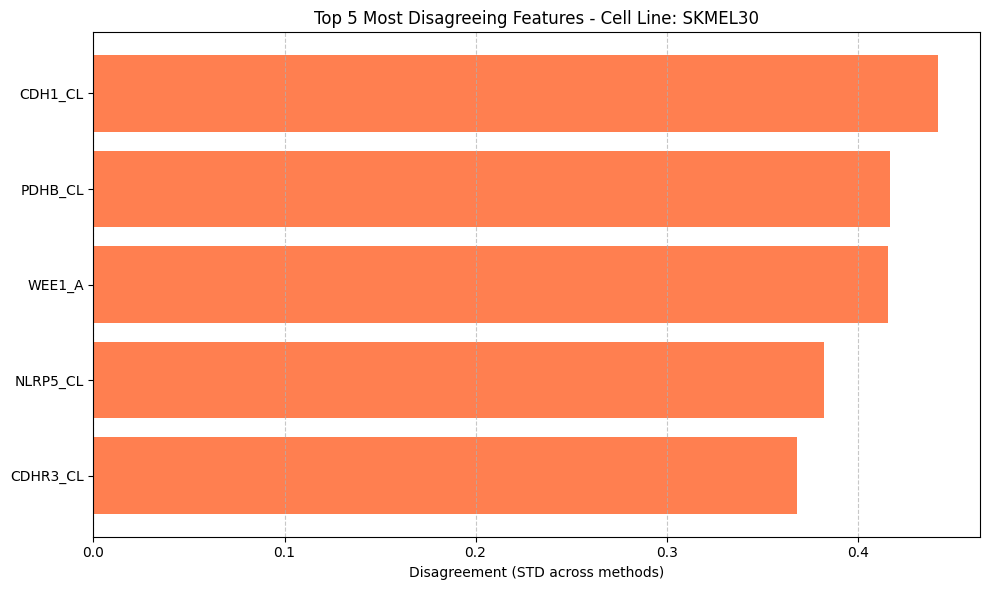

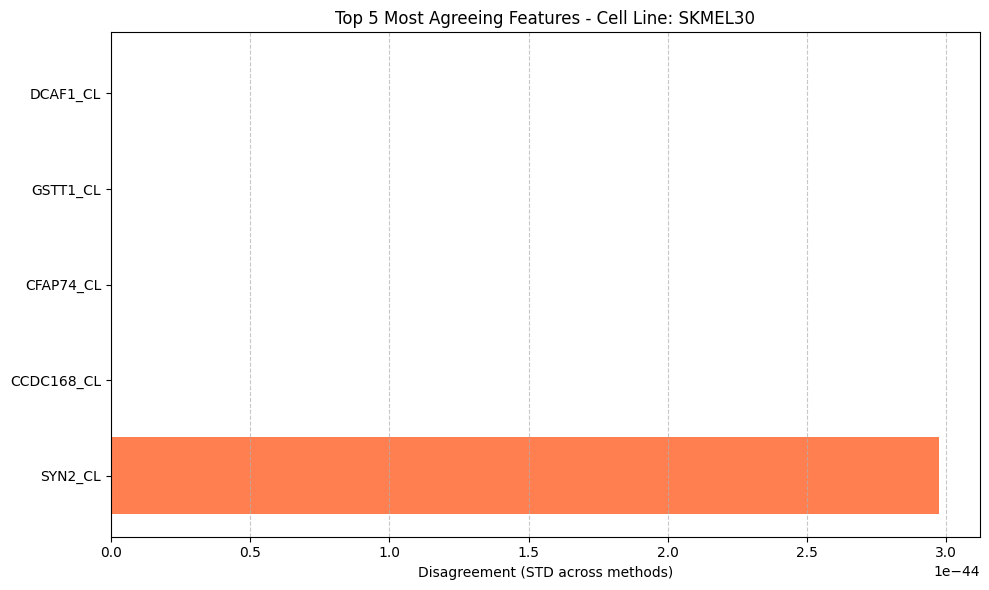

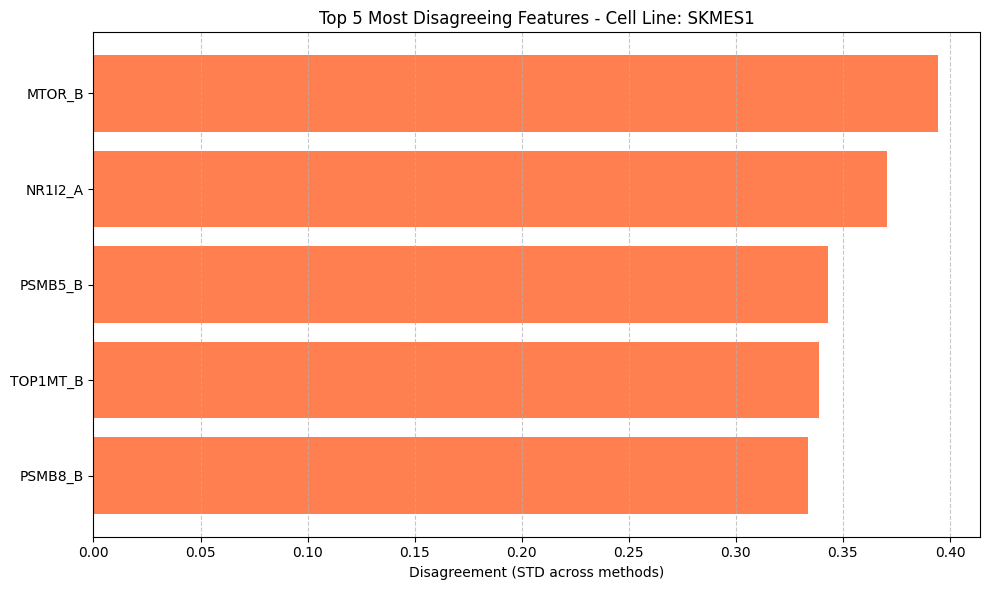

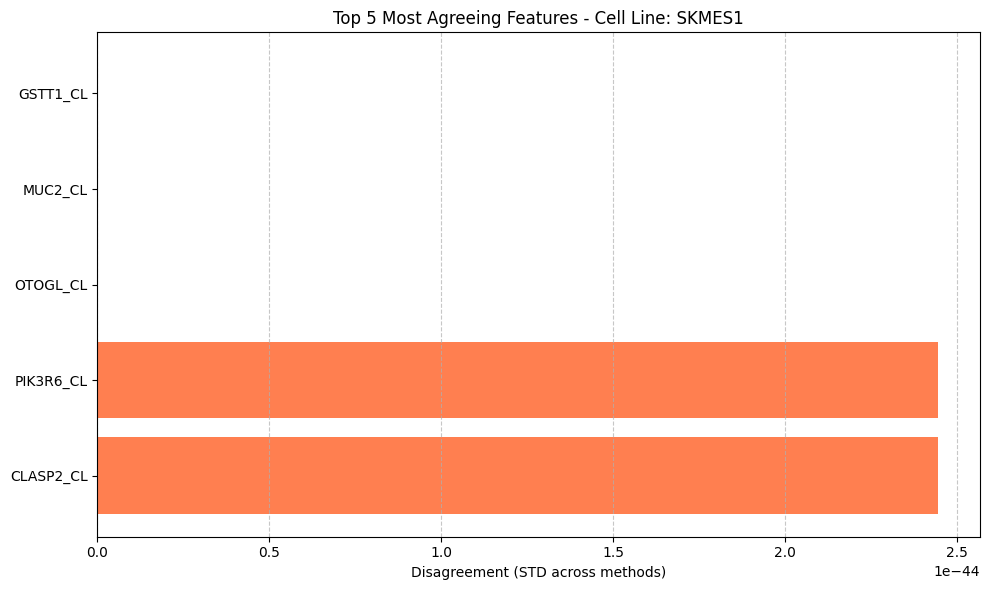

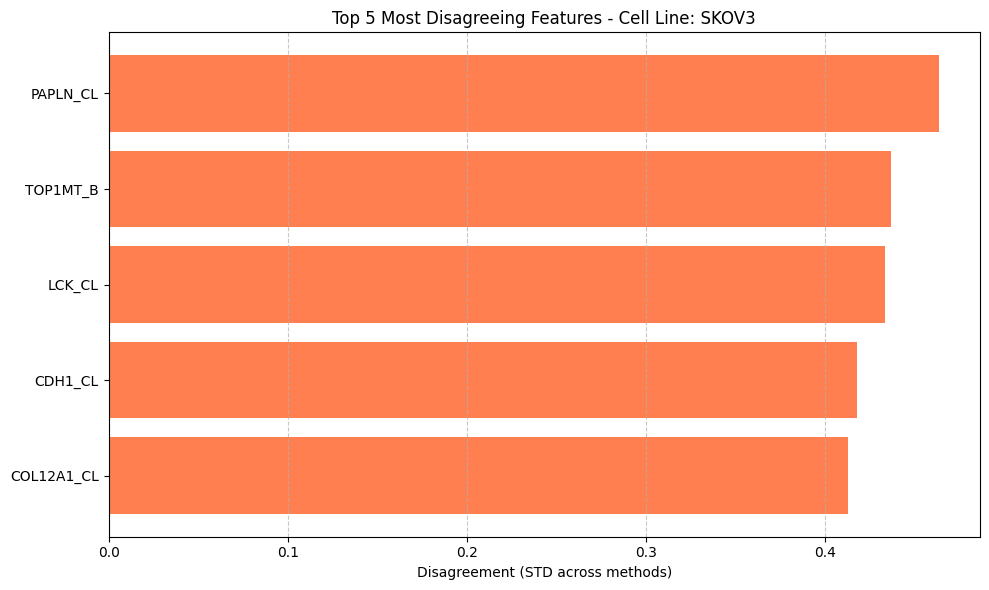

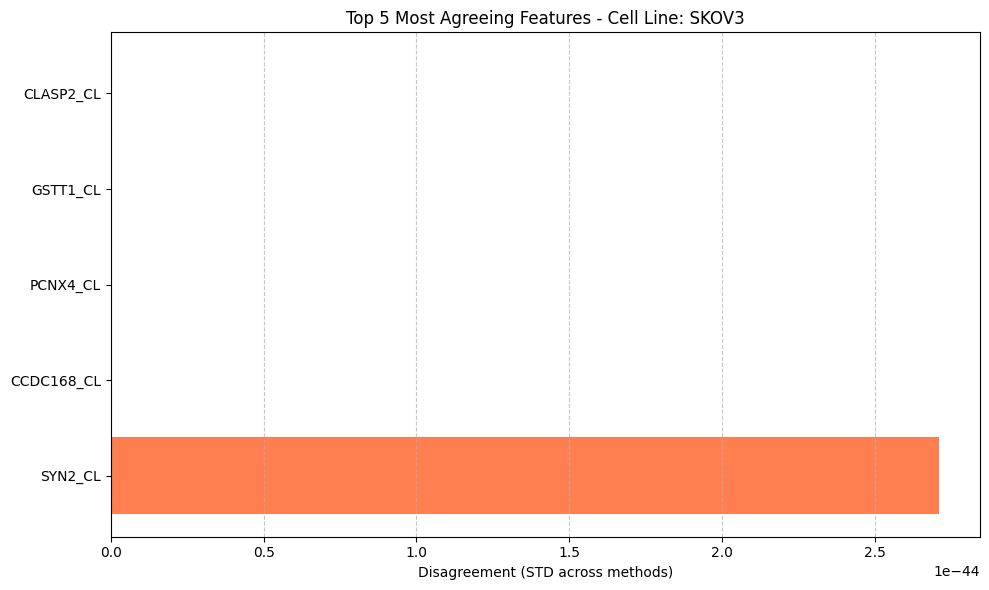

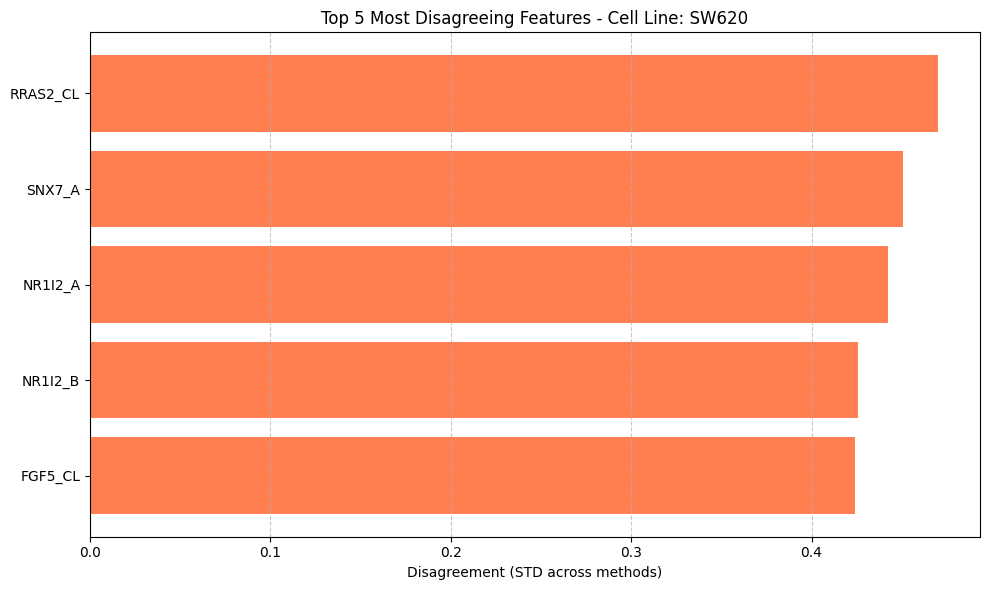

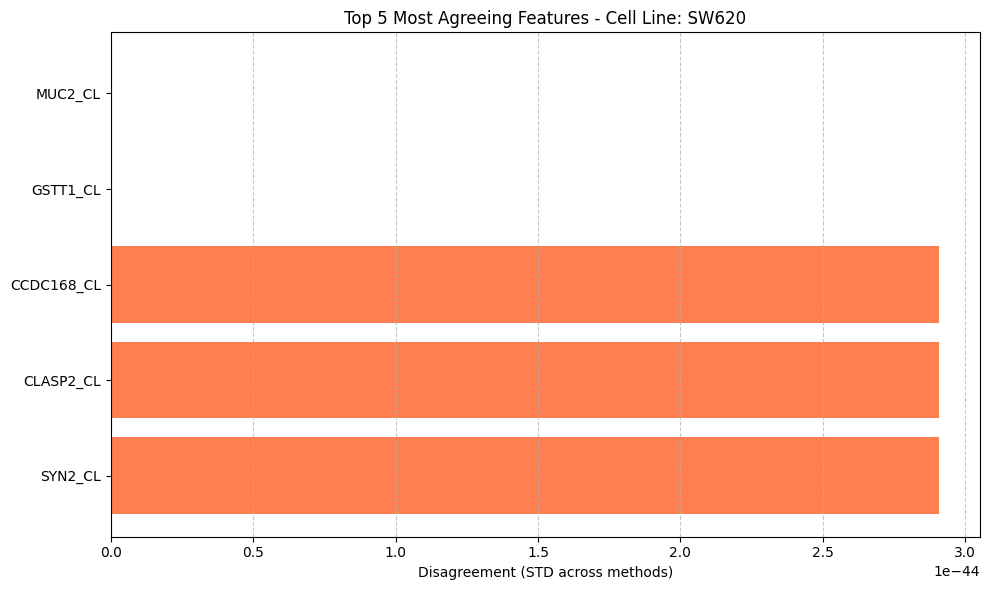

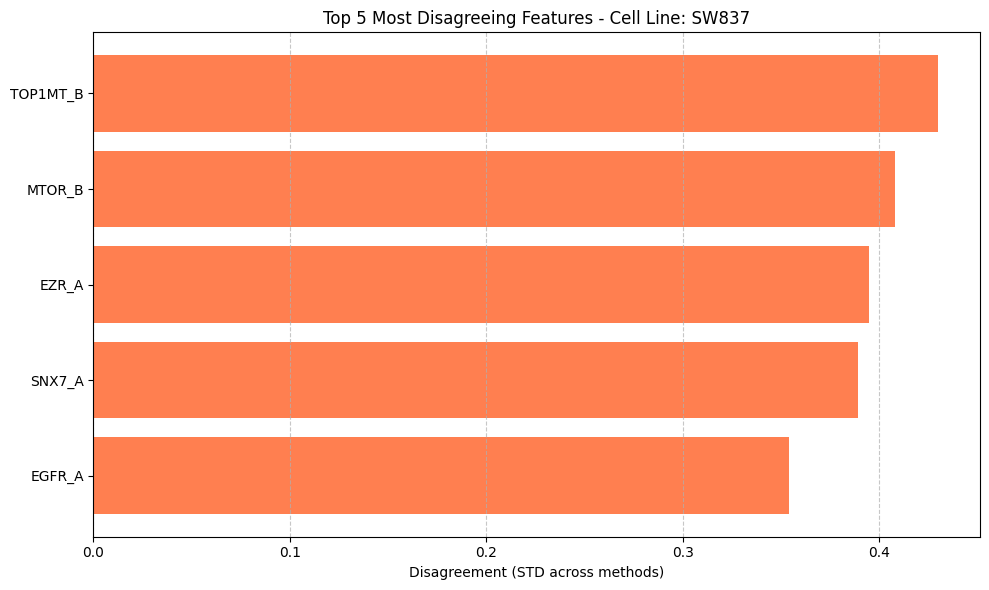

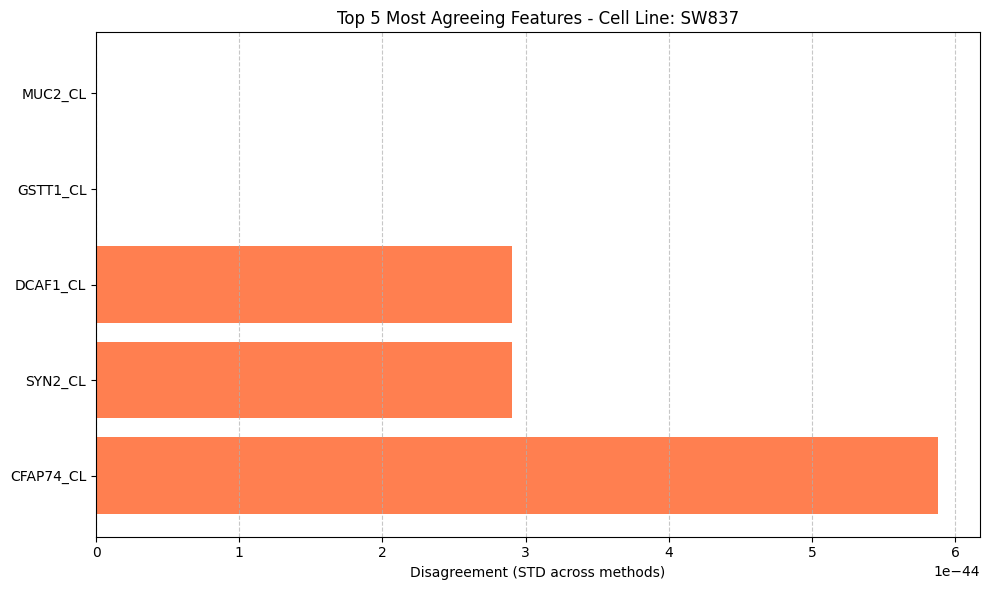

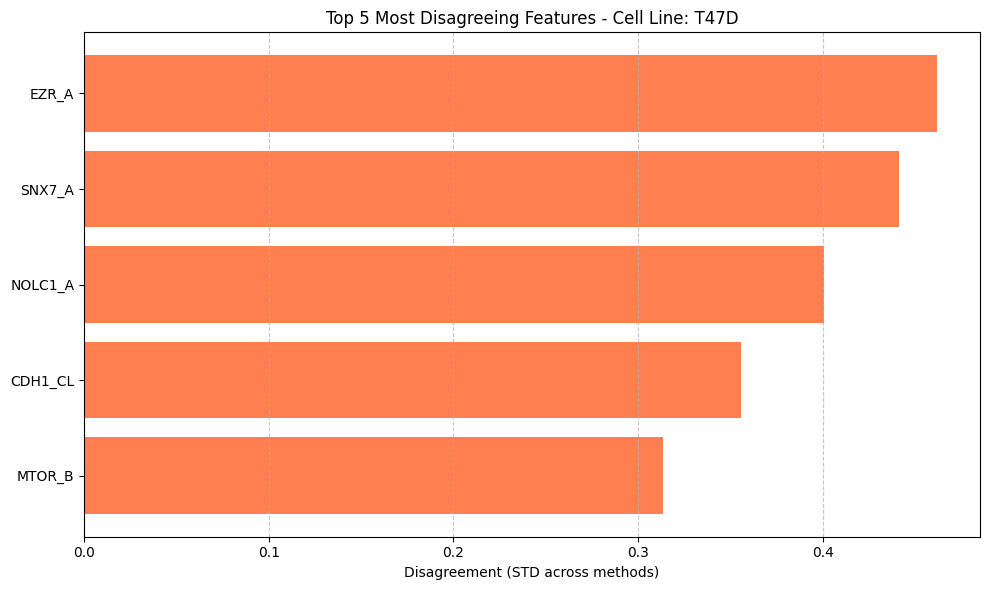

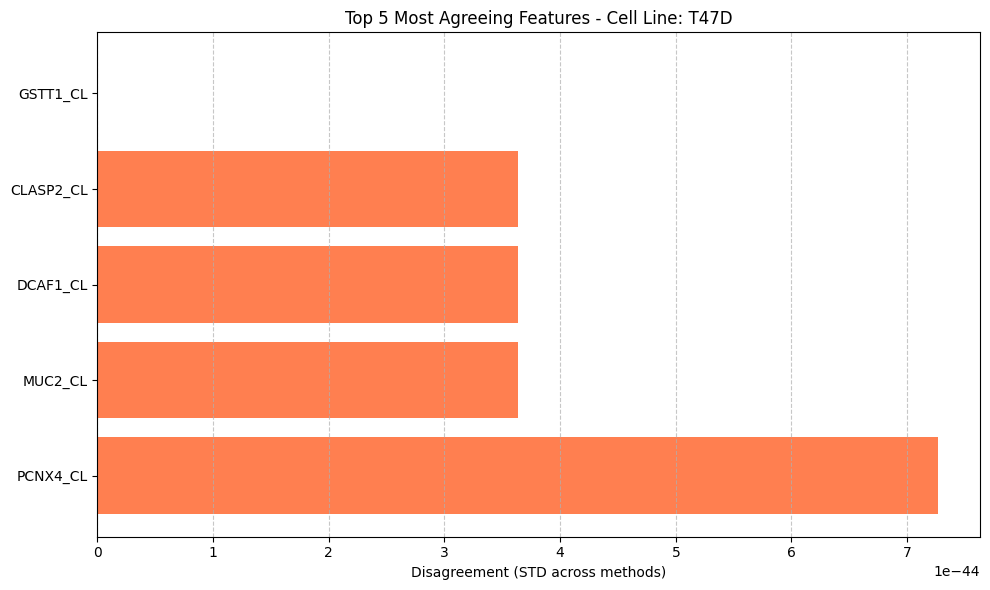

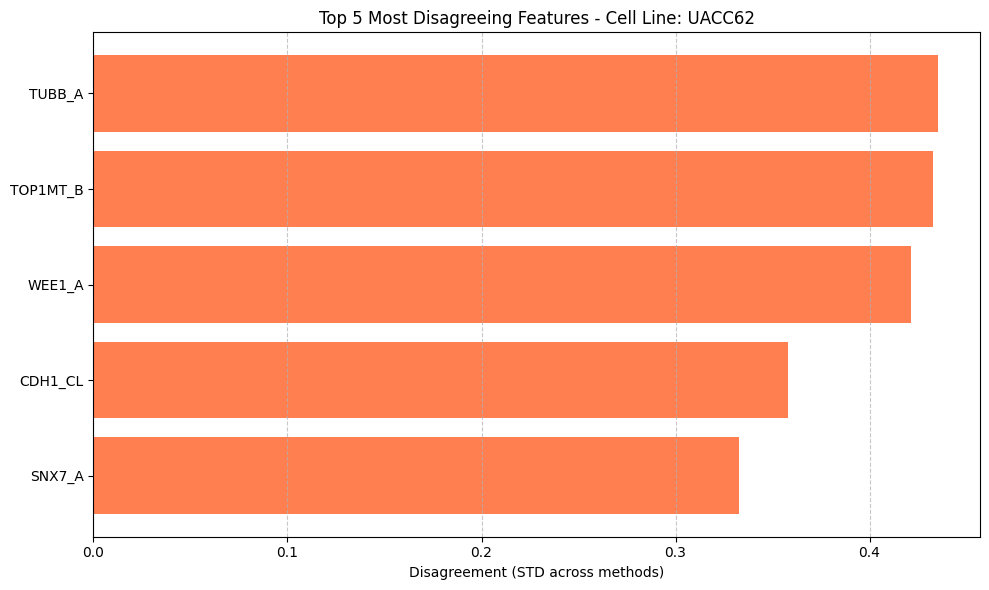

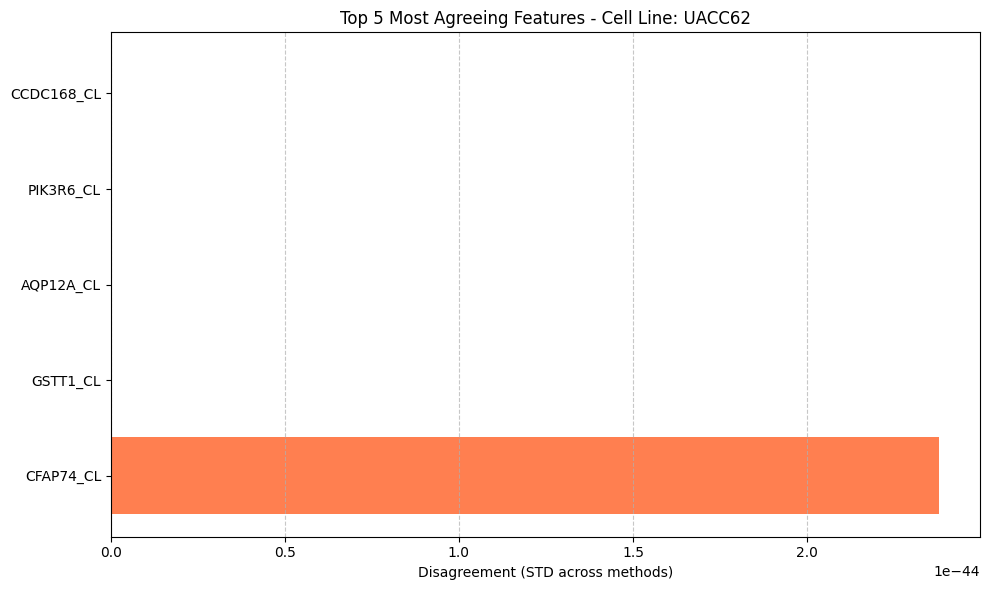

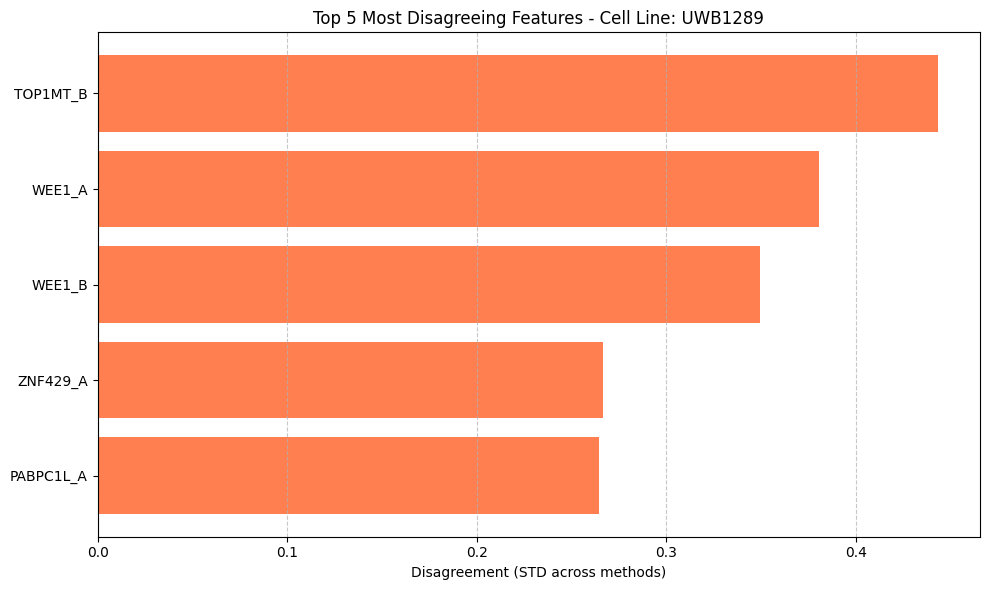

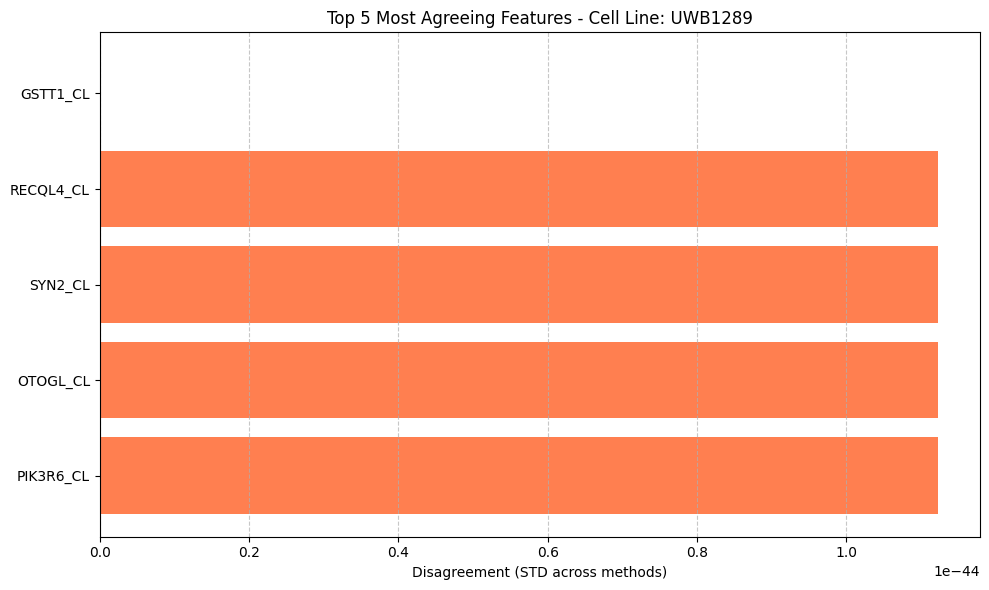

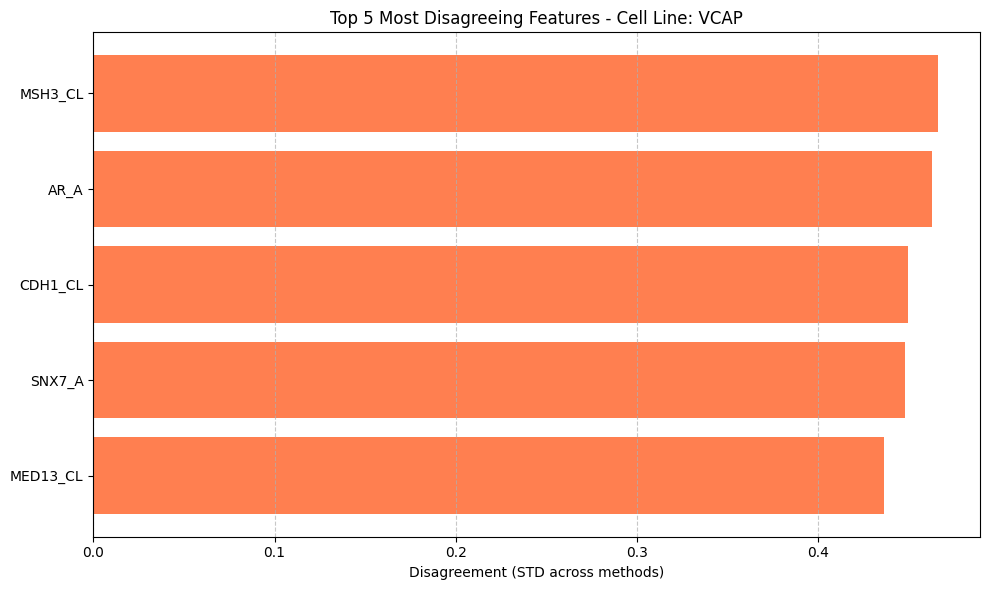

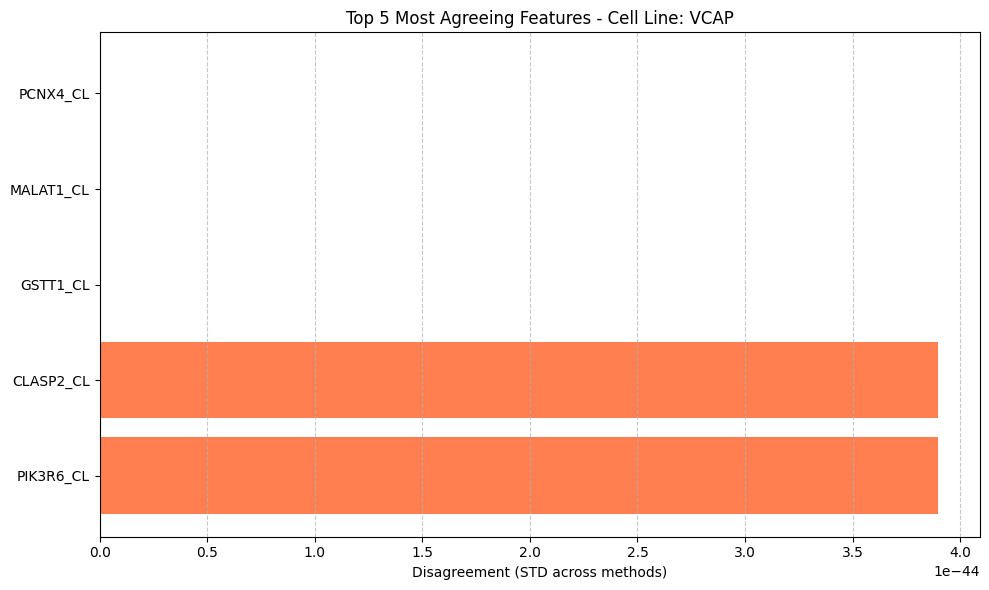

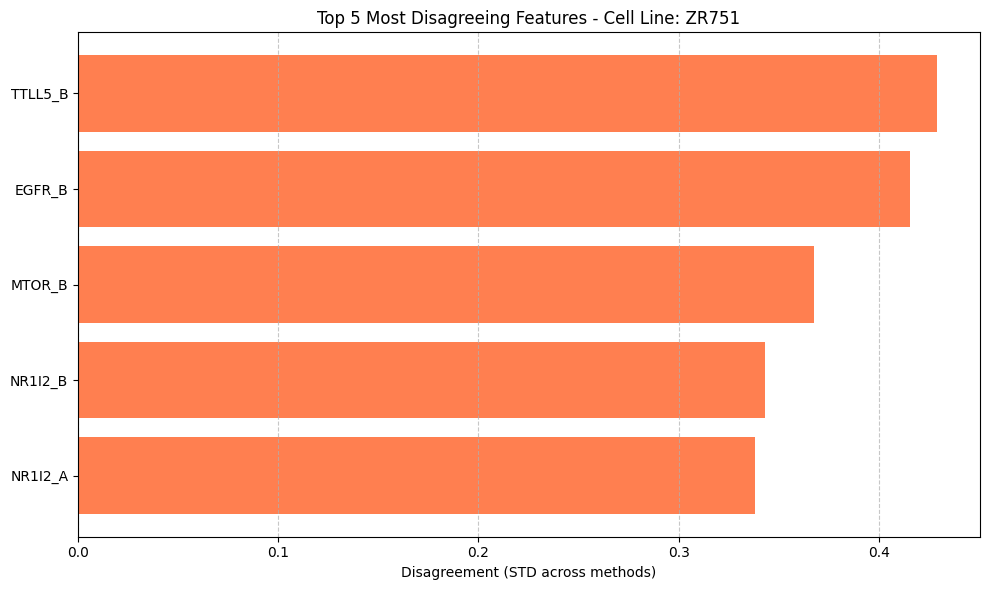

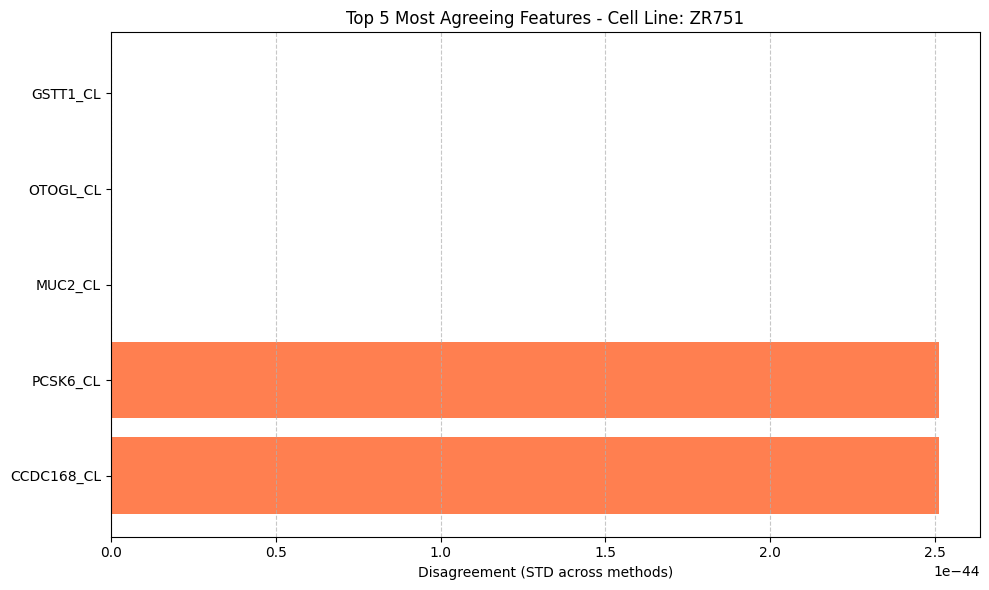

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from explainability.data_utils import load_transynergy_cell_line_data

def normalize_and_rescale_for_indices(attributions, indices):
    mean_vals = np.mean(attributions[indices], axis=0)  
    mean_abs = np.abs(mean_vals)  
    normed = mean_abs / np.sum(mean_abs)  
    return normed / np.max(normed) 

def plot_disagreement_barplot(df, title, top_n=10):
    plt.figure(figsize=(10, 6))
    plt.barh(df["feature"], df["disagreement"], color='coral')
    plt.xlabel("Disagreement (STD across methods)")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def rank_feature_disagreement_by_cell_line_with_plot(shap_values, lrp_values, ig_values, feature_names, top_n=10):
    cell_lines_train = np.concatenate([
        load_transynergy_cell_line_data(split='train'),
        load_transynergy_cell_line_data(split='train')
    ])
    cell_lines_test = load_transynergy_cell_line_data(split='test')
    cell_lines_test = np.array(cell_lines_test)
    cell_lines_train = np.array(cell_lines_train)
    
    sampled_cell_lines_shap = cell_lines_test[shap_indices]

    unique_train_cell_lines = np.unique(cell_lines_train)

    for cell_line in unique_train_cell_lines:
        shap_idx = np.where(sampled_cell_lines_shap == cell_line)[0]
        lrp_idx = np.where(cell_lines_test == cell_line)[0]
        ig_idx = np.where(cell_lines_train == cell_line)[0]

        if len(ig_idx) == 0:
            continue

        shap_imp = normalize_and_rescale_for_indices(shap_values, shap_idx)
        lrp_imp = normalize_and_rescale_for_indices(lrp_values, lrp_idx)
        ig_imp = normalize_and_rescale_for_indices(ig_values, ig_idx)

        disagreement = np.std(np.stack([shap_imp, lrp_imp, ig_imp]), axis=0)

        df = pd.DataFrame({
            "feature": feature_names,
            "disagreement": disagreement,
            "SHAP": shap_imp,
            "LRP": lrp_imp,
            "IG": ig_imp
        })
        
        top_disagree = df.sort_values("disagreement", ascending=False).head(top_n)
        top_agree = df.sort_values("disagreement", ascending=True).head(top_n)

        plot_disagreement_barplot(top_disagree, f"Top {top_n} Most Disagreeing Features - Cell Line: {cell_line}", top_n)
        plot_disagreement_barplot(top_agree, f"Top {top_n} Most Agreeing Features - Cell Line: {cell_line}", top_n)

rank_feature_disagreement_by_cell_line_with_plot(
    shap_values=shap_values,
    lrp_values=lrp_values,
    ig_values=ig_values,
    feature_names=feature_names,
    top_n=5
)
